<a href="https://colab.research.google.com/github/silviasd2025-bit/dea_studies/blob/main/20250930_malmq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

###Import relevant libraries
- Will use Pyomo for mathematical optimization
- Data source: Tom

# Malmquist Productivity Index, Technical Efficiency and Efficiency Change
## Energy

In [ ]:
!apt-get install -y -qq glpk-utils > /dev/null 2>&1

In [ ]:
from pyomo.environ import (ConcreteModel, Var, Objective, Constraint,
                           SolverFactory, minimize, maximize, NonNegativeReals,
                           ConstraintList, TerminationCondition)
import pandas as pd
import numpy as np
from datetime import datetime
import matplotlib.pyplot as plt
import io
import os
from google.colab import files
import warnings
warnings.filterwarnings("ignore")
from  scipy.stats.mstats import gmean

In [ ]:
# Get the path to the glpsol executable
glpk_executable_path = '/usr/bin/glpsol'  # Update with the actual path if different

# Set the solver path in the SolverFactory call
solver = SolverFactory('glpk', executable=glpk_executable_path)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##Data and Variables

We used data from G20 during 2000- 2023, every two consequtive time periods, to calculate the Malmquist Productivity Index (MPI) and its decomposition into technical change and efficiency change.



In [ ]:
#uploaded = files.upload()
file_path = "/content/drive/MyDrive/data/20250930_DEA_EnergySecurityPaper2.csv"
df = pd.read_csv(file_path)
df_2014 = df[df["year"] == 2014]
df_2022 = df[df["year"] == 2022]
df_2014[:20]

Unnamed: 0             dmu  year  installed_capacity_per_capita  \
14           14       Argentina  2014                          0.881   
38           38       Australia  2014                          2.078   
62           62          Brazil  2014                          0.544   
86           86          Canada  2014                          3.908   
110         110           China  2014                          1.006   
134         134            EU27  2014                          1.736   
158         158          France  2014                          1.787   
182         182         Germany  2014                          2.181   
206         206           India  2014                          0.186   
230         230       Indonesia  2014                          0.155   
254         254           Italy  2014                          1.460   
278         278           Japan  2014                          2.022   
302         302          Mexico  2014                          0.607   
326         326          Russia  2014                          1.731   
350         350    Saudi Arabia  2014                          3.778   
374         374    South Africa  2014                          0.866   
398         398     South Korea  2014                          1.619   
422         422          Turkey  2014                          0.873   
446         446  United Kingdom  2014                          1.347   
470         470   United States  2014                          3.361   

     energy_diversification  energy_import  percentage_renewable  mwh_capita  \
14                 0.263559       0.140678                10.396    3.287735   
38                 0.224210       0.000000                 5.663   10.495622   
62                 0.231661       0.142815                37.566    2.951495   
86                 0.255332       0.000000                27.026   18.324238   
110                0.178086       0.175574                 9.690    4.174820   
134                0.531479       0.636696                14.118    6.374860   
158                0.164134       0.479037                 9.885    8.753881   
182                0.397057       0.640352                12.840    7.603590   
206                0.171548       0.365659                 6.829    0.961855   
230                0.295663       0.000000                 4.708    0.917577   
254                0.484752       0.783880                18.517    4.558378   
278                0.320368       0.955690                 6.604    8.335938   
302                0.269855       0.000000                 6.426    2.532304   
326                0.302622       0.000000                 5.531    7.343079   
350                0.199070       0.000000                 0.004   11.317995   
374                0.122425       0.000000                 0.810    4.582443   
398                0.313291       0.868694                 1.259   10.692335   
422                0.287266       0.787335                 9.501    3.228634   
446                0.440458       0.497432                 8.506    5.211986   
470                0.371732       0.116968                 7.015   12.676619   

     gdp_capita  energy_export  carbon_intensity  
14    12.233144       0.000000          2.357726  
38    62.544087       1.855558          1.362061  
62    12.274994       0.000000          5.182991  
86    50.960843       0.667646          5.294924  
110    7.781066       0.000000          1.441488  
134   35.592887       0.000000          2.707462  
158   43.148046       0.000000         19.157984  
182   48.971082       0.000000          1.916881  
206    1.553884       0.000000          1.348612  
230    3.441068       1.230044          1.445946  
254   36.028349       0.000000          2.636884  
278   38.475395       0.000000          1.690533  
302   11.391377       0.079343          1.902590  
326   14.055473       0.834914          2.225754  
350   27.805485       1.726352          1.4439

##Data Preparation and Normalization

Our analysis employs a Data Envelopment Analysis (DEA) framework to calculate the Malmquist Productivity Index (MPI) and its components. The input variables comprise installed capacity per capita, inverse diversification index (HHI), country imports, renewable share, while the output variables are GDP and MWh per capita as desirable output and CO2 as undesirable output. Other runs countained different variable transformations / normalizations to address potential scale effects and heteroscedasticity. This run has been adjusted with the units of inputs and outputs.

In [ ]:
# Select Inputs and outputs for the MPI, TE, and EC
inputs_2014 = df_2014[['installed_capacity_per_capita', 'energy_diversification',
                       'energy_export', 'percentage_renewable']].values
outputs_2014 = df_2014[['mwh_capita', 'gdp_capita', 'carbon_intensity']].values

inputs_2014 = df_2022[['installed_capacity_per_capita', 'energy_diversification',
                       'energy_export', 'percentage_renewable']].values
outputs_2014 = df_2022[['mwh_capita', 'gdp_capita', 'carbon_intensity']].values
#inputs_2022 = df_2022[['l_pop_dev', 'l_healthworkforce']].values
#outputs_2022 = df_2022[['l_childsurvival']].values

Not applied on this run but on others, the normalization value to ensure numerical stability and comparable scales across variables, we implement a robust normalization procedure that scales all input and output variables to the [0.1, 1] range. This normalization is achieved through the following transformation:

$\text{normalized_value} = 0.1 + (0.9 \times \frac{x - \min(x)}{\max(x) - \min(x)})$

where $min(x)$ and $max(x)$ represent the minimum and maximum values for each variable across all DMUs. This transformation ensures that all values remain strictly positive while maintaining relative differences. The addition of 0.1 prevents potential numerical issues that could arise from zero values in the optimization process.

In [ ]:
def normalize_data(data):
    """
    Normalize data using robust scaling
    """
    min_vals = np.min(data, axis=0)
    max_vals = np.max(data, axis=0)
    range_vals = max_vals - min_vals
    range_vals[range_vals == 0] = 1

    # Scale to [0.1, 1] range
    normalized = 0.1 + 0.9 * (data - min_vals) / range_vals
    return normalized

##Efficiency Measurement

We employ an output-oriented Constant Returns to Scale (CRS) DEA model to calculate technical efficiency scores. The model is formulated as a linear programming problem:

$$
\begin{align*}
\max & \quad \phi \\
\text{subject to:} & \\
& \sum_{i} \lambda_i x_{ij} \leq x_{0j} \quad \text{for all inputs } j \\
& \sum_{i} \lambda_i y_{ik} \geq \phi y_{0k} \quad \text{for all outputs } k \\
& \lambda_i \geq 0 \quad \text{for all DMUs } i
\end{align*}
$$

where:
- $\phi$ represents the output expansion factor (efficiency score)
- $\lambda_i$ are the intensity variables
- $x_{ij}$ and $y_{ik}$ are the inputs and outputs of the reference DMUs
- $x_{0j}$ and $y_{0k}$ are the inputs and outputs of the DMU under evaluation

To handle potential computational instabilities, we incorporate an epsilon value ($1\text{e-}6$) in the constraints and implement bounds on the efficiency scores ($1.0 \leq \phi \leq 10.0$).

In [ ]:
def calculate_efficiency_crs(inputs, outputs, frontier_inputs, frontier_outputs, solver, dmu_index=None):
    """
    Calculate efficiency scores using output-oriented CRS DEA model
    """
    # Normalize data
    norm_inputs = normalize_data(inputs)
    norm_outputs = normalize_data(outputs)
    norm_frontier_inputs = normalize_data(frontier_inputs)
    norm_frontier_outputs = normalize_data(frontier_outputs)

    #print ("inputs")
    #print (inputs)
    #print ("norm_inputs")
    #print (norm_inputs)
    efficiencies = []

    for i in range(len(inputs)):
        model = ConcreteModel()

        # Variables
        model.phi = Var(domain=NonNegativeReals, bounds=(1.0, 10.0), initialize=1.0)
        model.lambdas = Var(range(len(frontier_inputs)), domain=NonNegativeReals, bounds=(0.0, 1.0))

        # Objective: maximize phi (output efficiency)
        model.obj = Objective(expr=model.phi, sense=maximize)

        # Constraints
        model.constraints = ConstraintList()

        # Input constraints with epsilon
        epsilon = 1e-6
        for j in range(inputs.shape[1]):
            model.constraints.add(
                sum(model.lambdas[k] * norm_frontier_inputs[k, j]
                    for k in range(len(frontier_inputs))) <= norm_inputs[i, j] + epsilon
            )

        # Output constraints with epsilon
        for j in range(outputs.shape[1]):
            model.constraints.add(
                sum(model.lambdas[k] * norm_frontier_outputs[k, j]
                    for k in range(len(frontier_outputs))) >= model.phi * norm_outputs[i, j] - epsilon
            )

        try:
            result = solver.solve(model)

            if result.solver.termination_condition == TerminationCondition.optimal:
                eff_value = 1 / float(model.phi.value)  # Convert to efficiency score

                # Validate efficiency value
                if eff_value < 0.1 or eff_value > 1.0 or np.isnan(eff_value):
                    print(f"Warning: Invalid efficiency value {eff_value} for DMU {dmu_index if dmu_index is not None else i}")
                    eff_value = 1.0

                efficiencies.append(eff_value)
            else:
                #print(f"Warning: Non-optimal solution for DMU {dmu_index if dmu_index is not None else i}")
                efficiencies.append(1.0)

        except Exception as e:
            print(f"Error solving DEA for DMU {dmu_index if dmu_index is not None else i}: {str(e)}")
            efficiencies.append(1.0)

    return np.array(efficiencies)

## Malmquist Productivity Index Calculation

The MPI is calculated between two time periods ($t$ and $t+1$) and decomposed into efficiency change and technical change components. Following Färe et al. (1994), the MPI is computed as:

$\text{MPI} = \text{Efficiency Change} \times \text{Technical Change}$

where:

$\text{Efficiency Change} = \frac{E(t+1,t+1)}{E(t,t)}$

$\text{Technical Change} = \sqrt{\left[\frac{E(t,t)}{E(t,t+1)} \times \frac{E(t+1,t)}{E(t+1,t+1)}\right]}$

$E(a,b)$ represents the efficiency score of period $a$ data relative to period $b$ technology frontier.

In [ ]:
def calculate_mpi_with_decomposition(inputs_t, outputs_t, inputs_t1, outputs_t1, solver, dmu_indices=None):
    """
    Calculate MPI and its decomposition
    """
    # Calculate efficiencies
    #print("\nCalculating period t efficiencies...")
    #print("inputs_t")
    #print(inputs_t)
    #print (dmu_indices)

    eff_t_t = calculate_efficiency_crs(inputs_t, outputs_t, inputs_t, outputs_t, solver, dmu_indices)
    #print ("eff_t_t")
    #print(eff_t_t)
    #print("\nCalculating period t+1 efficiencies...")
    eff_t1_t1 = calculate_efficiency_crs(inputs_t1, outputs_t1, inputs_t1, outputs_t1, solver, dmu_indices)

    #print("\nCalculating cross-period efficiencies...")
    eff_t_t1 = calculate_efficiency_crs(inputs_t, outputs_t, inputs_t1, outputs_t1, solver, dmu_indices)
    eff_t1_t = calculate_efficiency_crs(inputs_t1, outputs_t1, inputs_t, outputs_t, solver, dmu_indices)

    # Handle potential numerical issues
    epsilon = 1e-10
    eff_t_t = np.maximum(eff_t_t, epsilon)
    eff_t1_t1 = np.maximum(eff_t1_t1, epsilon)
    eff_t_t1 = np.maximum(eff_t_t1, epsilon)
    eff_t1_t = np.maximum(eff_t1_t, epsilon)

    # Calculate components
    efficiency_change = eff_t1_t1 / eff_t_t
    technical_change = np.sqrt((eff_t_t / eff_t_t1) * (eff_t1_t / eff_t1_t1))
    mpi = efficiency_change * technical_change

    return mpi, technical_change, efficiency_change

##Bootstrap Procedure

To assess the statistical reliability of our MPI estimates, we implement a bootstrap procedure with bias correction. The bootstrap process involves:

Random resampling with replacement from the original dataset
Recalculation of MPI and its components for each bootstrap sample
Construction of bias-corrected confidence intervals

For each DMU, we calculate bias-corrected confidence intervals at the $α = 0.05$ significance level using $n = 1,000$ bootstrap iterations.

The bias correction adjusts the percentile selection based on the relationship between the bootstrap mean and the original estimate:

# Bias Correction for Percentile Selection

The bias correction adjusts the percentile selection based on the relationship between the bootstrap mean and the original estimate:

If $\text{bootstrap_mean} < \text{original_estimate}$:
- $\text{lower_percentile} = \max(\alpha/2, \alpha)$
- $\text{upper_percentile} = 1 - \alpha/2$

Otherwise:
- $\text{lower_percentile} = \alpha/2$
- $\text{upper_percentile} = 1 - \alpha/2$

This approach provides more conservative confidence intervals when bootstrap estimates suggest potential bias in the original calculations.

In [ ]:
def bootstrap_mpi(inputs_t, outputs_t, inputs_t1, outputs_t1, solver,
                 n_bootstrap=1000, alpha=0.05):
    """
    Perform bootstrap with corrected confidence interval calculation
    """
    n_dmus = len(inputs_t)
    mpi_boots = np.zeros((n_bootstrap, n_dmus))
    tech_boots = np.zeros((n_bootstrap, n_dmus))
    eff_boots = np.zeros((n_bootstrap, n_dmus))

    # Calculate original values
    mpi_orig, tech_orig, eff_orig = calculate_mpi_with_decomposition(
        inputs_t, outputs_t, inputs_t1, outputs_t1, solver
    )

    for b in range(n_bootstrap):
        #print(f"\nBootstrap iteration {b+1}/{n_bootstrap}")
        indices = np.random.choice(n_dmus, size=n_dmus, replace=True)

        inputs_t_boot = inputs_t[indices]
        outputs_t_boot = outputs_t[indices]
        inputs_t1_boot = inputs_t1[indices]
        outputs_t1_boot = outputs_t1[indices]

        mpi_b, tech_b, eff_b = calculate_mpi_with_decomposition(
            inputs_t_boot, outputs_t_boot,
            inputs_t1_boot, outputs_t1_boot,
            solver, indices
        )

        mpi_boots[b] = mpi_b
        tech_boots[b] = tech_b
        eff_boots[b] = eff_b

    # Calculate bias-corrected confidence intervals
    mpi_ci = np.zeros((2, n_dmus))
    tech_ci = np.zeros((2, n_dmus))
    eff_ci = np.zeros((2, n_dmus))

    for i in range(n_dmus):
        # For each index, calculate bias-corrected intervals
        mpi_bias = np.mean(mpi_boots[:, i]) - mpi_orig[i]
        mpi_sorted = np.sort(mpi_boots[:, i])

        # Adjust percentiles based on bias
        if mpi_bias < 0:
            # If bootstrap mean is less than original, adjust lower bound
            lower_pct = max(alpha/2, alpha)
            upper_pct = 1 - alpha/2
        else:
            # If bootstrap mean is greater, use standard percentiles
            lower_pct = alpha/2
            upper_pct = 1 - alpha/2

        lower_idx = int(lower_pct * n_bootstrap)
        upper_idx = int(upper_pct * n_bootstrap)

        mpi_ci[:, i] = [mpi_sorted[lower_idx], mpi_sorted[upper_idx]]

        # Repeat for technical change and efficiency change
        tech_bias = np.mean(tech_boots[:, i]) - tech_orig[i]
        tech_sorted = np.sort(tech_boots[:, i])

        if tech_bias < 0:
            lower_pct = max(alpha/2, alpha)
            upper_pct = 1 - alpha/2
        else:
            lower_pct = alpha/2
            upper_pct = 1 - alpha/2

        lower_idx = int(lower_pct * n_bootstrap)
        upper_idx = int(upper_pct * n_bootstrap)

        tech_ci[:, i] = [tech_sorted[lower_idx], tech_sorted[upper_idx]]

        eff_bias = np.mean(eff_boots[:, i]) - eff_orig[i]
        eff_sorted = np.sort(eff_boots[:, i])

        if eff_bias < 0:
            lower_pct = max(alpha/2, alpha)
            upper_pct = 1 - alpha/2
        else:
            lower_pct = alpha/2
            upper_pct = 1 - alpha/2

        lower_idx = int(lower_pct * n_bootstrap)
        upper_idx = int(upper_pct * n_bootstrap)

        eff_ci[:, i] = [eff_sorted[lower_idx], eff_sorted[upper_idx]]

    return mpi_ci, tech_ci, eff_ci



##Implementation

The analysis is implemented using Python 3.x, leveraging the Pyomo optimization framework for DEA calculations and NumPy for numerical computations. The GLPK solver is employed for solving the linear programming problems. To ensure solution reliability, we implement multiple safeguards:

- Validation of efficiency scores $(0.1 ≤ efficiency ≤ 1.0)$
- Handling of non-optimal solutions
- Error trapping for solver failures
- Minimum threshold $(ε = 1e-10)$ for efficiency scores to prevent division by zero

The complete analysis pipeline does the following:
- processes the data in parallel for both time periods,
- calculates the MPI and its decomposition,
- and performs the bootstrap procedure to generate confidence intervals for all metrics.

In [ ]:
def run_analysis(df, year1, year2, bootstrap):
    """
    Run the complete MPI analysis
    """
    # Initialize solver
    solver = SolverFactory('glpk', executable='/usr/bin/glpsol')

    # Split data by year

    df_year1 = df[df['year'] == year1]
    df_year2 = df[df['year'] == year2]

    # Prepare inputs and outputs

    #input_cols = ['installed_capacity_per_capita', 'energy_diversification',
    #                   'energy_export', 'percentage_renewable']
    #output_cols = ['mwh_capita', 'gdp_capita', 'inverse_carbon_intensity']


    input_cols = ['energy_diversification',
                  'energy_import',
                  'percentage_renewable',
                  'installed_capacity_per_capita',
                ]
    output_cols = ['mwh_capita',
                   'gdp_capita',
                   'energy_export',
                   'carbon_intensity']

    #inputs_dea = pd.DataFrame({'Inverse Energy Diversification': i_energy_diversification_year,
    ##                         'Energy Import': i_energy_import_year,
    #                         'Percentage Renewable Energy': i_perc_renewable_year,
    #                         'Installed Capacity per Capita': i_installed_capacity_per_capita_year,

     #                       })

    #outputs_dea = pd.DataFrame({'MWH per Capita': o_mwh_capita_year,
    #                          'GDP per Capita':o_gdp_capita_year,
    #                          'Energy Export': o_energy_export_year,
                              #'Electrification': o_electrification_year,
    #                          'Inverse Carbon Intensity': o_carbon_intensity_year
    #                              })


    #input_cols = ['l_pop_dev', 'l_healthworkforce', 'l_women_education',
    #             'l_water', 'l_better_nutrition']
    #output_cols = ['l_childsurvival']

    inputs_year1  = df_year1[input_cols].values
    outputs_year1 = df_year1[output_cols].values
    inputs_year2  = df_year2[input_cols].values
    outputs_year2 = df_year2[output_cols].values

    # Print data info
    print("\nData shapes:")
    print ("First year", df_year1)
    print(f"Year1 data: {df_year1.shape}")
    print("Second year", df_year2)
    print(f"year2 data: {df_year2.shape}")

    # Calculate base MPI and decomposition
    print("\nCalculating base MPI...")
    mpi, tech_change, eff_change = calculate_mpi_with_decomposition(
        inputs_year1, outputs_year1,
        inputs_year2, outputs_year2,
        solver
    )

    # Calculate bootstrap confidence intervals
    if bootstrap != 0:
      print("\nCalculating bootstrap confidence intervals...")
      mpi_ci, tech_ci, eff_ci = bootstrap_mpi(
          inputs_year1, outputs_year1,
          inputs_year2, outputs_year2,
          solver,
          n_bootstrap=100  # Reduced number of bootstrap iterations
    )

    # Create results DataFrame
    if bootstrap != 0:
      results = pd.DataFrame({
          'DMU': df_year1['dmu'],
          'MPI': mpi,
          'MPI_CI_Lower': mpi_ci[0],
          'MPI_CI_Upper': mpi_ci[1],
          'Technical_Change': tech_change,
          'Tech_CI_Lower': tech_ci[0],
          'Tech_CI_Upper': tech_ci[1],
          'Efficiency_Change': eff_change,
          'Eff_CI_Lower': eff_ci[0],
          'Eff_CI_Upper': eff_ci[1]
      })
    else:
        results = pd.DataFrame({
          'DMU': df_year1['dmu'],
          'MPI': mpi,
          'Technical_Change': tech_change,
          'Efficiency_Change': eff_change,
     })
    # Add summary statistics
    summary_stats = pd.DataFrame({
        'Statistic': ['Mean', 'Median', 'Std Dev', 'Min', 'Max'],
        'MPI': [results['MPI'].mean(), results['MPI'].median(),
                results['MPI'].std(), results['MPI'].min(), results['MPI'].max()],
        'Technical_Change': [results['Technical_Change'].mean(), results['Technical_Change'].median(),
                           results['Technical_Change'].std(), results['Technical_Change'].min(),
                           results['Technical_Change'].max()],
        'Efficiency_Change': [results['Efficiency_Change'].mean(), results['Efficiency_Change'].median(),
                            results['Efficiency_Change'].std(), results['Efficiency_Change'].min(),
                            results['Efficiency_Change'].max()]
    })

    return results, summary_stats


In [ ]:

# Load data
df = pd.read_csv("/content/drive/MyDrive/data/20250930_DEA_EnergySecurityPaper2.csv")
#df = pd.read_stata(io.BytesIO(uploaded["trial_data.dta"]))
# Run analysis
#file_path = "/content/20250914_DEA_EnergySecurityPaper2.xlsx"


## Results
- Inspect the results including the summary data
- Generate a few visualizations
- Export the results to CSV

### Generate visualization for MPI

In [ ]:
def generate_visualization_MPI(results, figure=None, bootstrap=0):
    df3 = pd.DataFrame(results)
    # Sort by mean MPI to make the plot more readable
    df4 = df3.sort_values('MPI', ascending=True)

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot the mean GDP points
    ax.scatter(df4['MPI'], range(len(df4)), color='blue', label='Mean GDP')

    # Plot the confidence intervals
    if bootstrap != 0:
      for idx, row in df4.iterrows():
          ax.hlines(y=df4.index.get_loc(idx),
                    xmin=row['MPI_CI_Lower'],
                    xmax=row['MPI_CI_Upper'],
                    color='blue',
                    alpha=0.3)
      ax.set_title('Mean MPI by Country with 95% Confidence Intervals')
    else:
      ax.set_title('MPI by Country')


    # Customize the plot
    ax.set_yticks(range(len(df4)))
    ax.set_yticklabels(df4['DMU'])
    ax.set_xlabel('MPI')

    # Add a grid for better readability
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()
    # Show the plot
    if figure is None:
        plt.show()
    else:
        plt.savefig(figure)

    return 0

### Generate visualization for technical efficiency

In [ ]:
def generate_visualization_technical_effficiency(results, figure=None, bootstrap = 0):
    df3 = pd.DataFrame(results)
    # Sort by mean GDP to make the plot more readable

    df4 = df3.sort_values('Technical_Change', ascending=True)

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot the mean tE points
    ax.scatter(df4['Technical_Change'], range(len(df4)), color='blue', label='Mean GDP')

    # Plot the confidence intervals
    if bootstrap != 0:
      for idx, row in df4.iterrows():
          ax.hlines(y=df4.index.get_loc(idx),
                    xmin=row['Tech_CI_Lower'],
                    xmax=row['Tech_CI_Upper'],
                    color='blue',
                    alpha=0.3)
      ax.set_title('Mean TE by Country with 95% Confidence Intervals')
    else:
      ax.set_title('TE by Country')

    # Customize the plot
    ax.set_yticks(range(len(df4)))
    ax.set_yticklabels(df4['DMU'])
    ax.set_xlabel('TE')

    # Add a grid for better readability
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    # Show the plot

    if figure is None:
        plt.show()
    else:
        plt.savefig(figure)

    return 0

### Generate visualization for efficiency change

In [ ]:
def generate_visualization_efficiency_change(results, figure = None, bootstrap = 0):

    df3 = pd.DataFrame(results)
    # Sort by mean EC to make the plot more readable
    df4 = df3.sort_values('Efficiency_Change', ascending=True)

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot the mean EC points
    ax.scatter(df4['Efficiency_Change'], range(len(df4)), color='blue', label='Mean GDP')

    # Plot the confidence intervals
    if bootstrap != 0:
      for idx, row in df4.iterrows():
          ax.hlines(y=df4.index.get_loc(idx),
                    xmin=row['Eff_CI_Lower'],
                    xmax=row['Eff_CI_Upper'],
                    color='blue',
                    alpha=0.3)
      ax.set_title('Mean Efficiency_Change by Country with 95% Confidence Intervals')
    else:
      ax.set_title('Efficiency_Change by Country')

    # Customize the plot
    ax.set_yticks(range(len(df4)))
    ax.set_yticklabels(df4['DMU'])
    ax.set_xlabel('Efficiency_Change')

    # Add a grid for better readability
    ax.grid(True, axis='x', linestyle='--', alpha=0.7)

    # Adjust layout to prevent label cutoff
    plt.tight_layout()

    # Show the plot

    if figure is None:
        plt.show()
    else:
        plt.savefig(figure)

    return 0

In [ ]:
def run_all(df, year1, year2, bootstrap):
    results, summary = run_analysis(df, year1, year2, bootstrap)

    # Save results
    suffix_str = "malmq_%s_%s" % (year1, year2)
    dir2write = datetime.now().strftime("/content/drive/MyDrive/out/%Y%m%d%H%M%S") + suffix_str
    os.mkdir(dir2write )
    mpi_results = os.path.join(dir2write, "mpi_results_%s_%s.csv" % (year1, year2))
    mpi_summary = os.path.join(dir2write, "mpi_summary_%s_%s.csv" % (year1, year2))

    results.to_csv(mpi_results, index=False)
    summary.to_csv(mpi_summary, index=False)

    pd.DataFrame(summary)
    pd.DataFrame(results)[:10]

    ret = generate_visualization_MPI(results,os.path.join(dir2write,"mpi_%s_%s.png" % (year1, year2)), bootstrap)
    ret = generate_visualization_technical_effficiency(results,os.path.join(dir2write,"tech_eff_%s_%s.png" % (year1, year2)),bootstrap)
    ret = generate_visualization_efficiency_change(results,os.path.join(dir2write,"efficiency_change_%s_%s.png" % (year1, year2)), bootstrap)
    ret = 0
    return results, summary, ret





*************************************
Analyzing following time period 2000 2001
*************************************

Data shapes:
First year      Unnamed: 0             dmu  year  installed_capacity_per_capita  \
0             0       Argentina  2000                          0.720   
24           24       Australia  2000                          1.866   
48           48          Brazil  2000                          0.393   
72           72          Canada  2000                          3.652   
96           96           China  2000                          0.258   
120         120            EU27  2000                          1.333   
144         144          France  2000                          1.751   
168         168         Germany  2000                          1.375   
192         192           India  2000                          0.096   
216         216       Indonesia  2000                          0.108   
240         240           Italy  2000                         

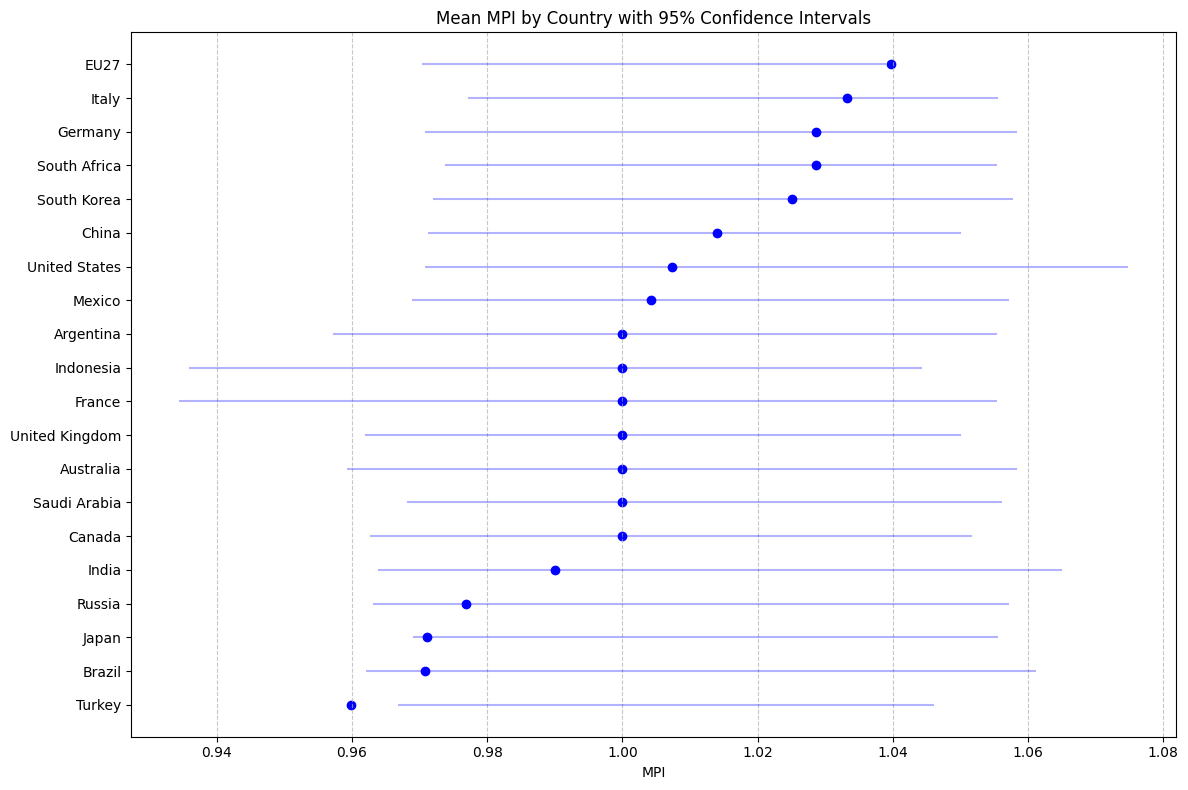

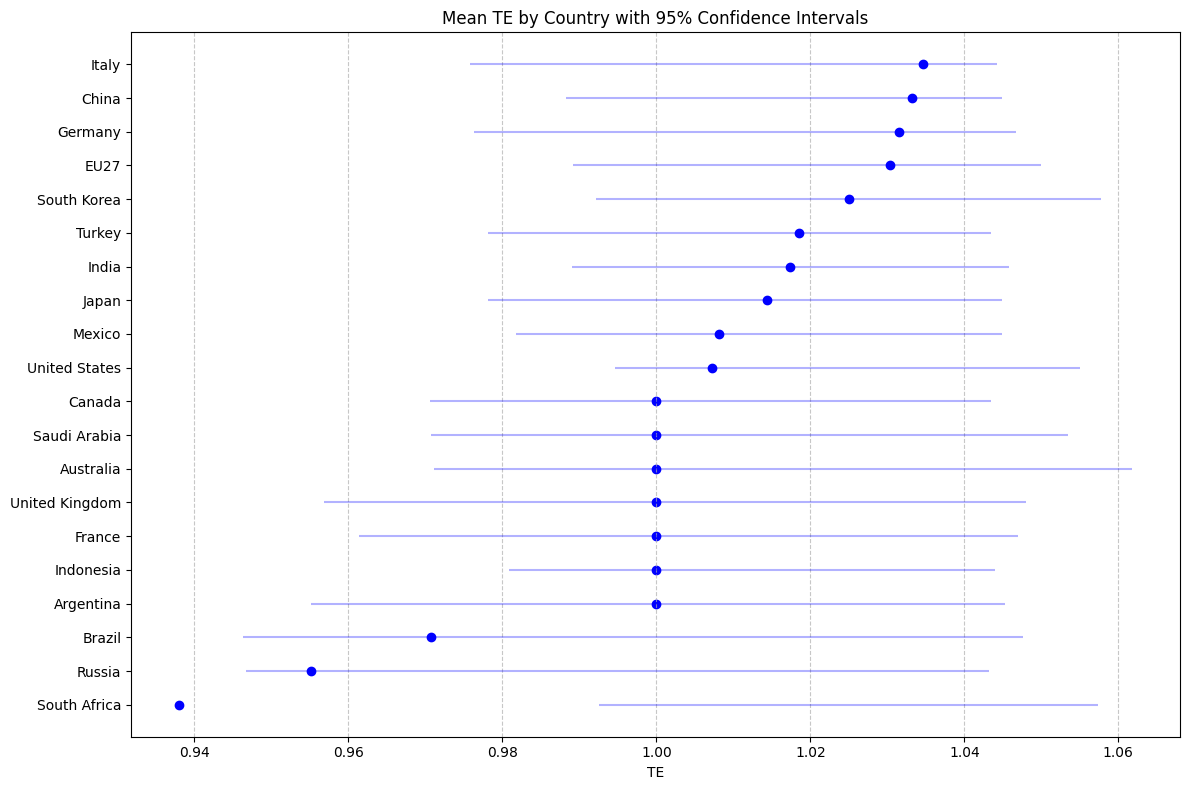

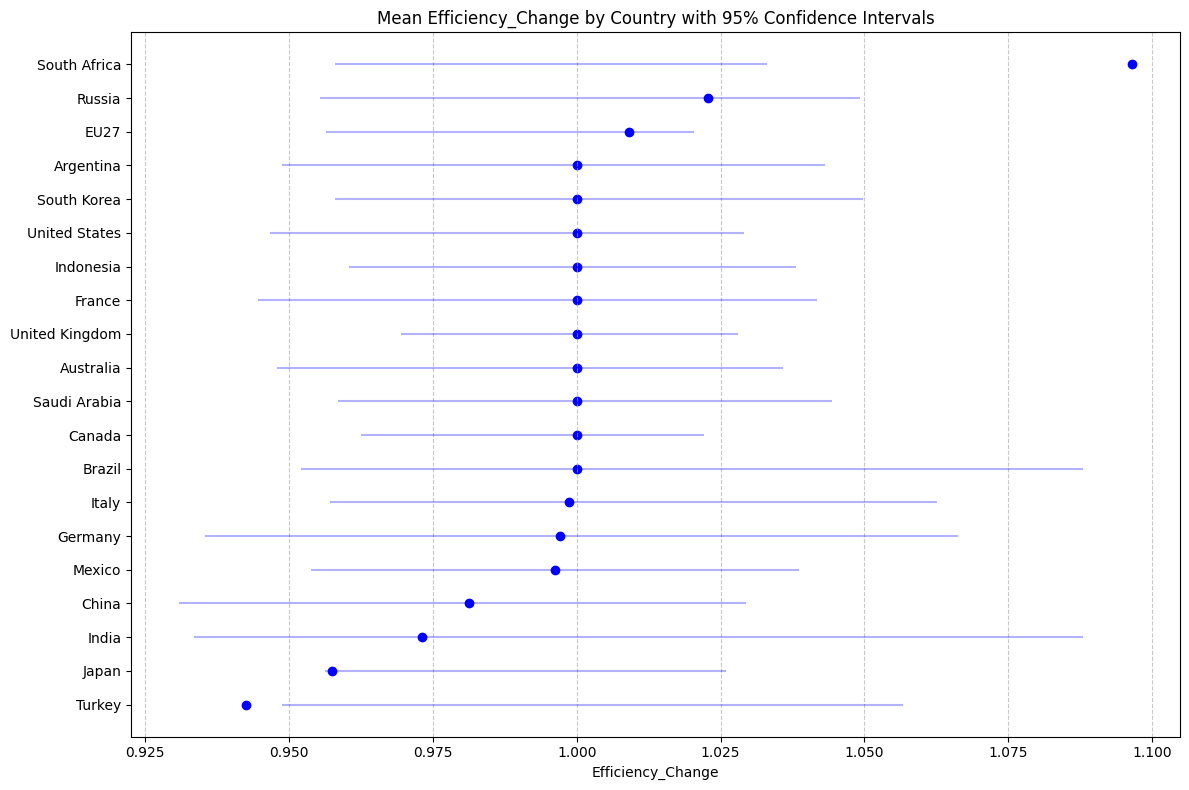

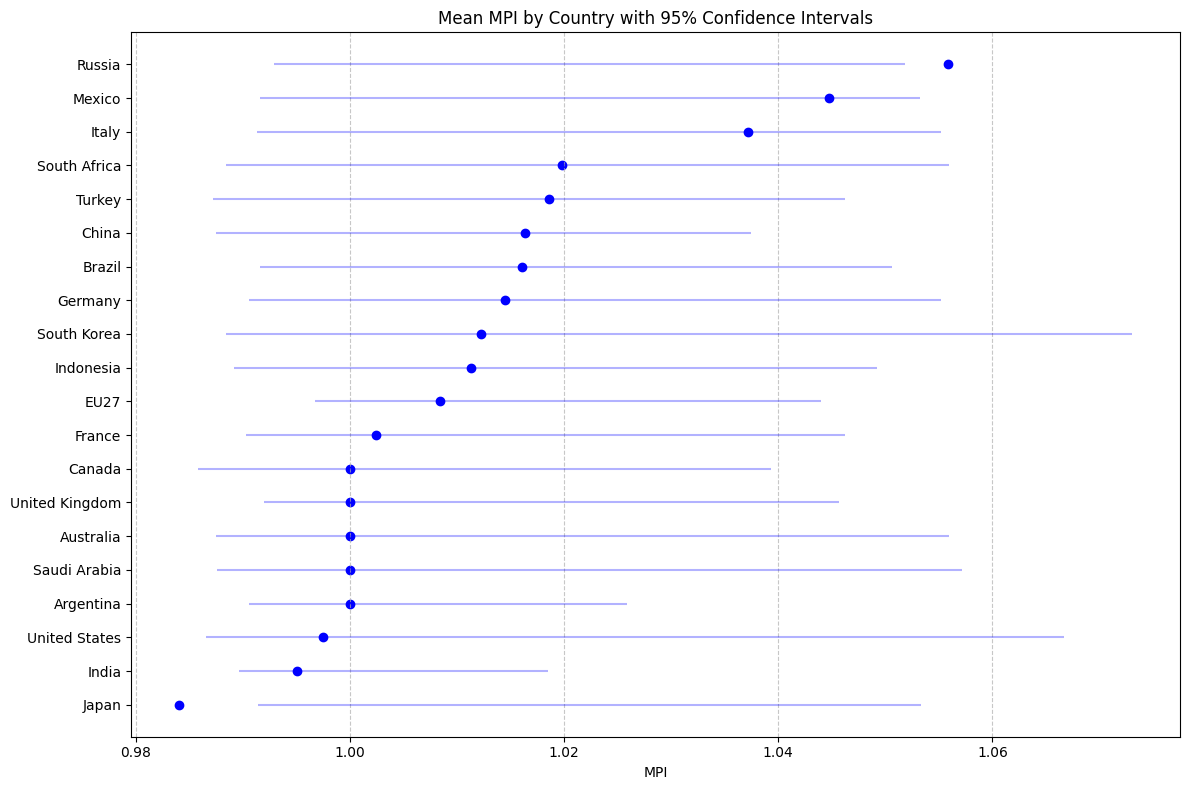

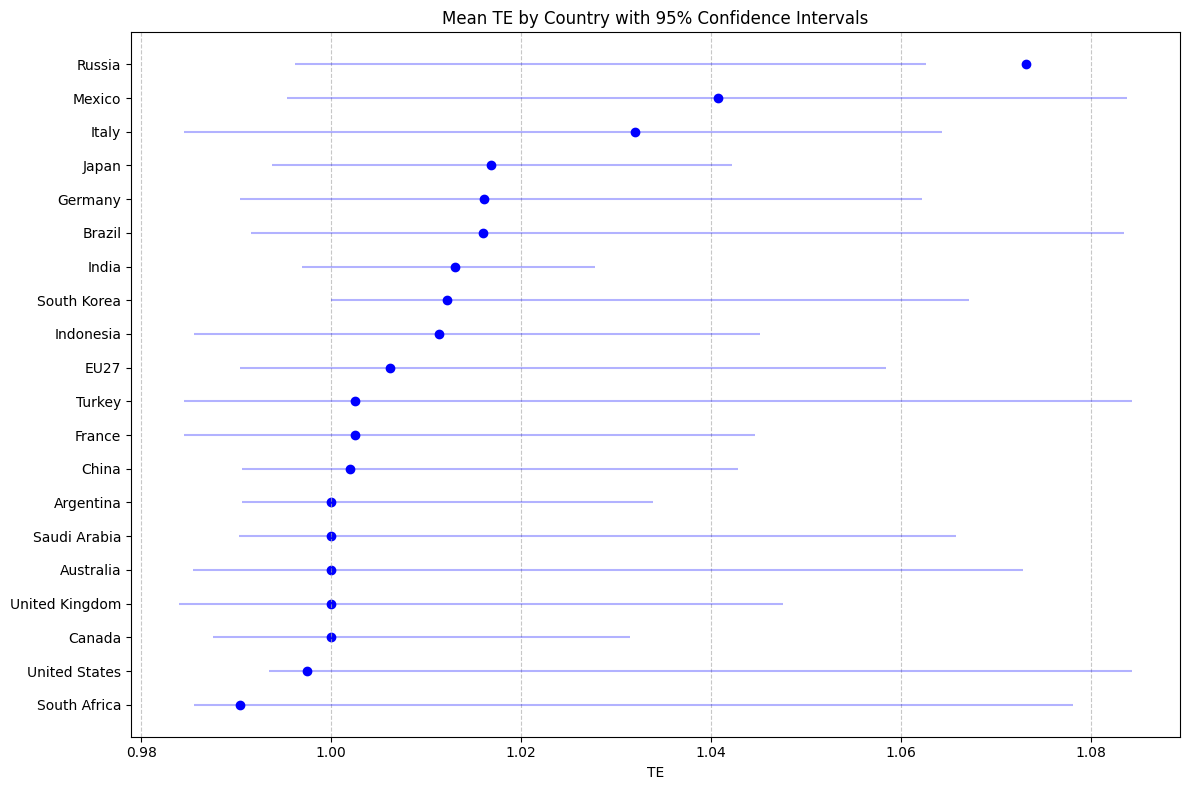

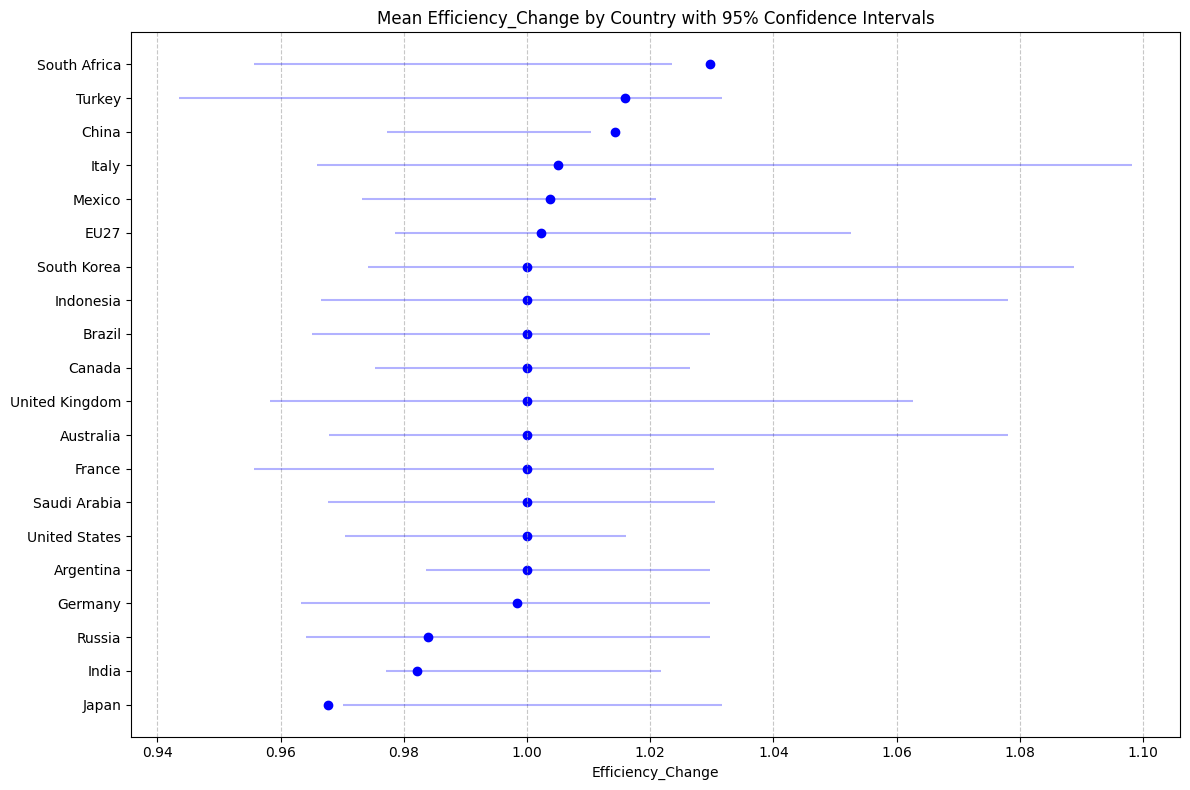

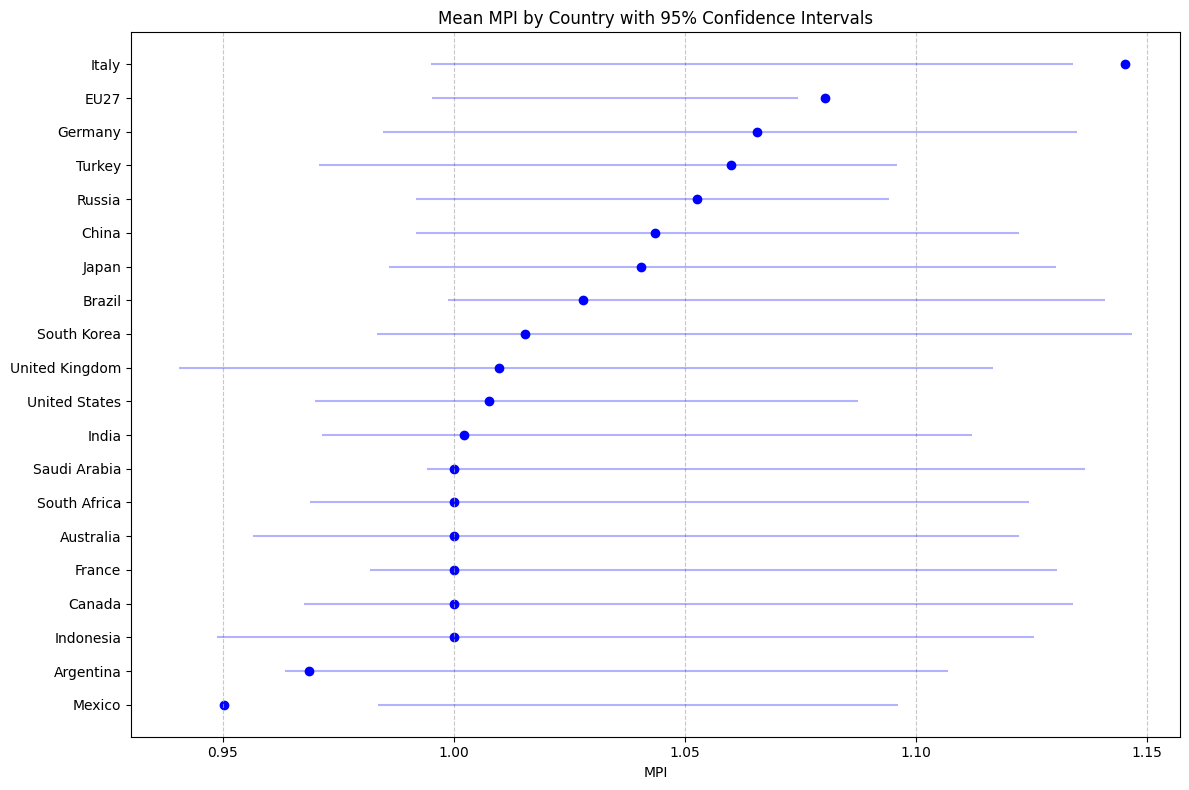

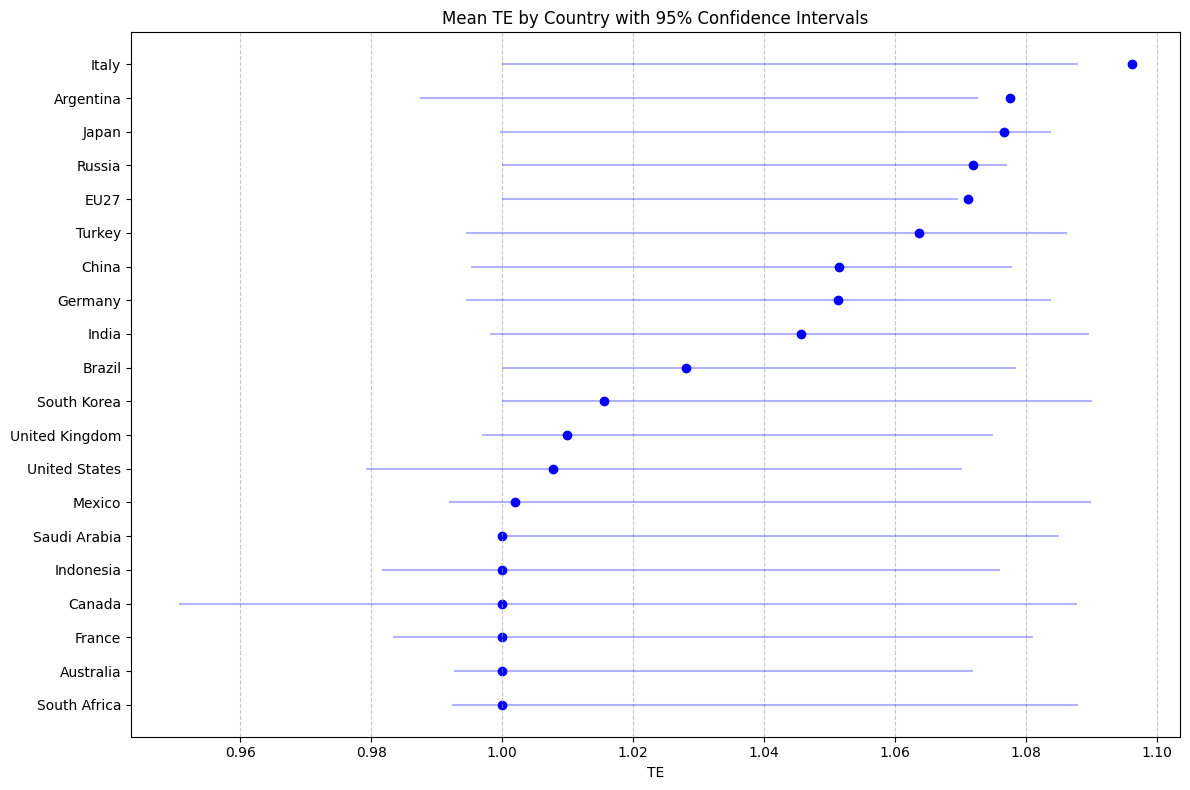

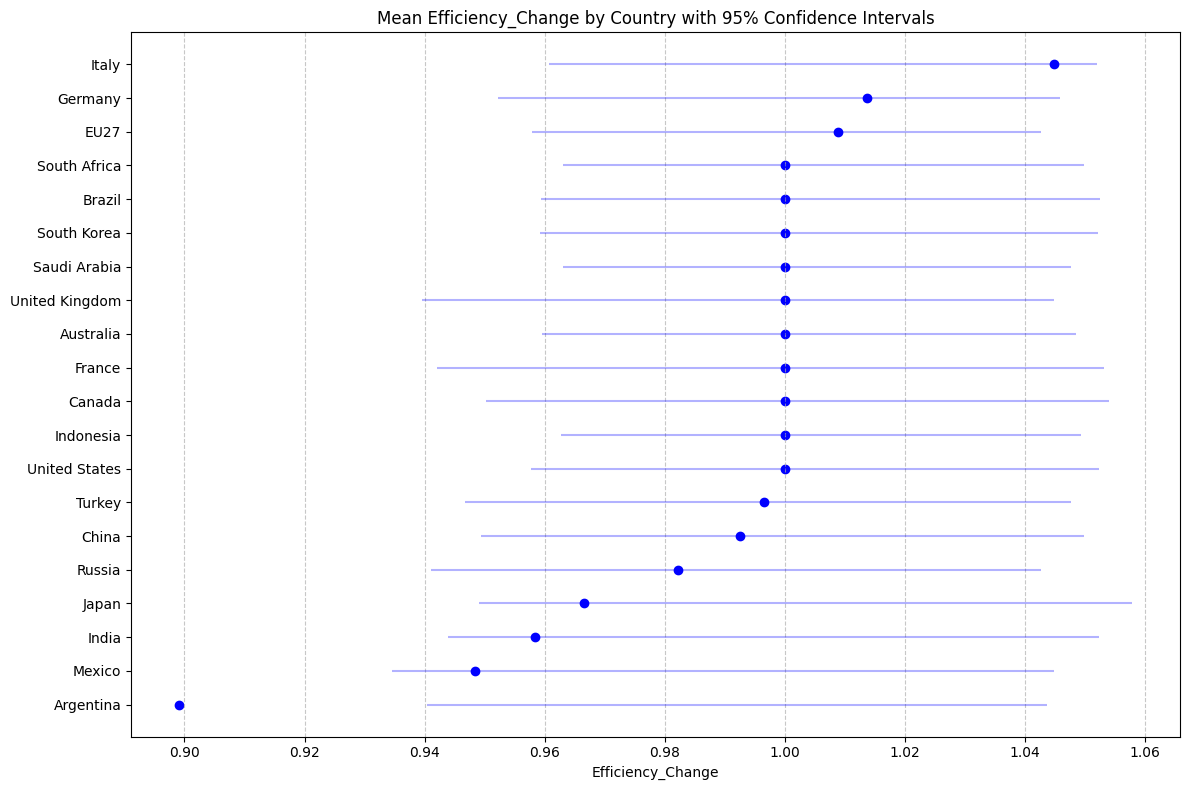

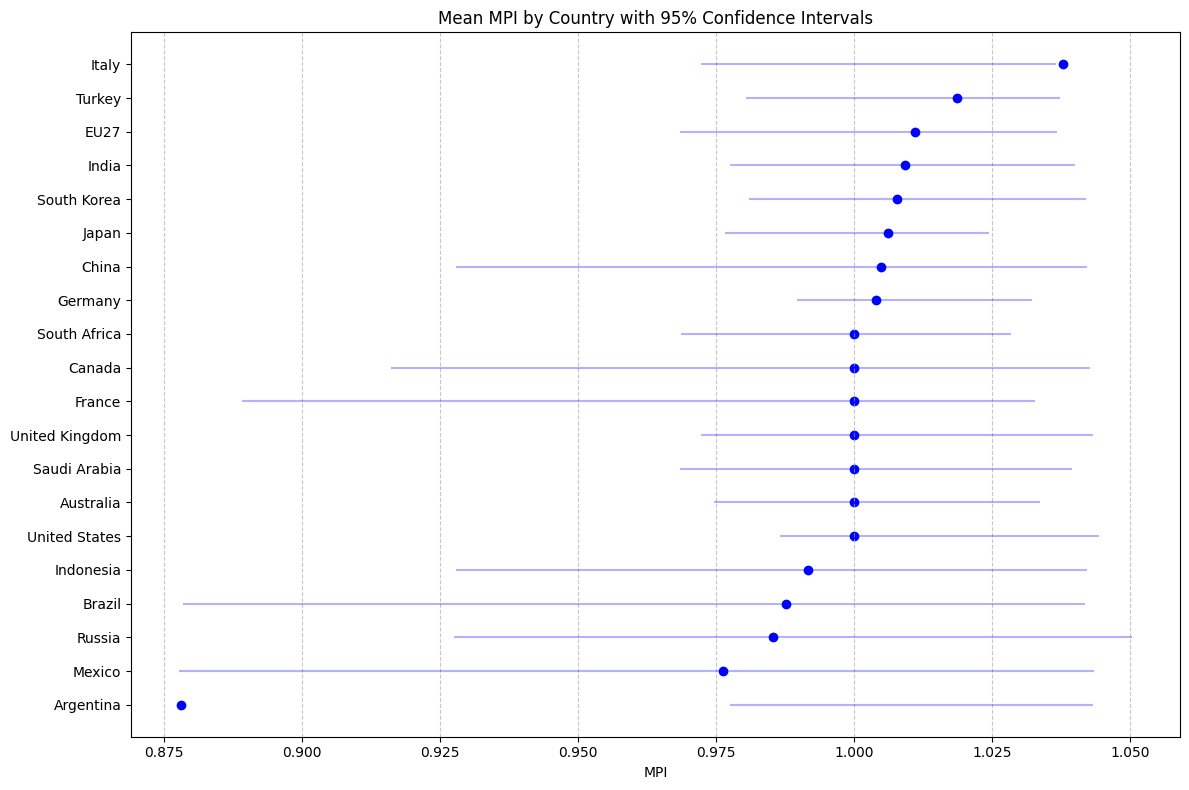

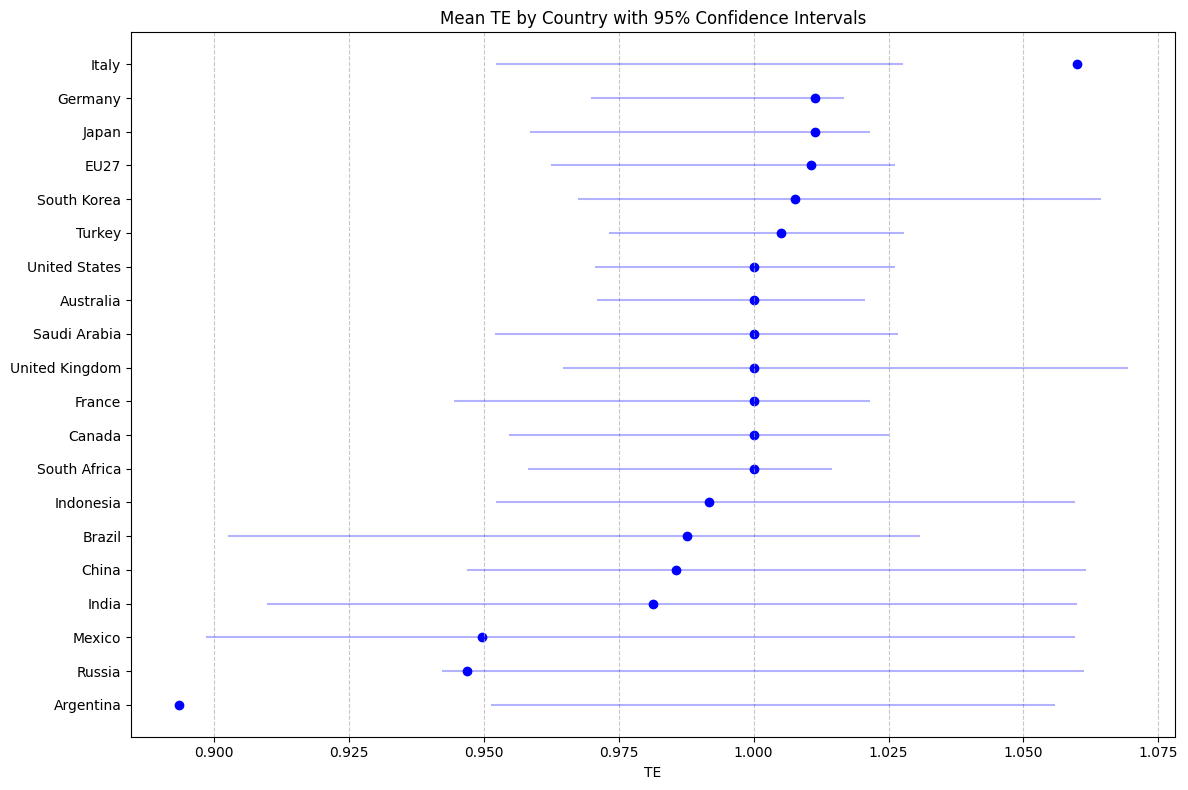

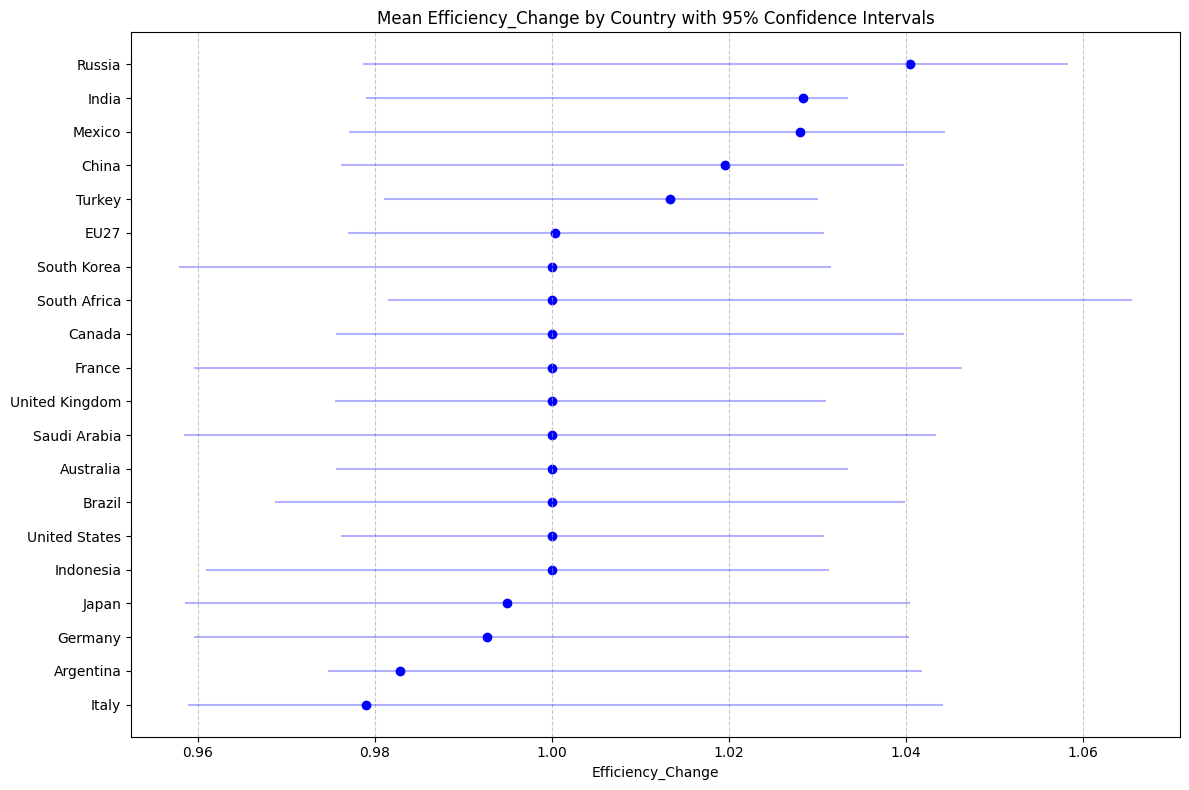

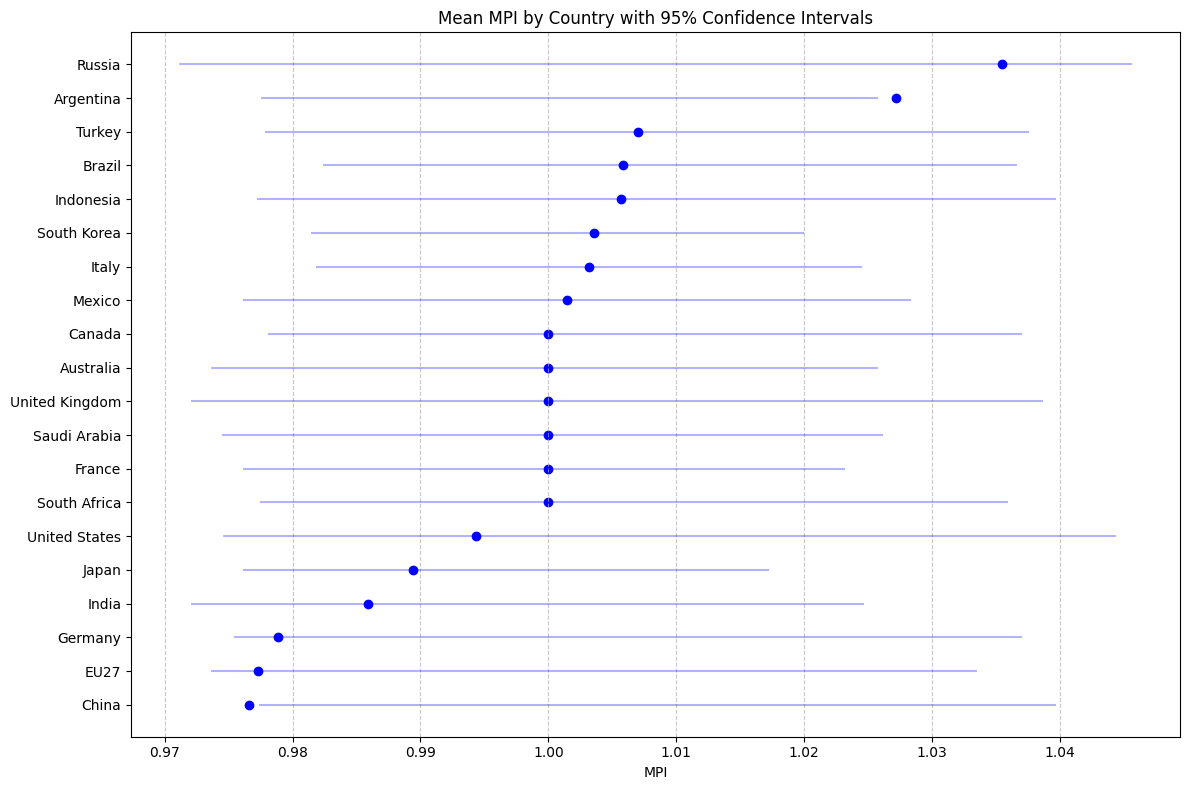

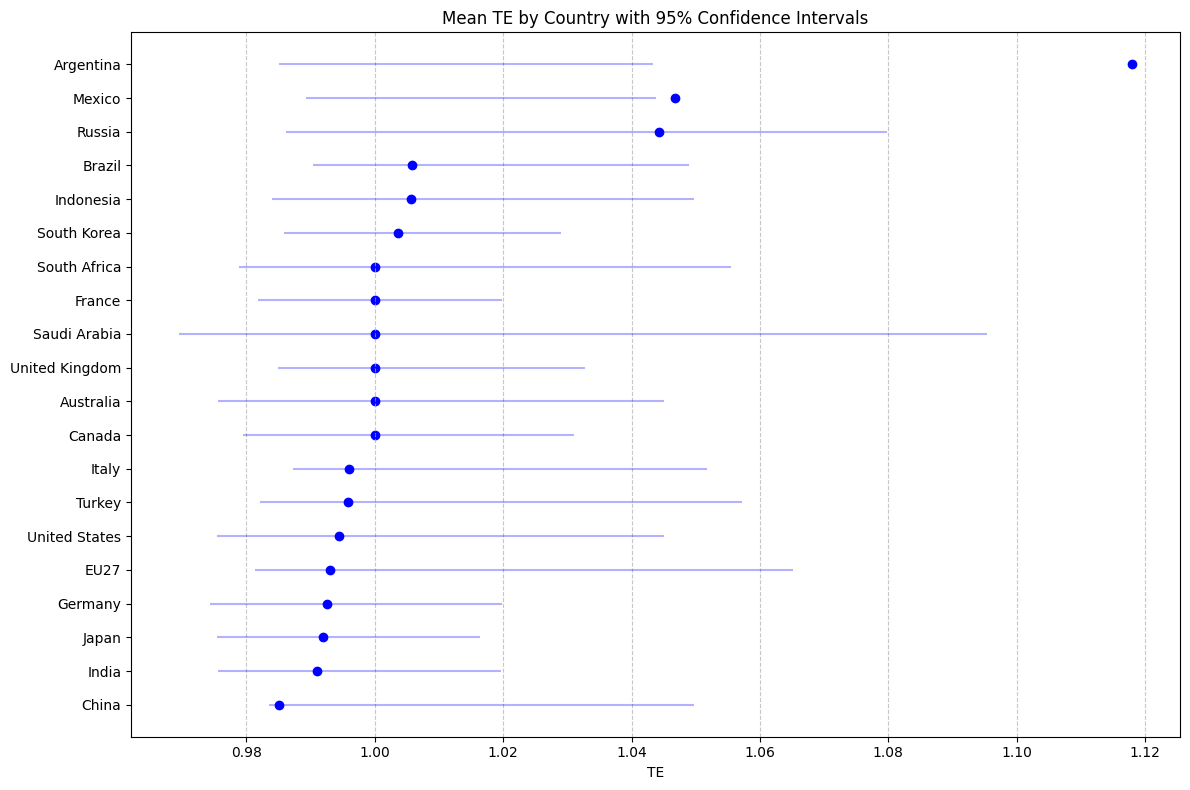

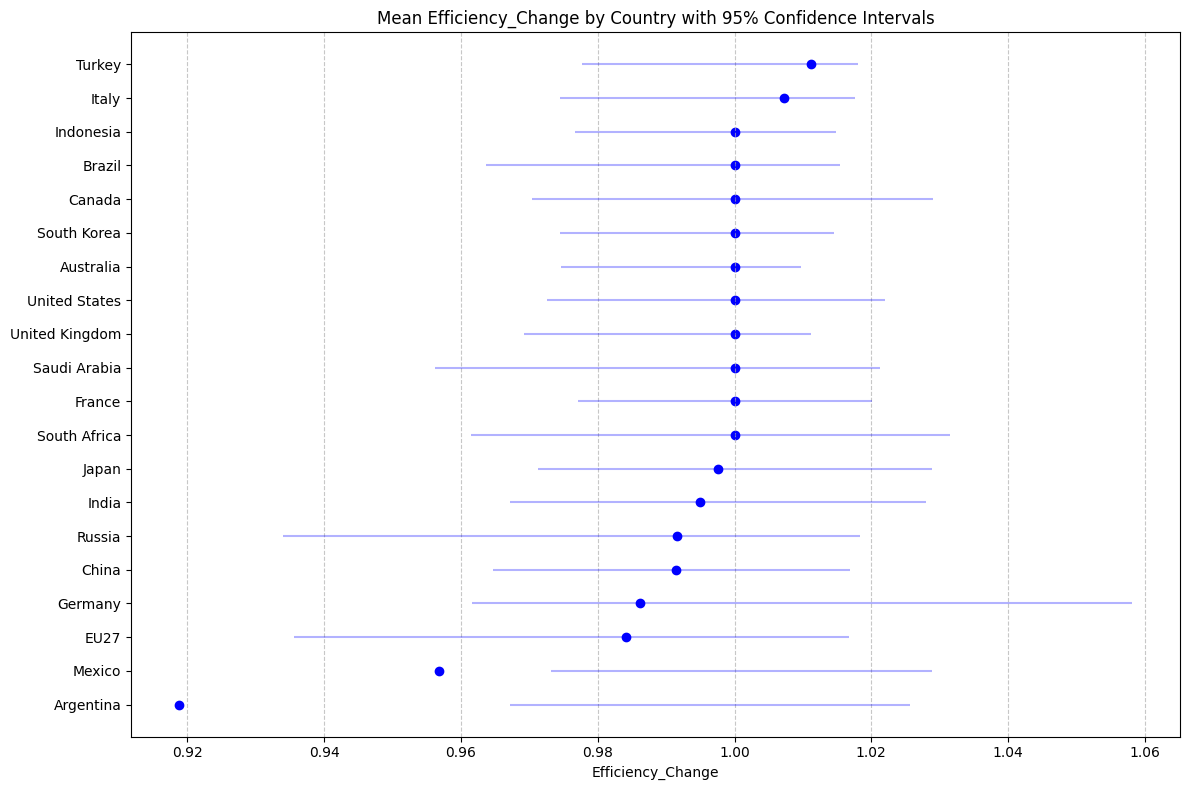

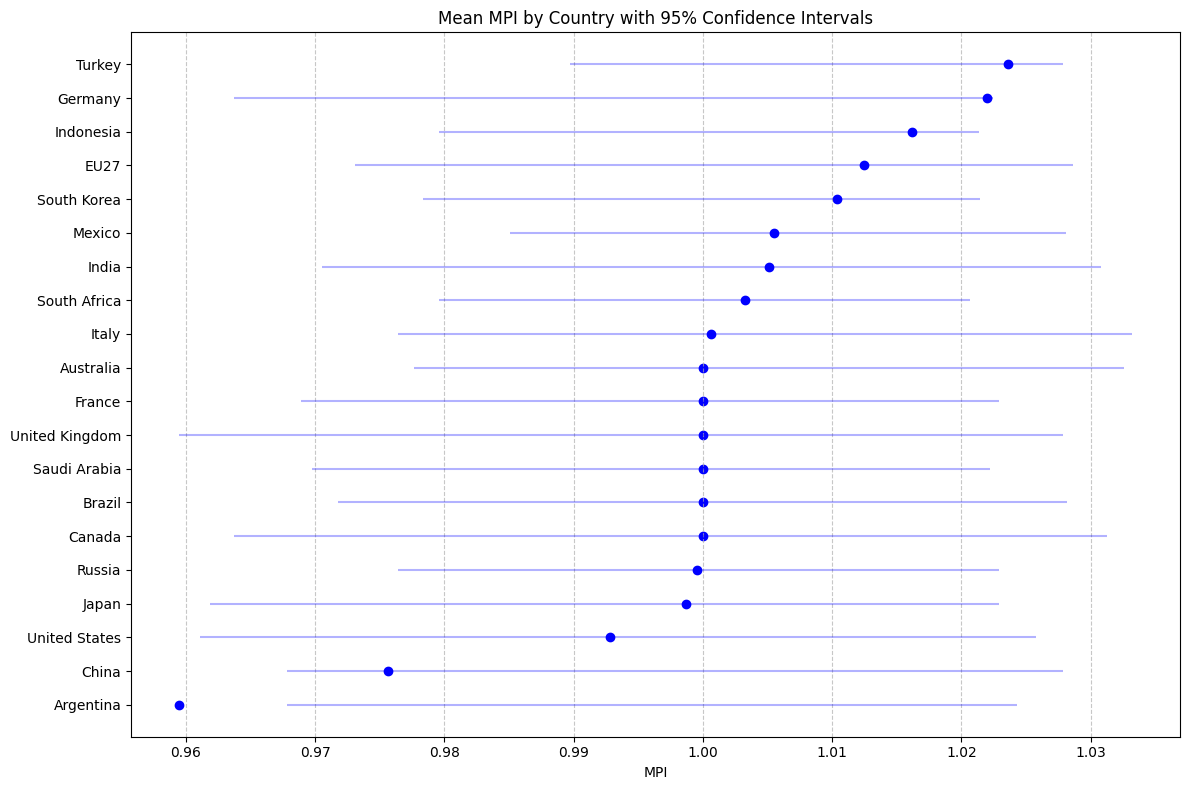

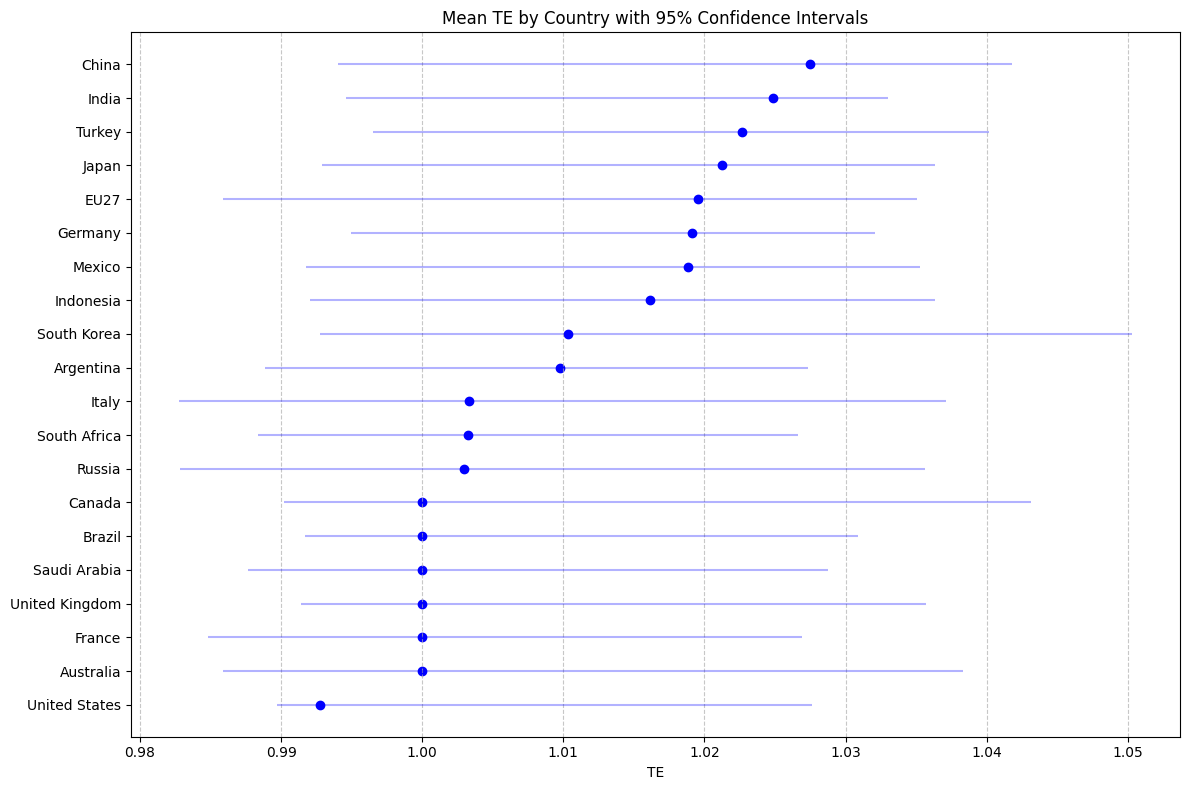

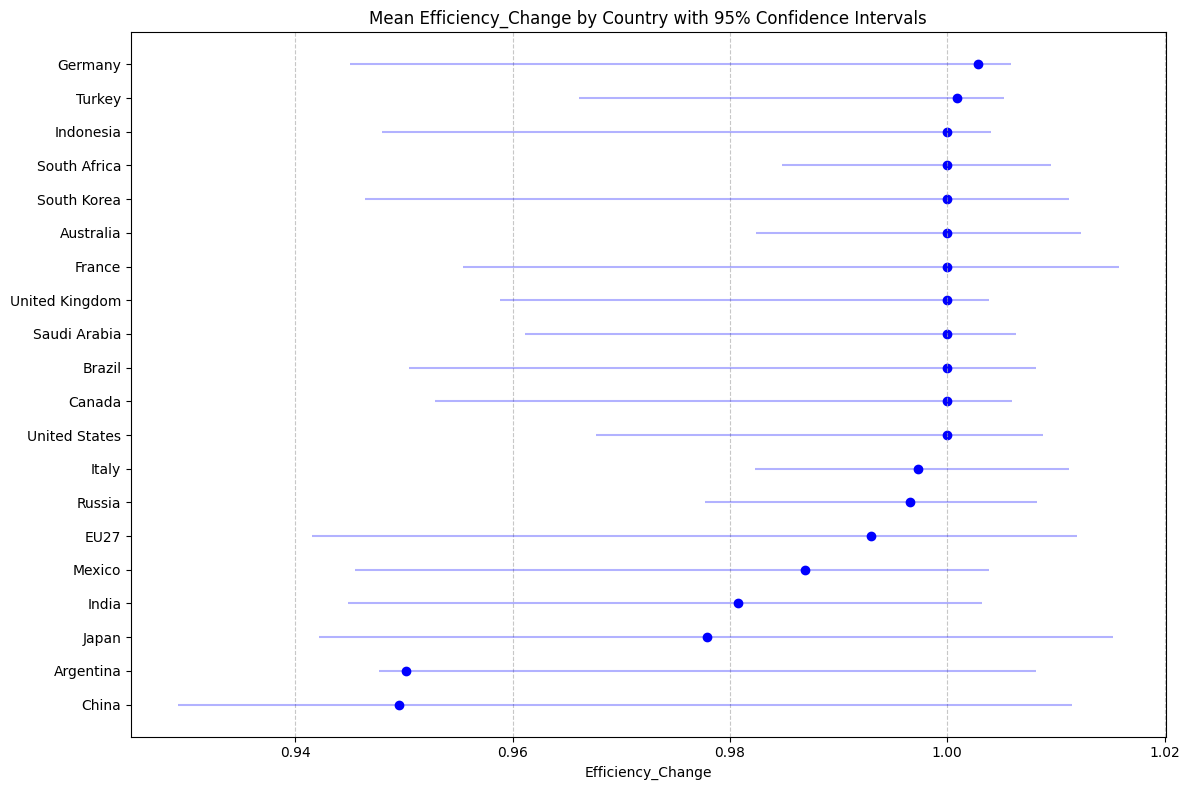

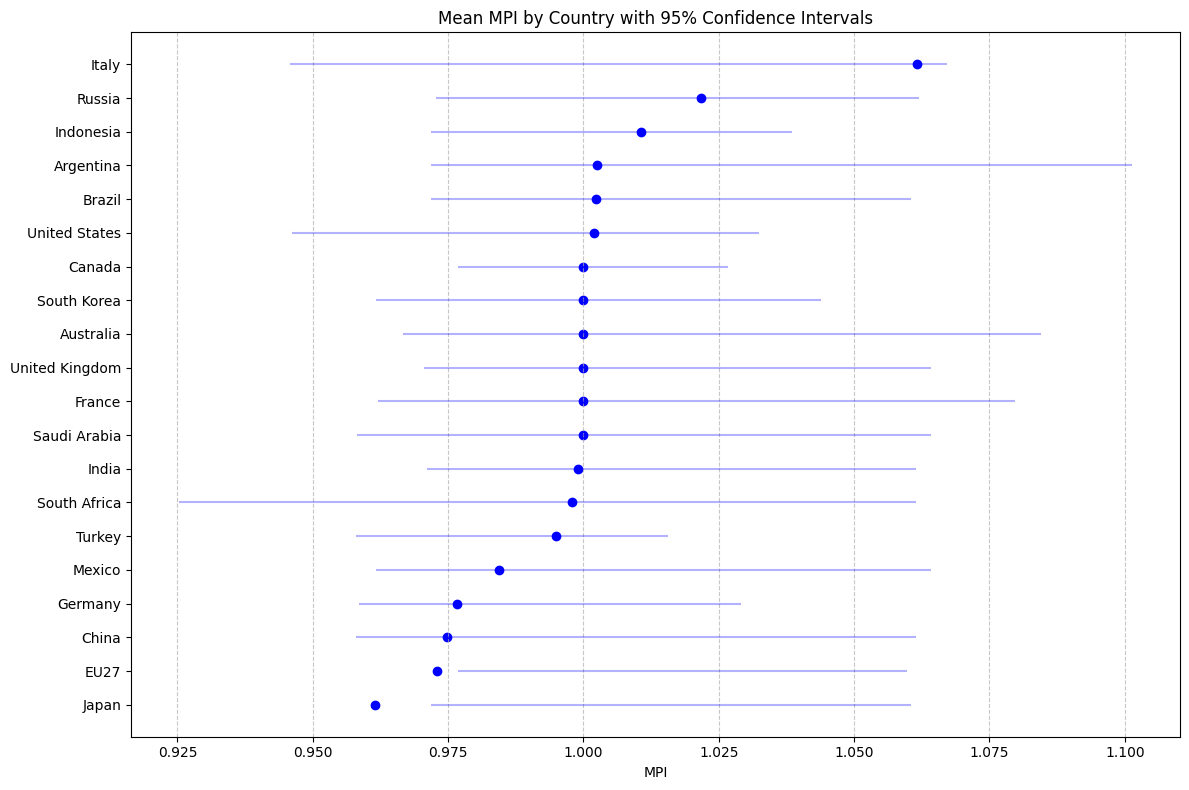

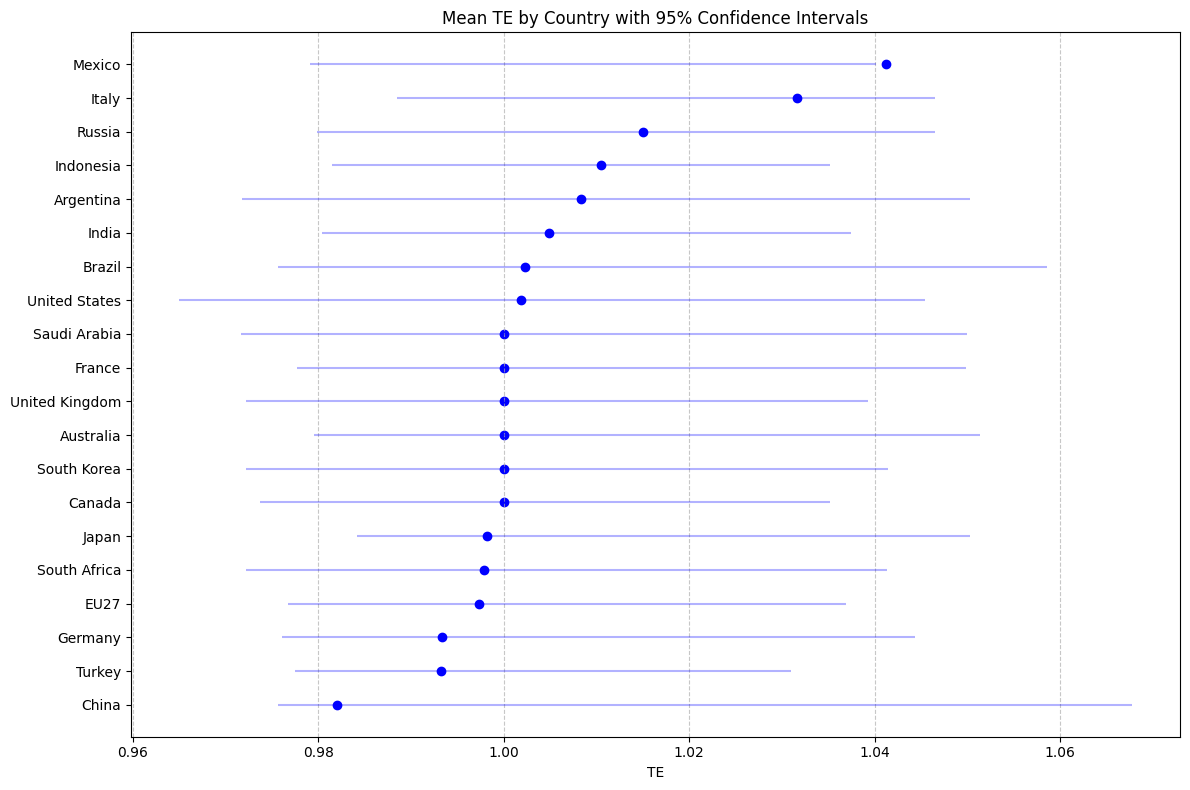

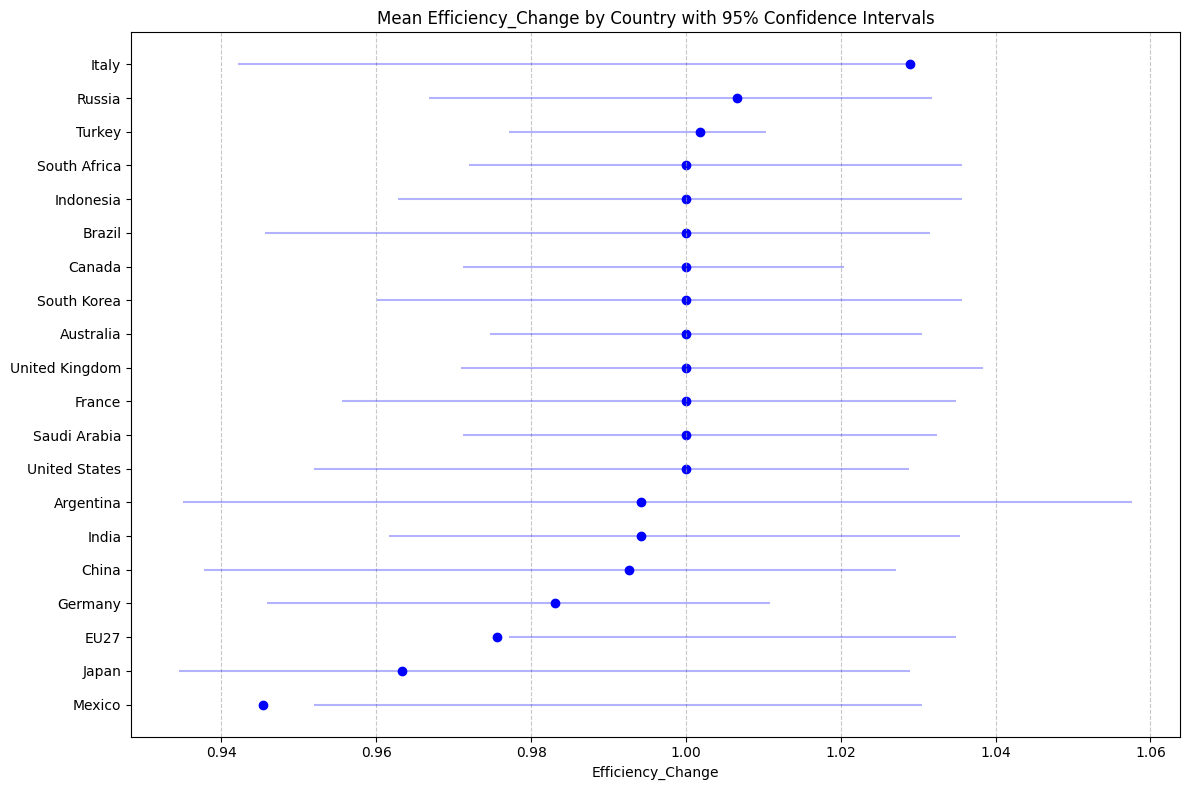

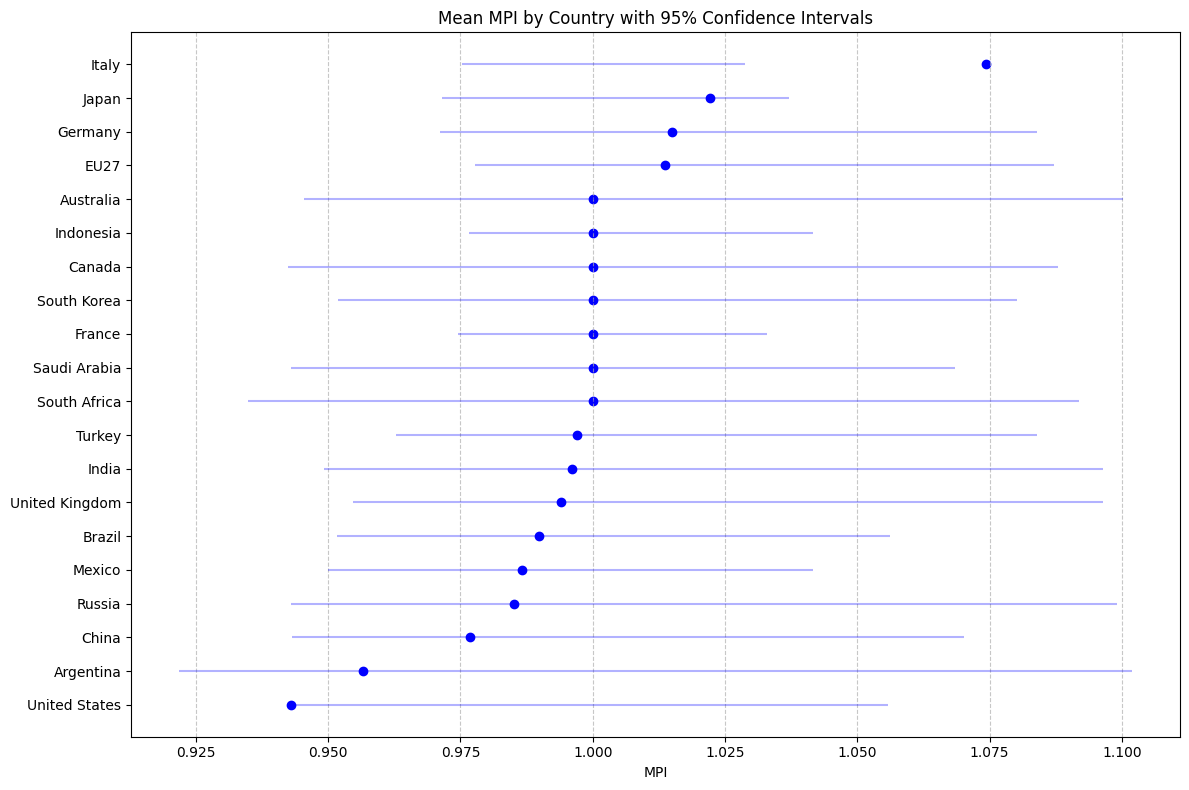

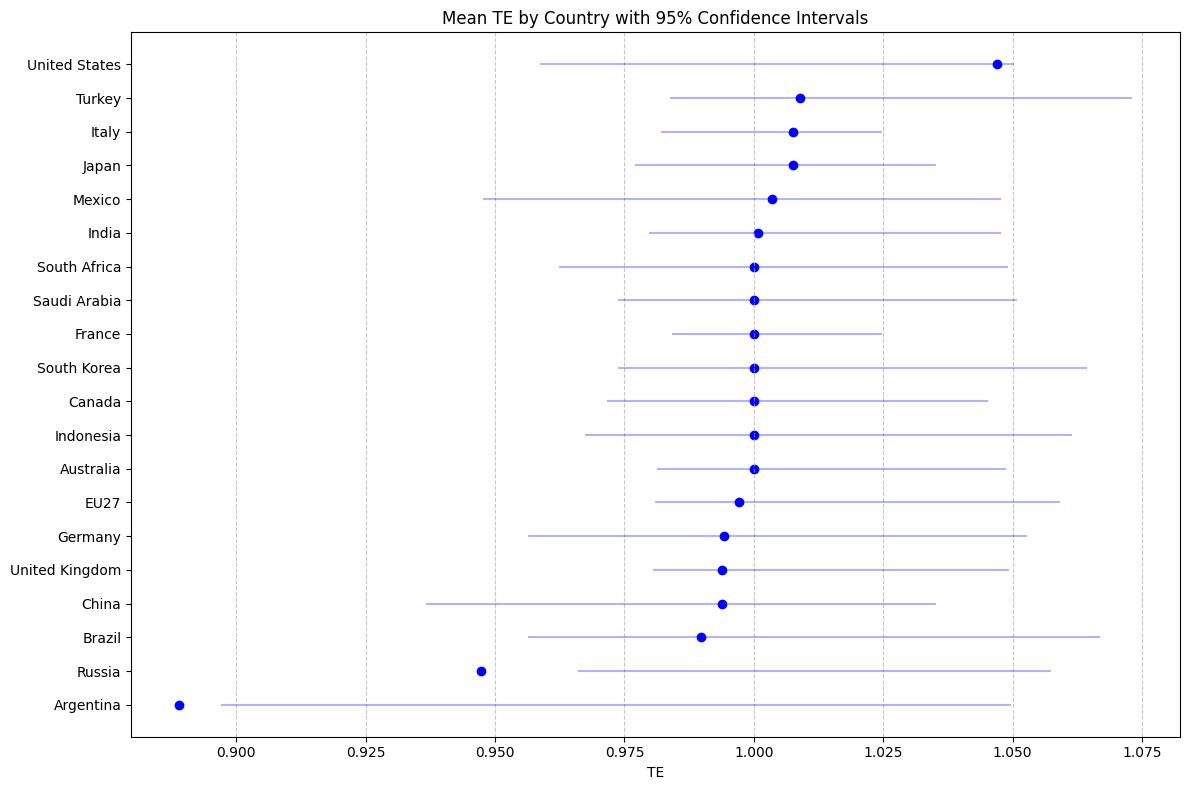

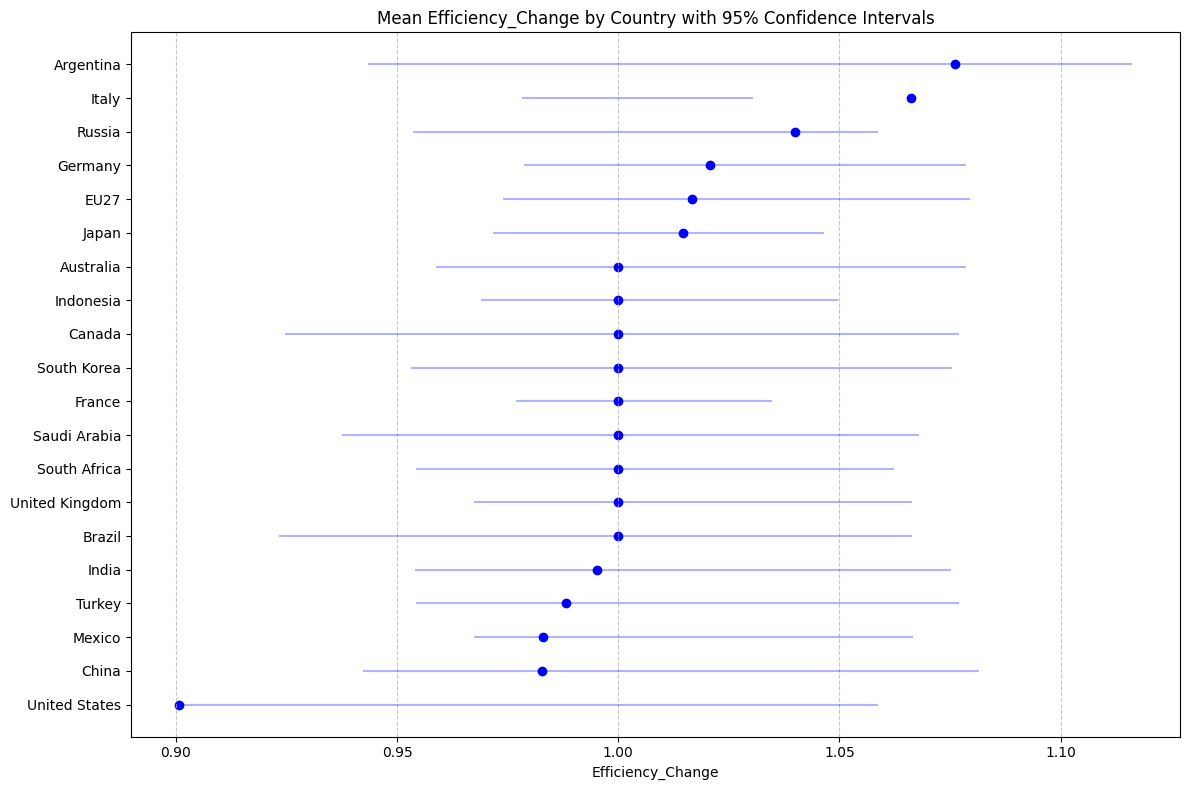

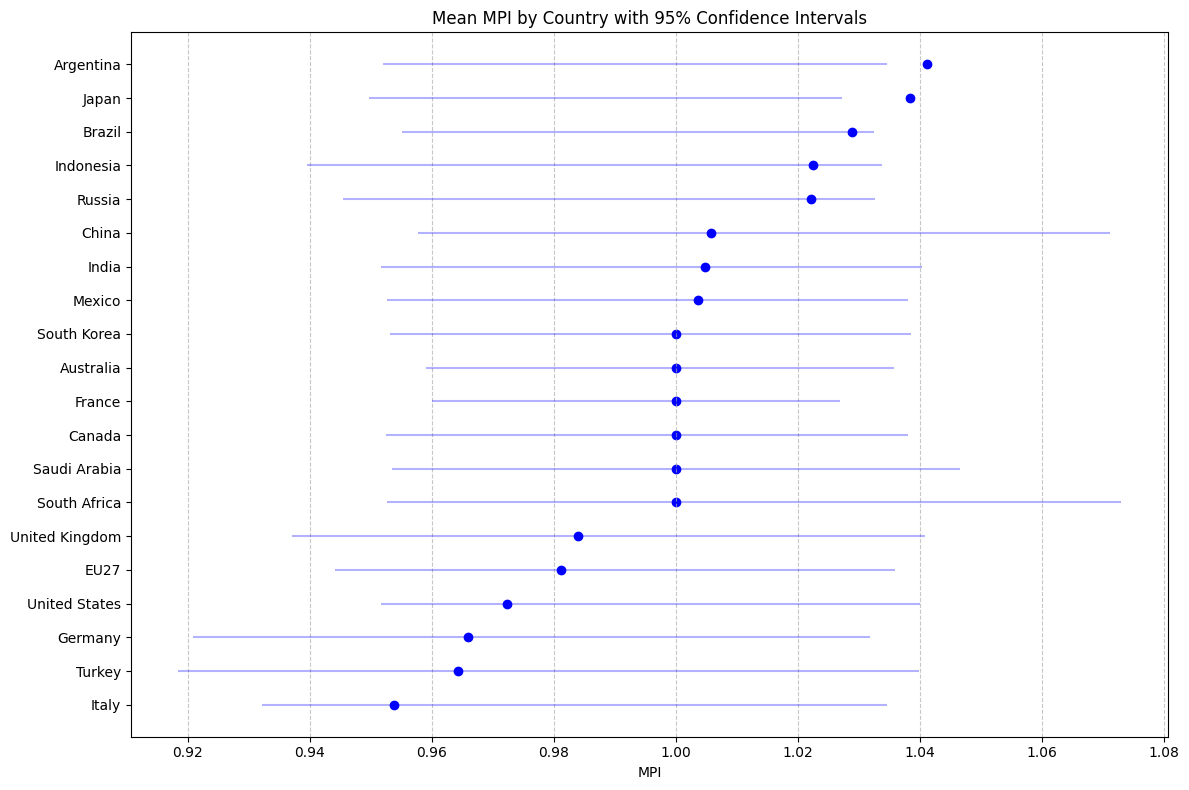

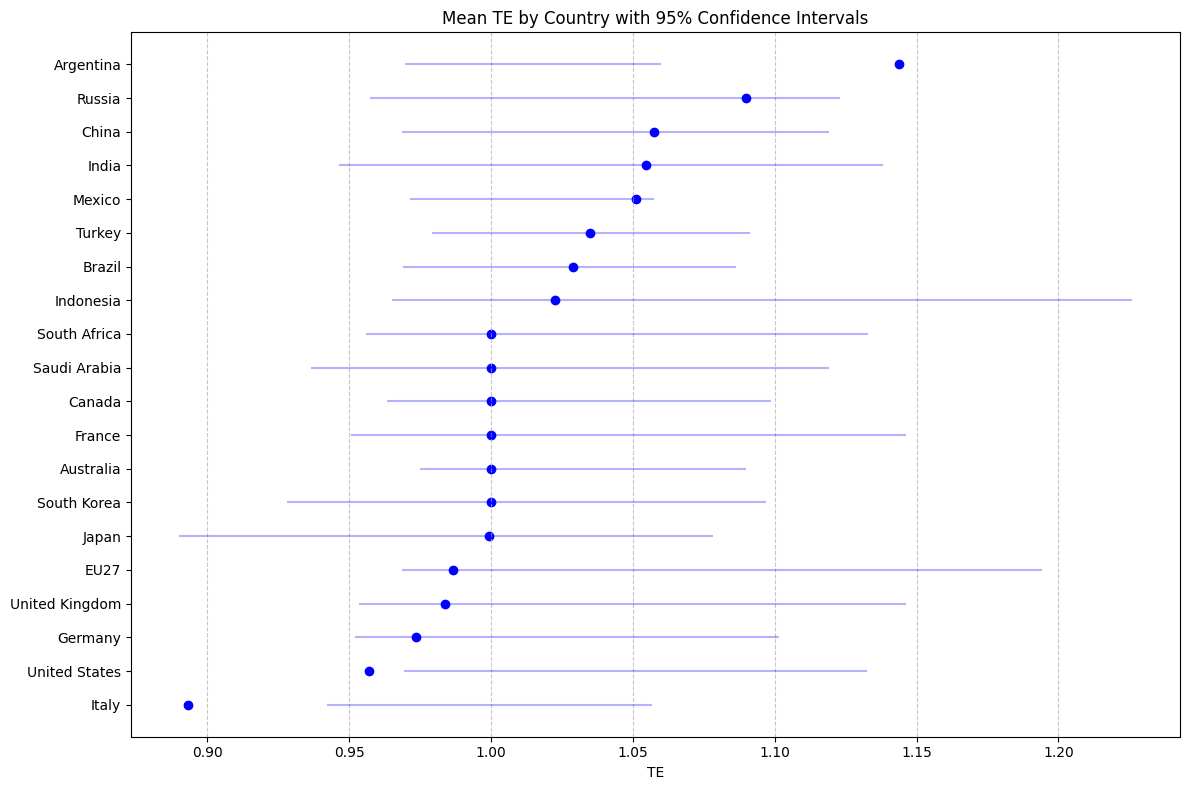

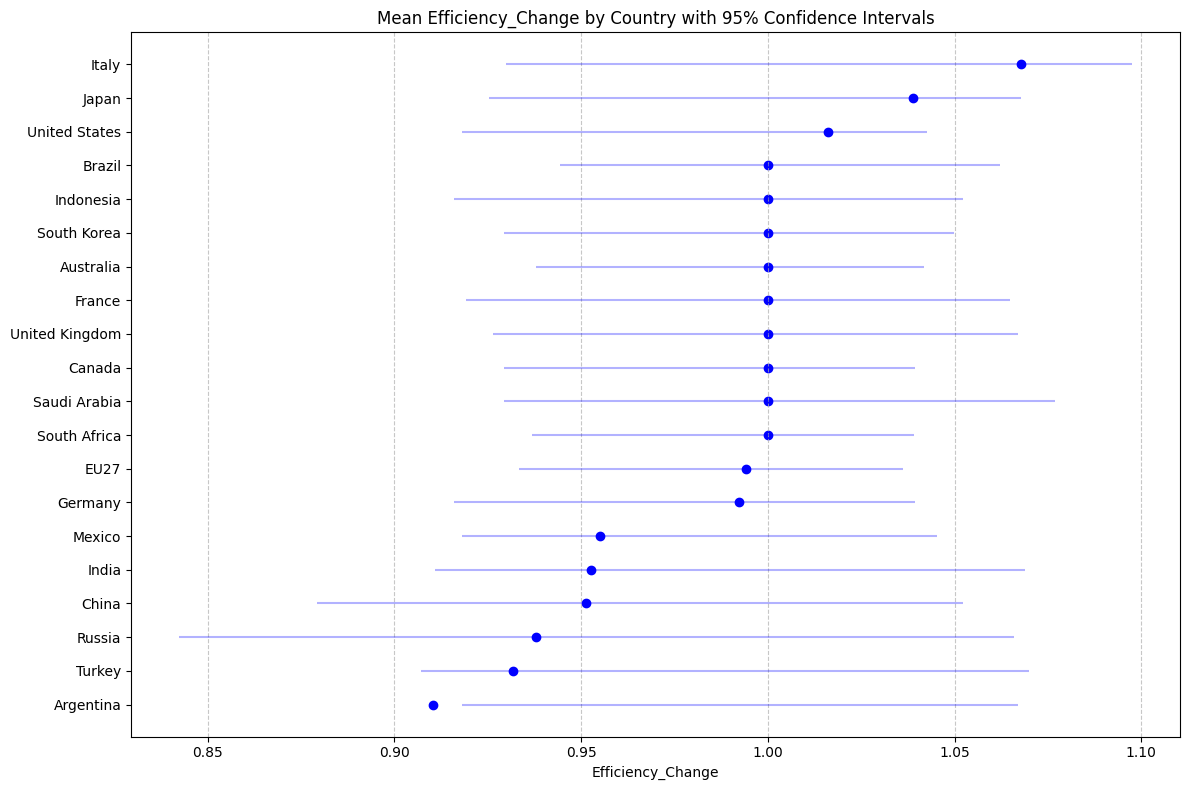

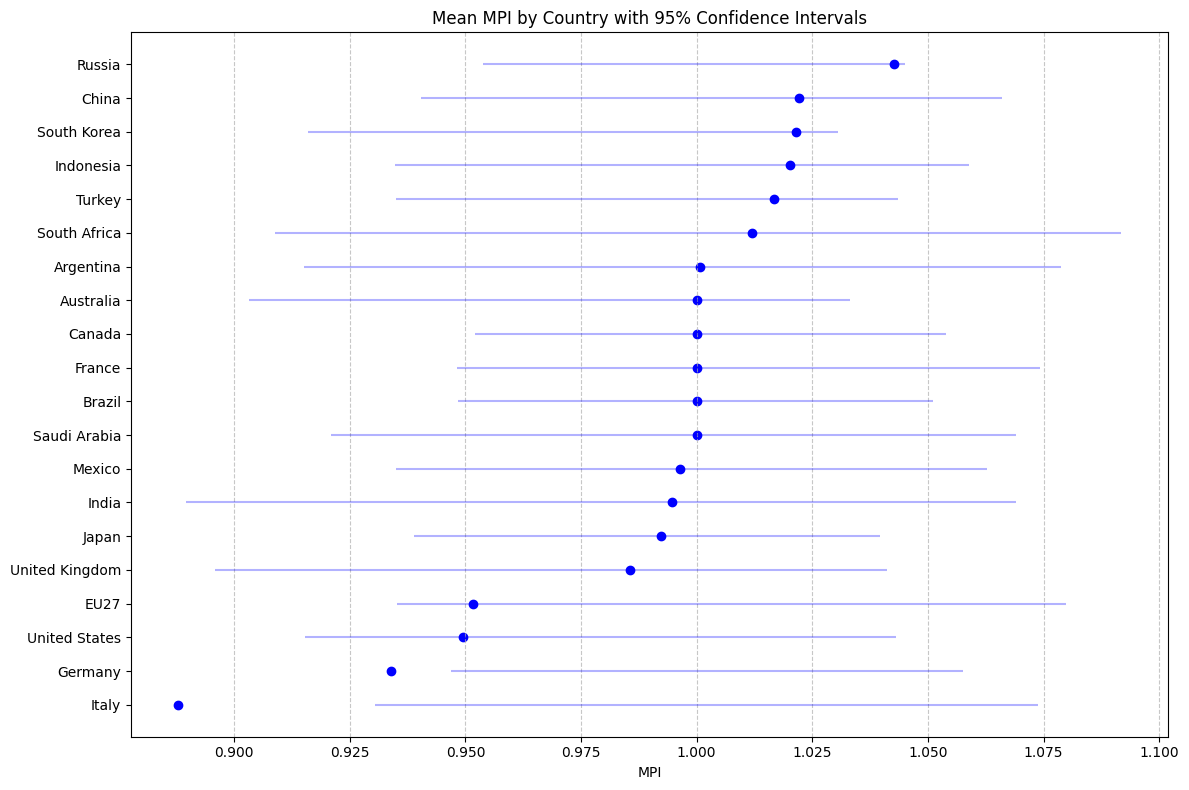

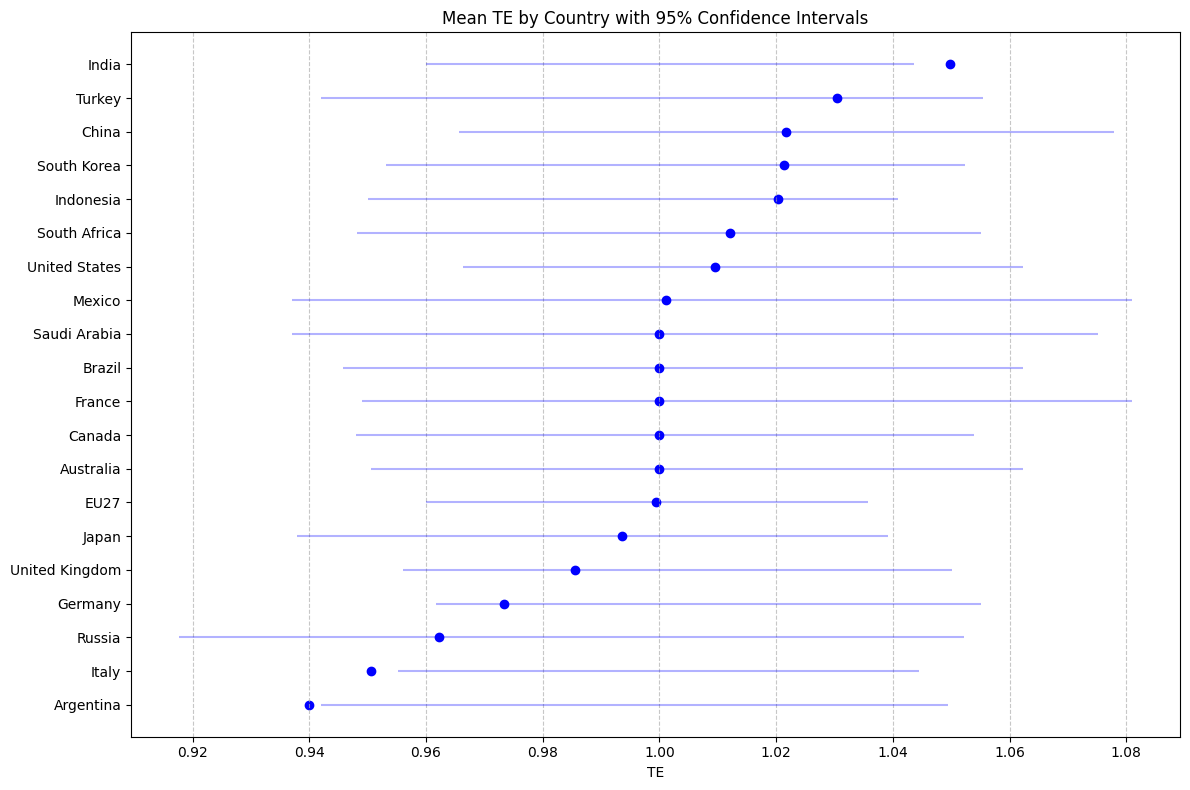

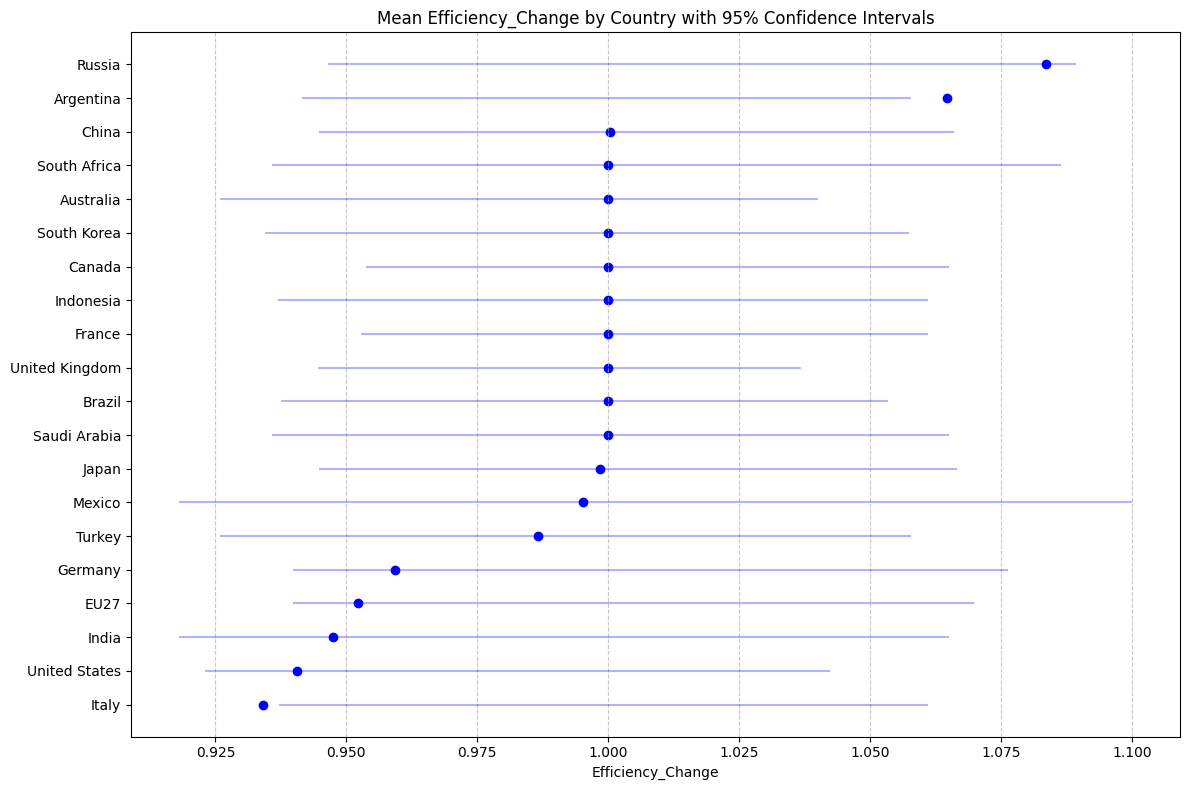

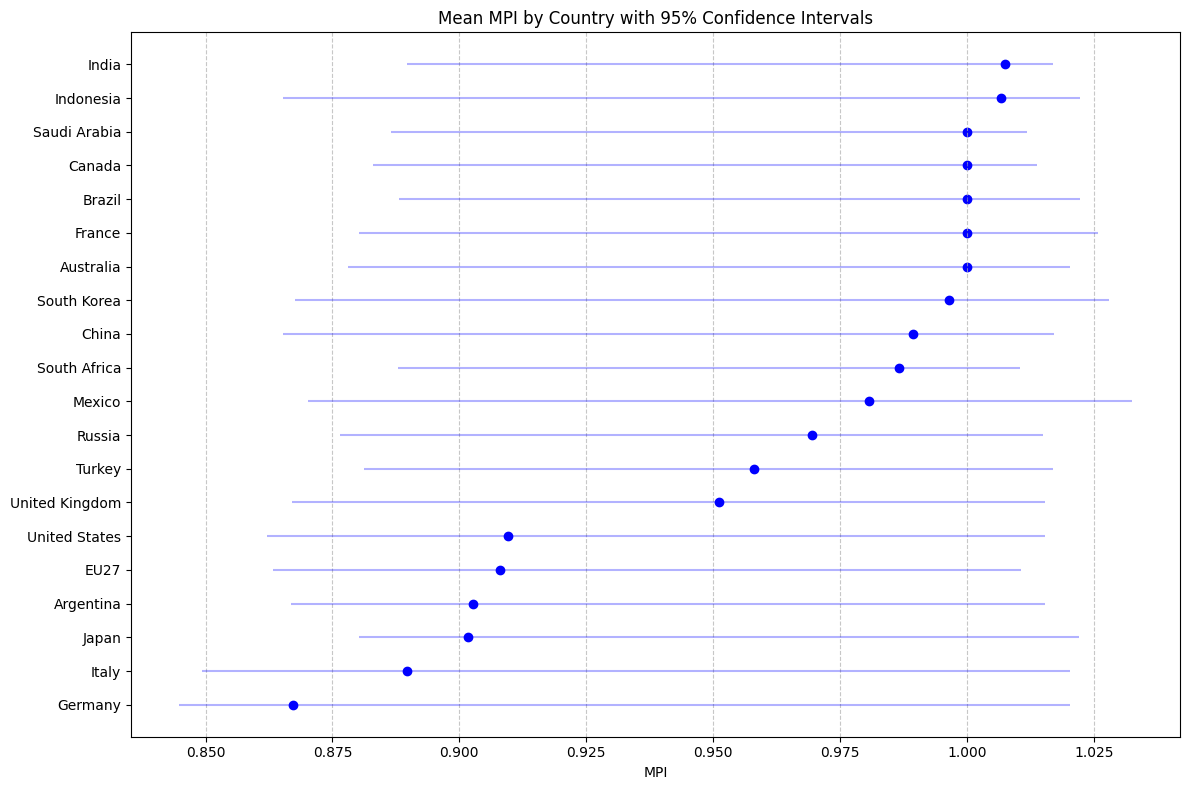

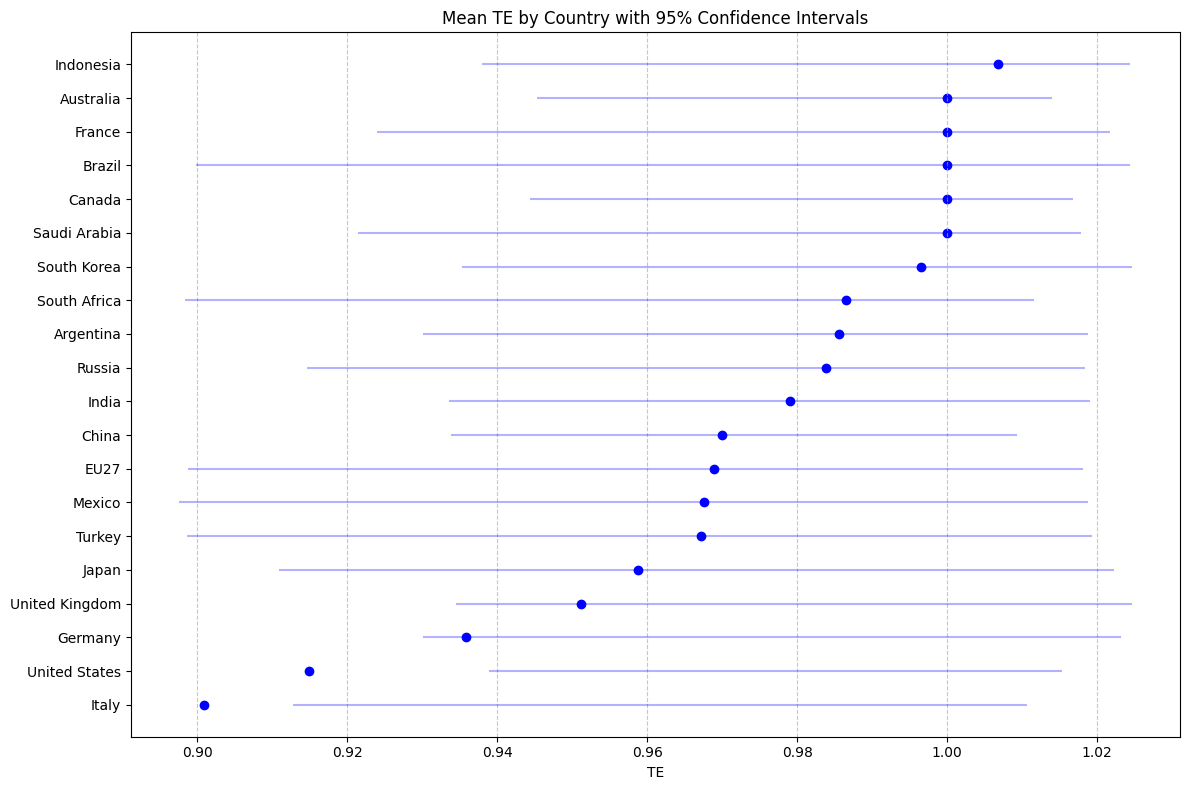

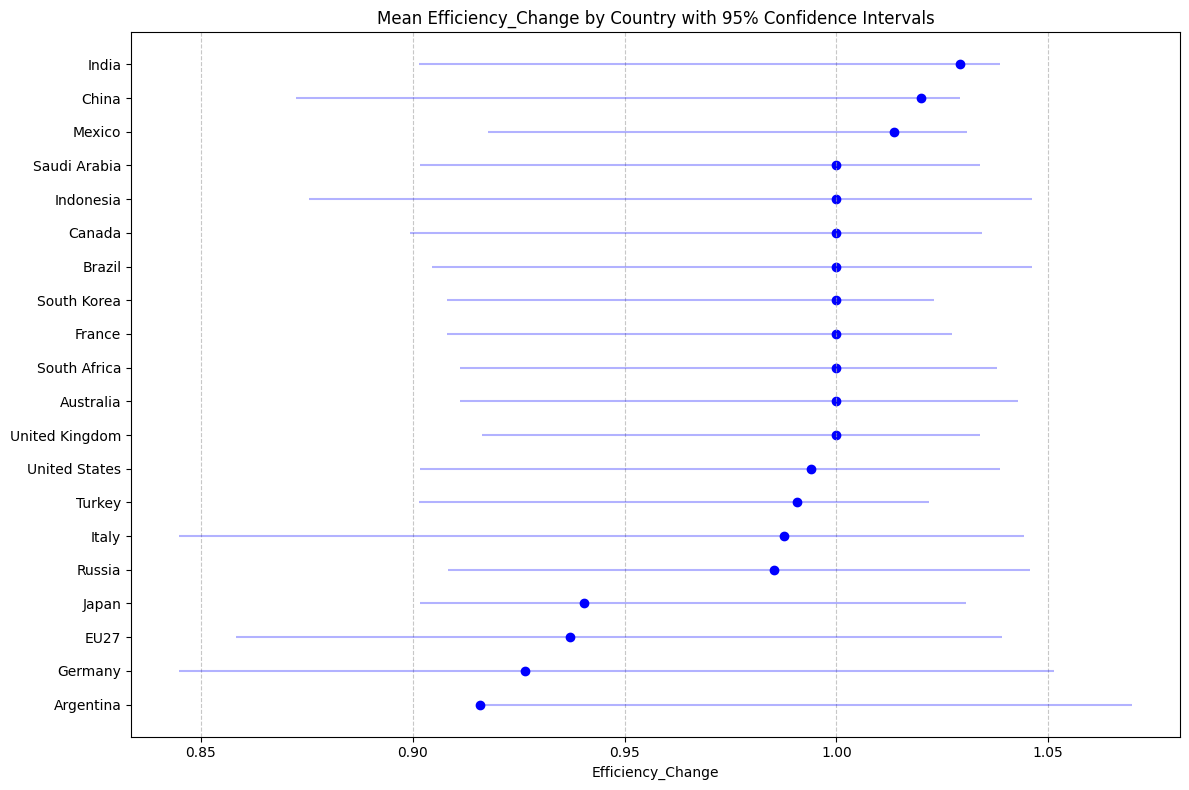

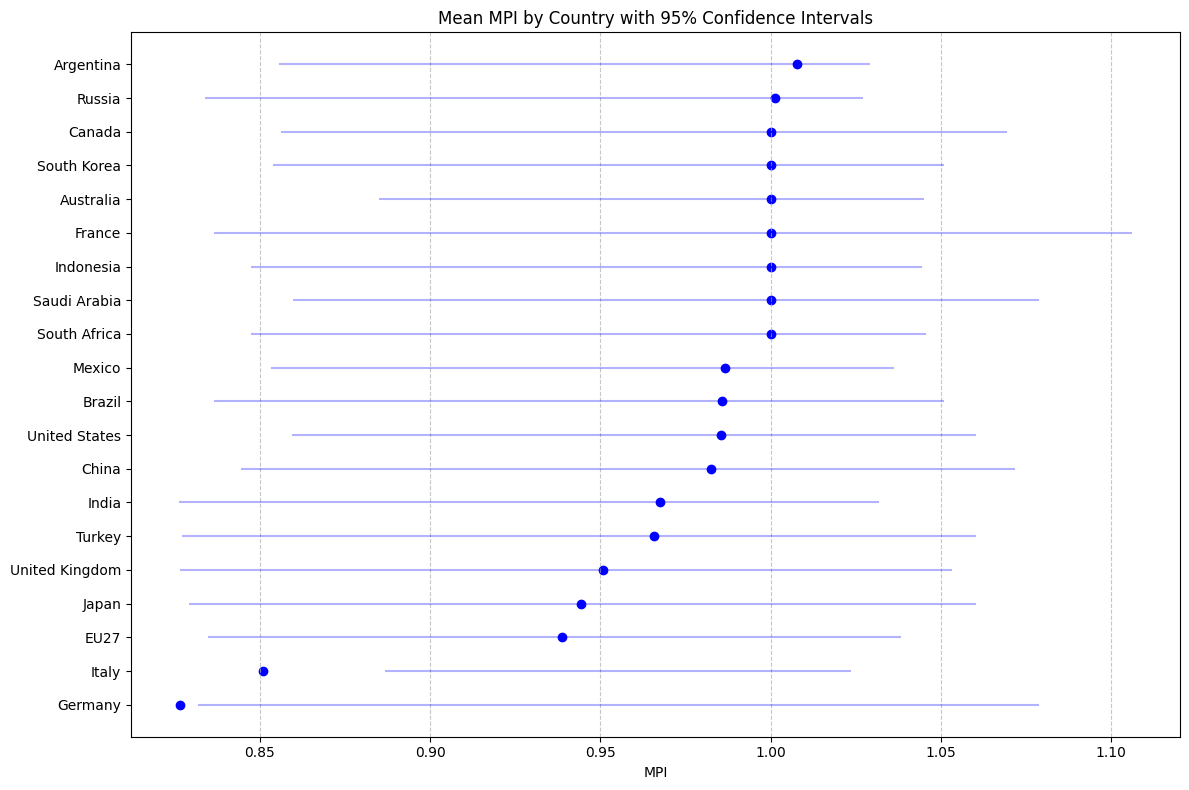

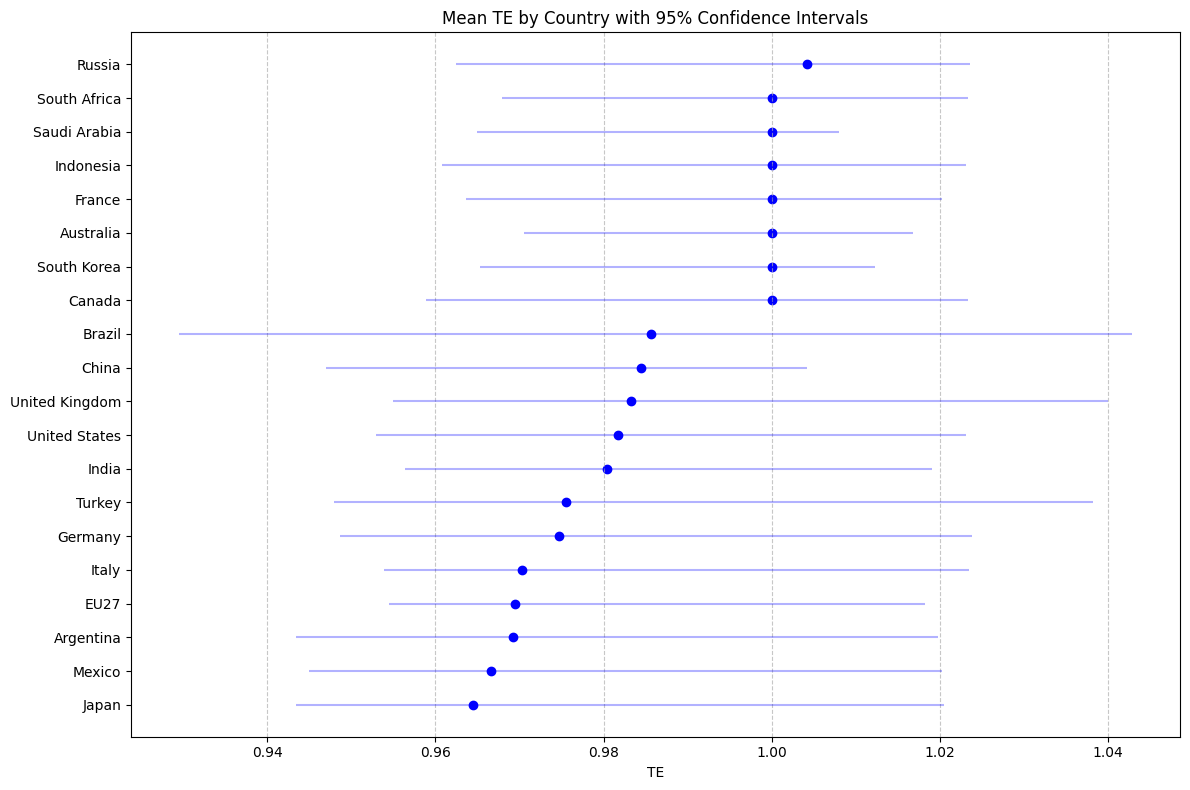

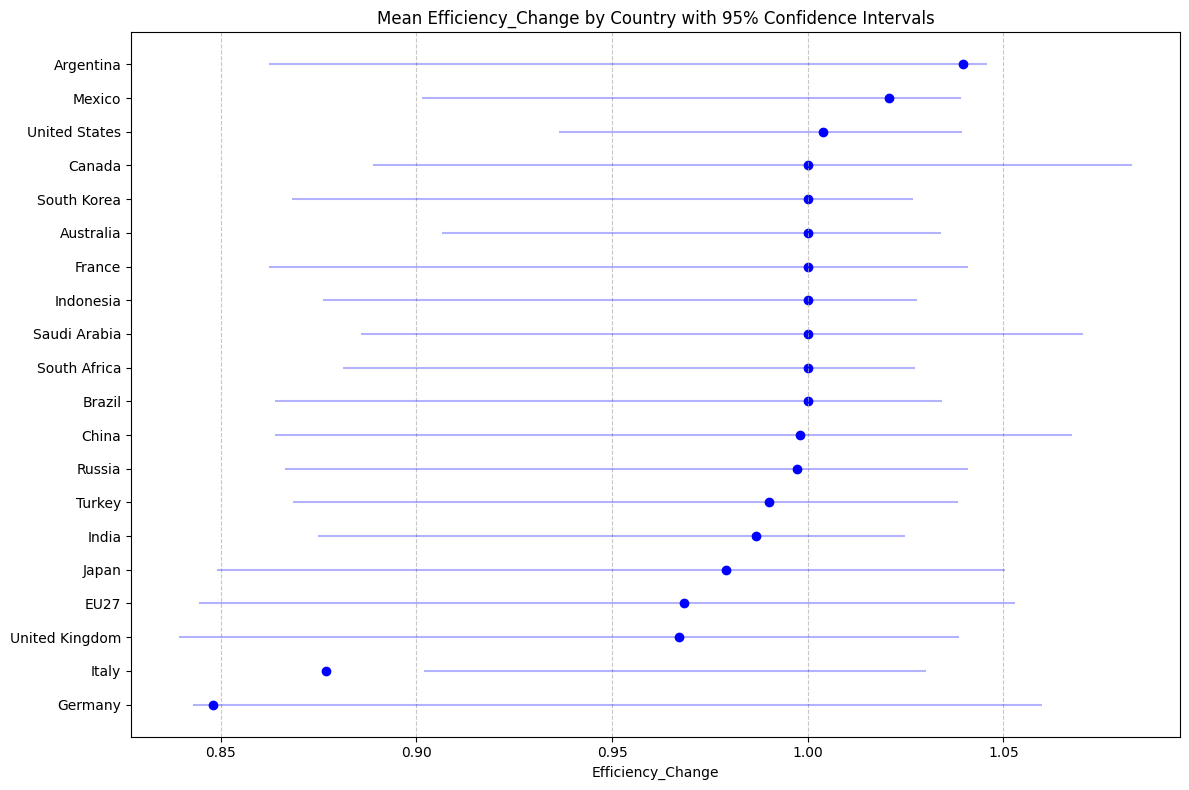

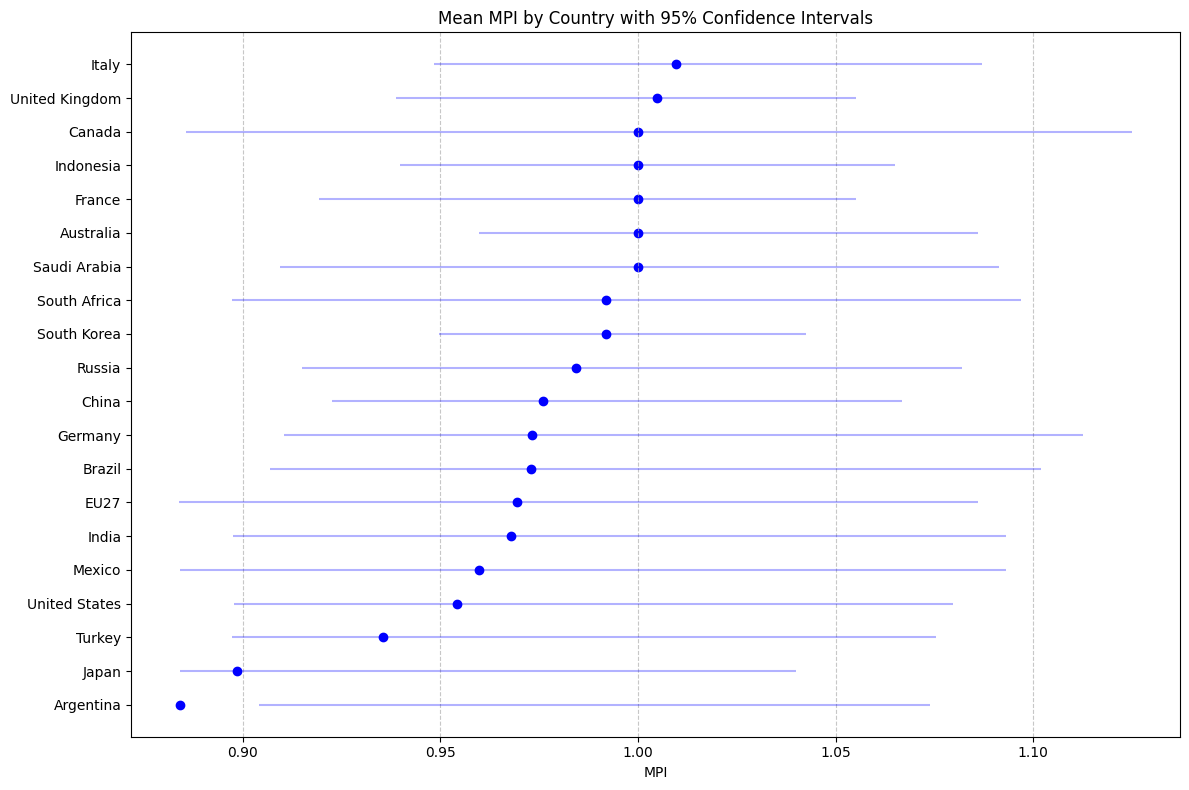

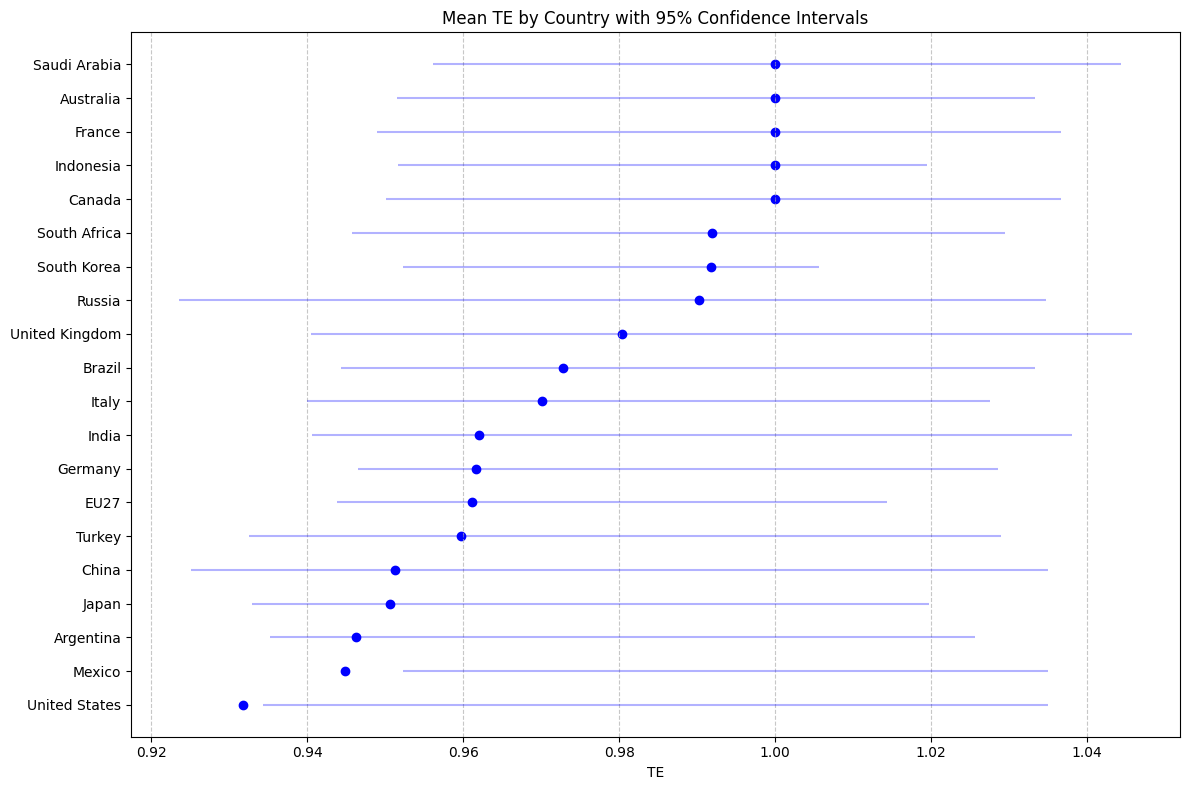

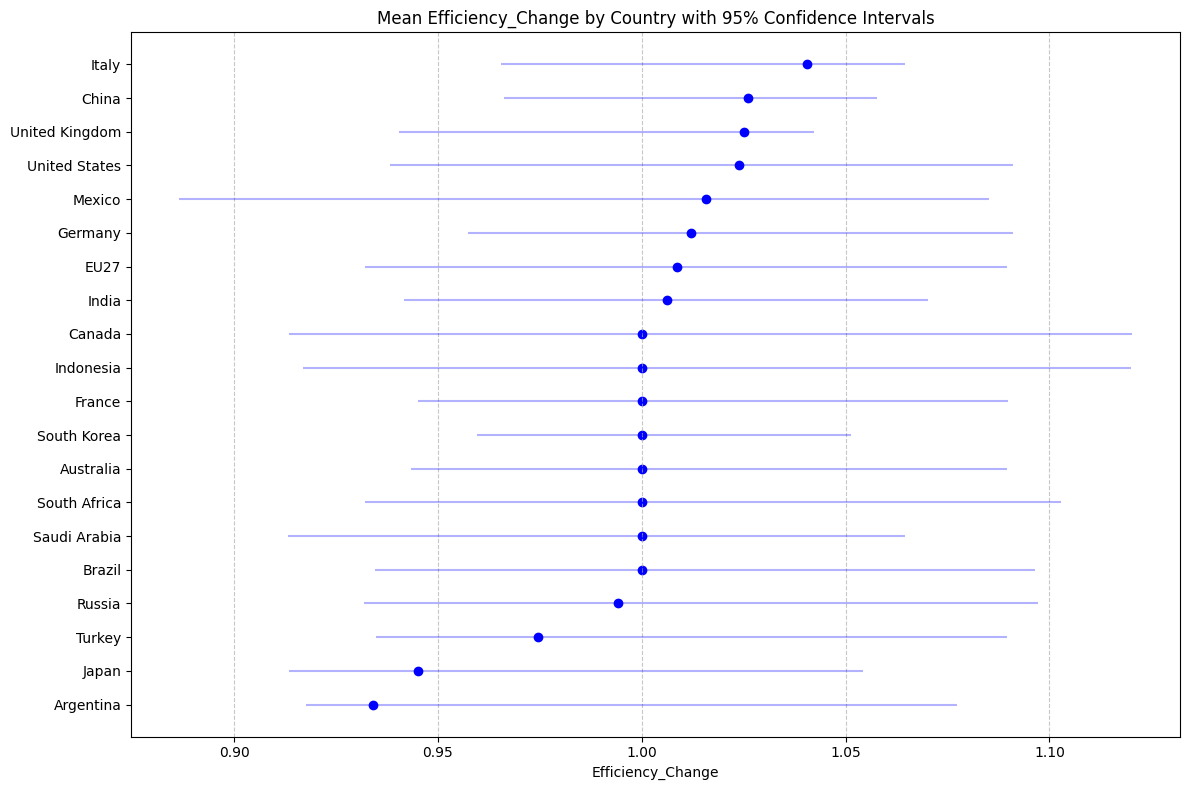

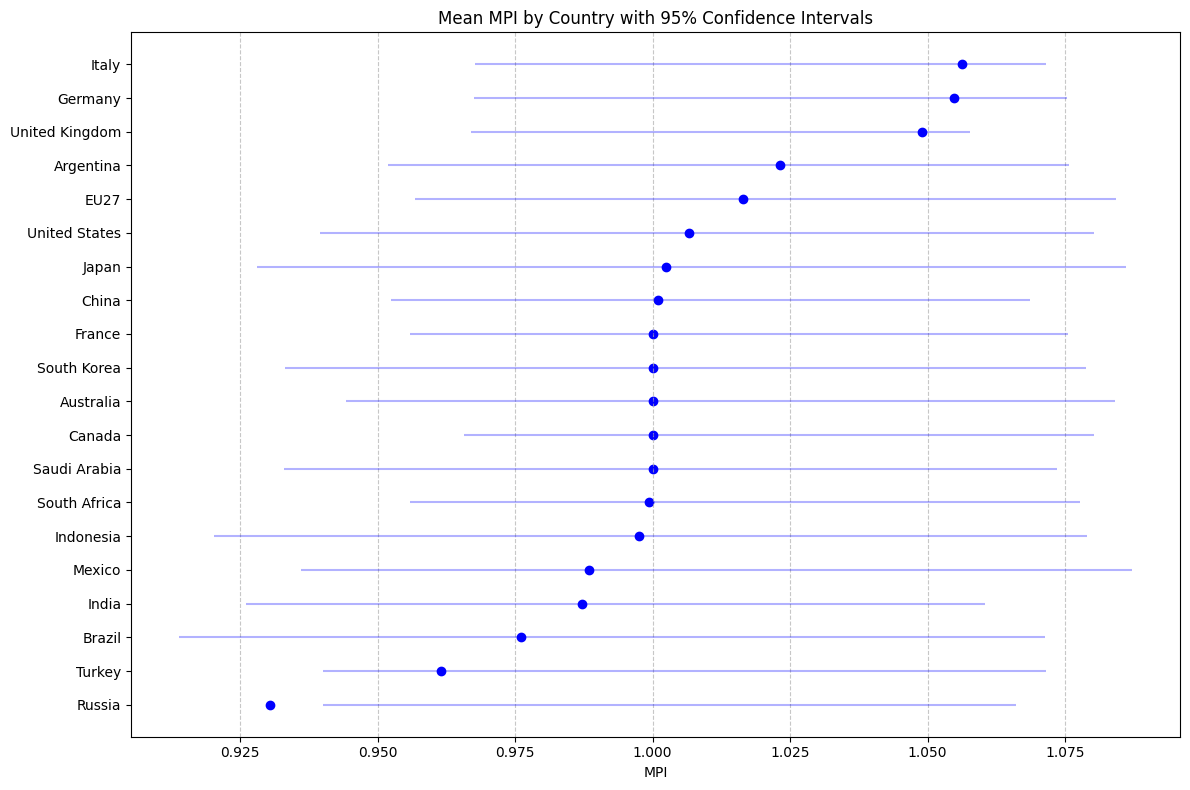

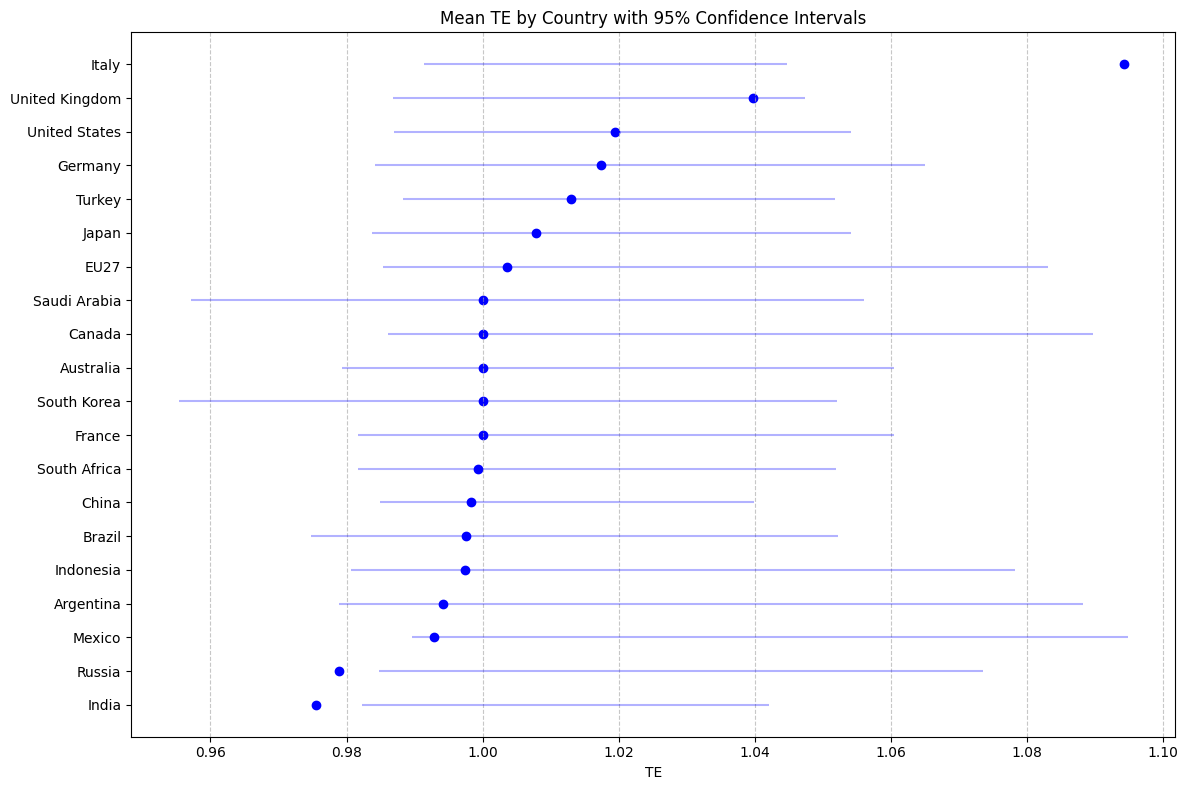

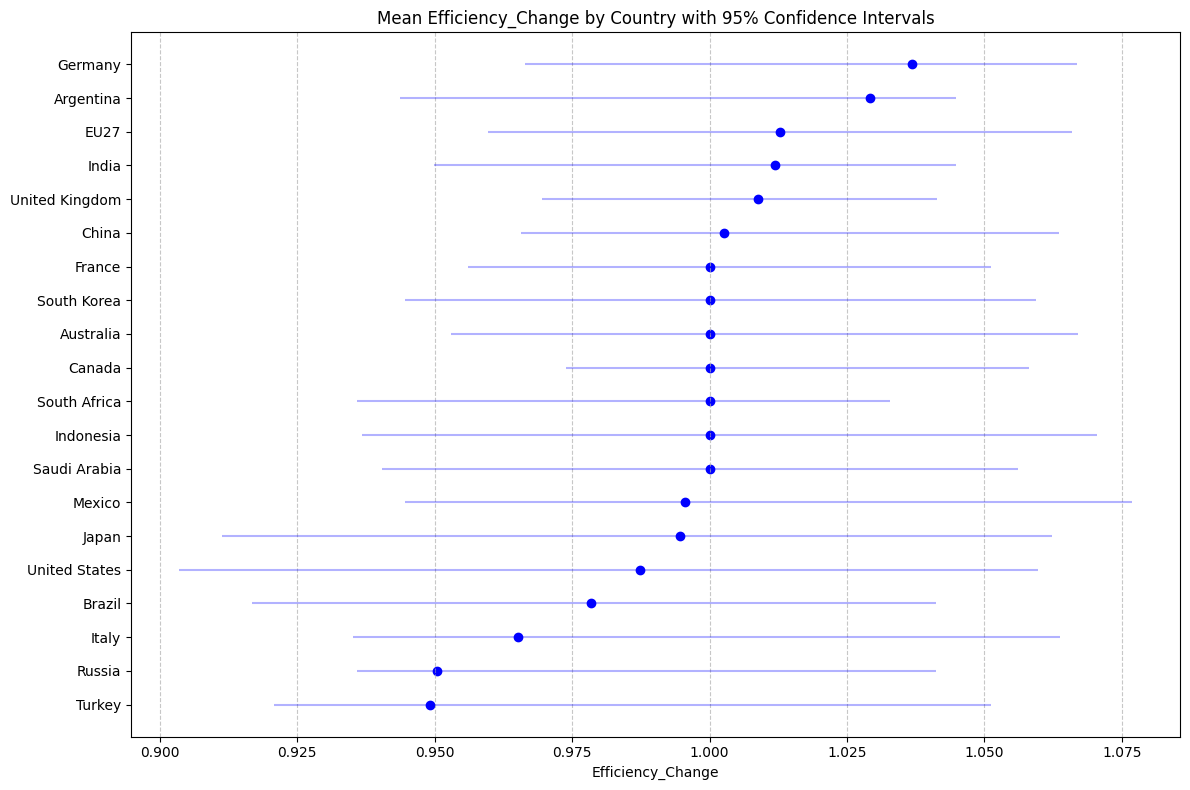

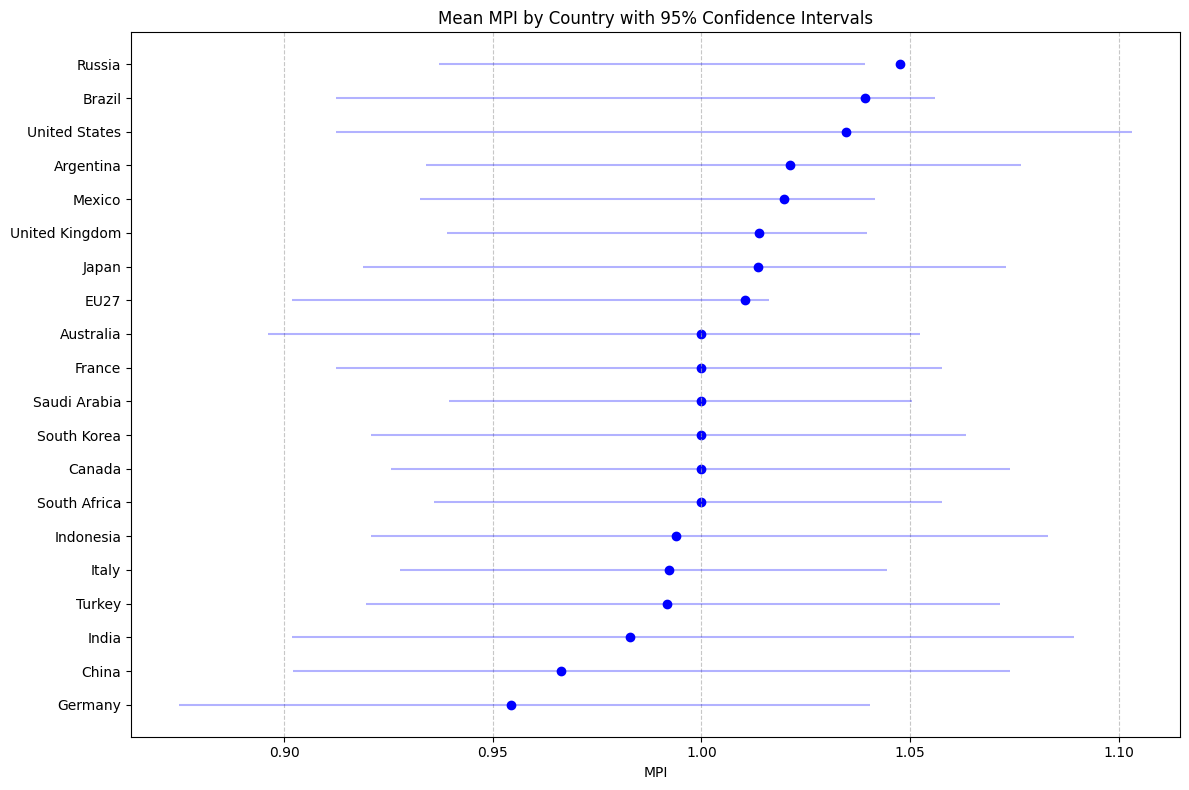

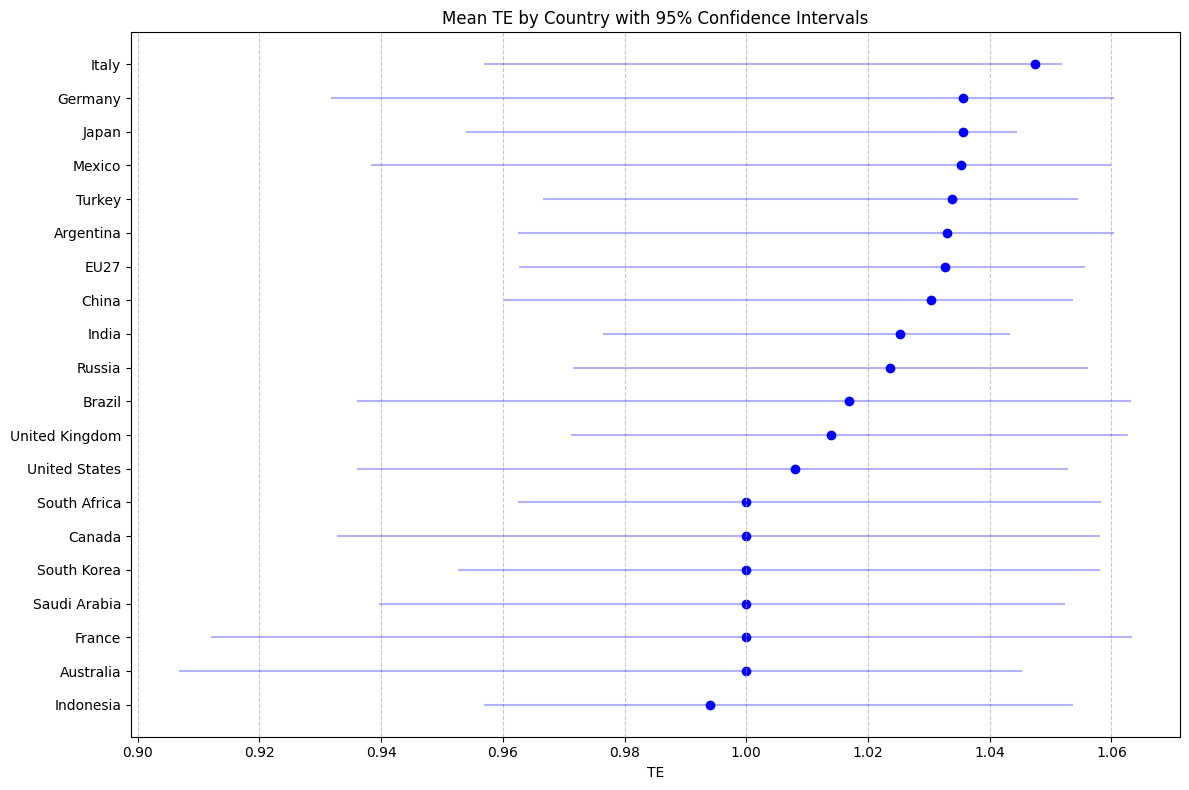

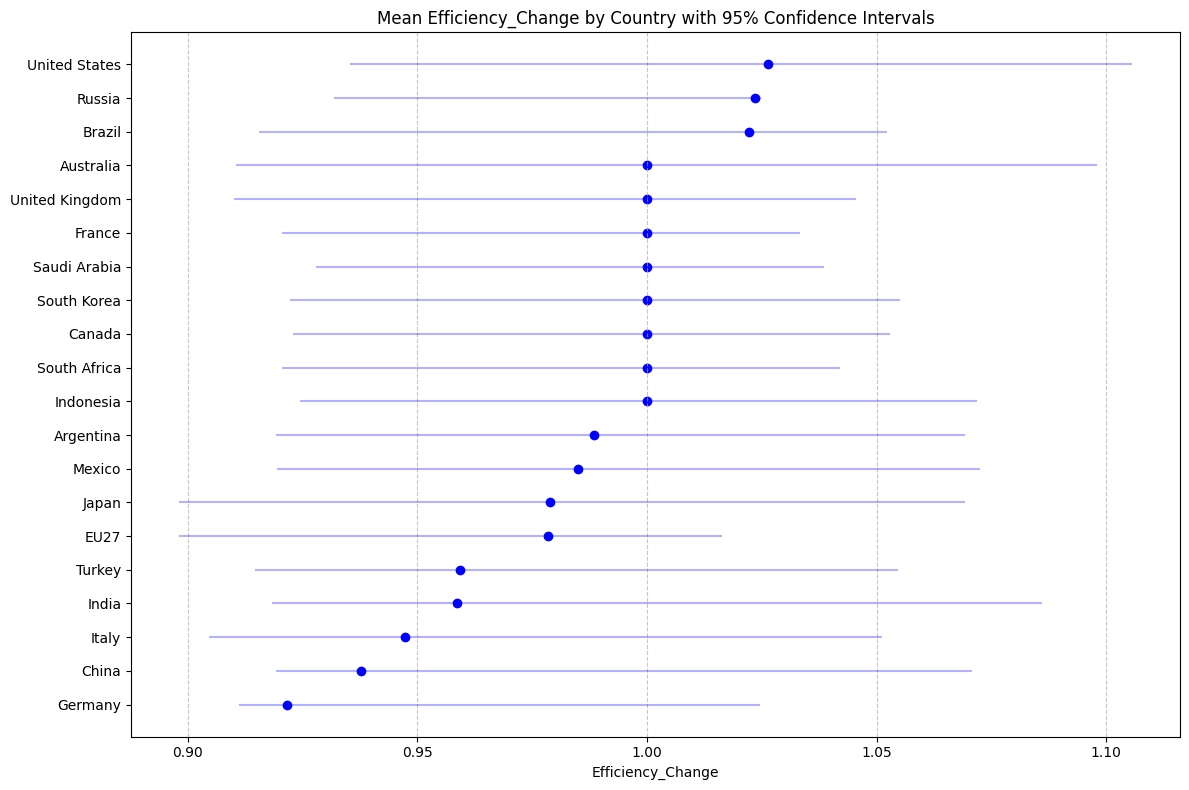

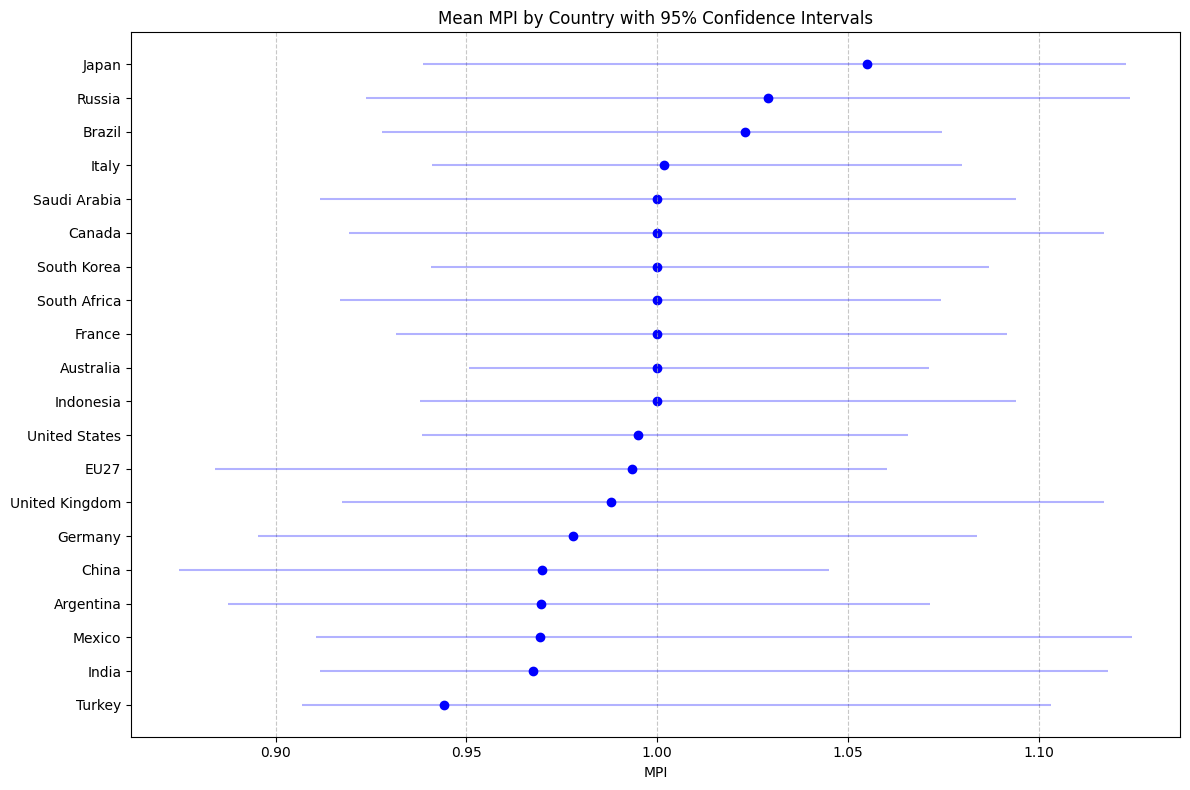

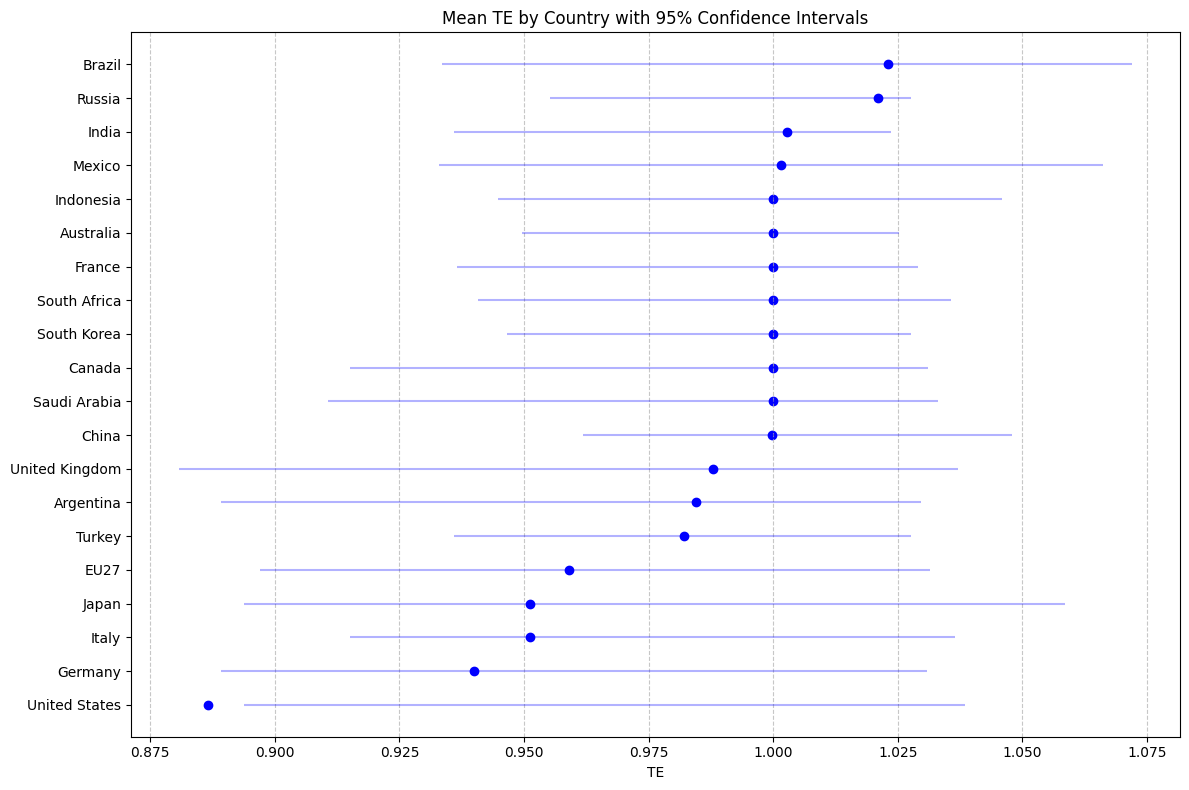

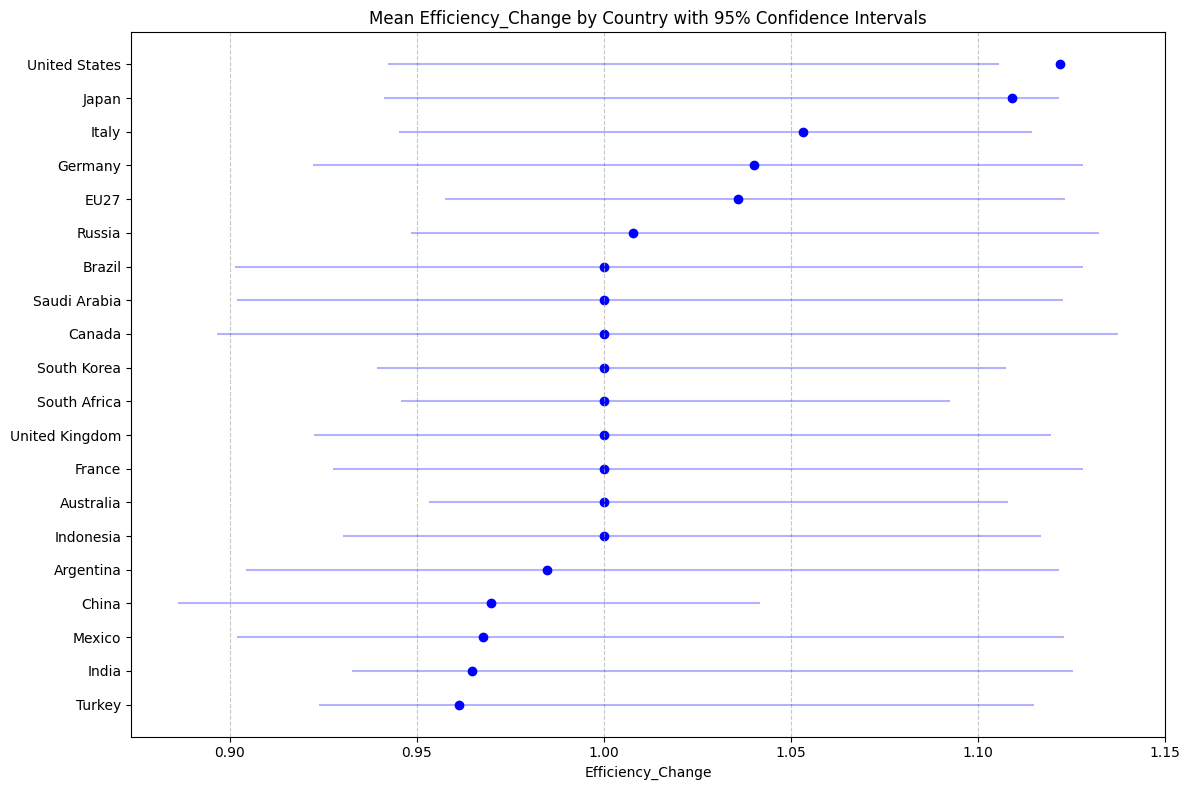

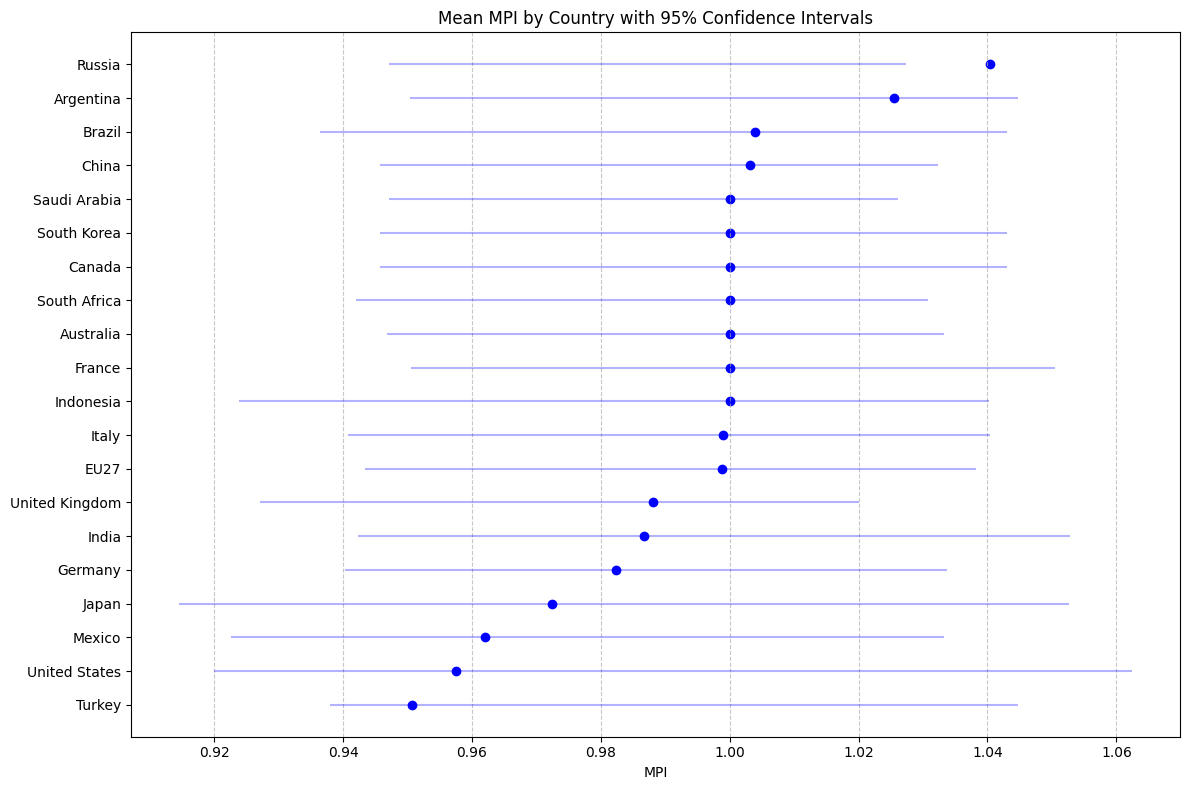

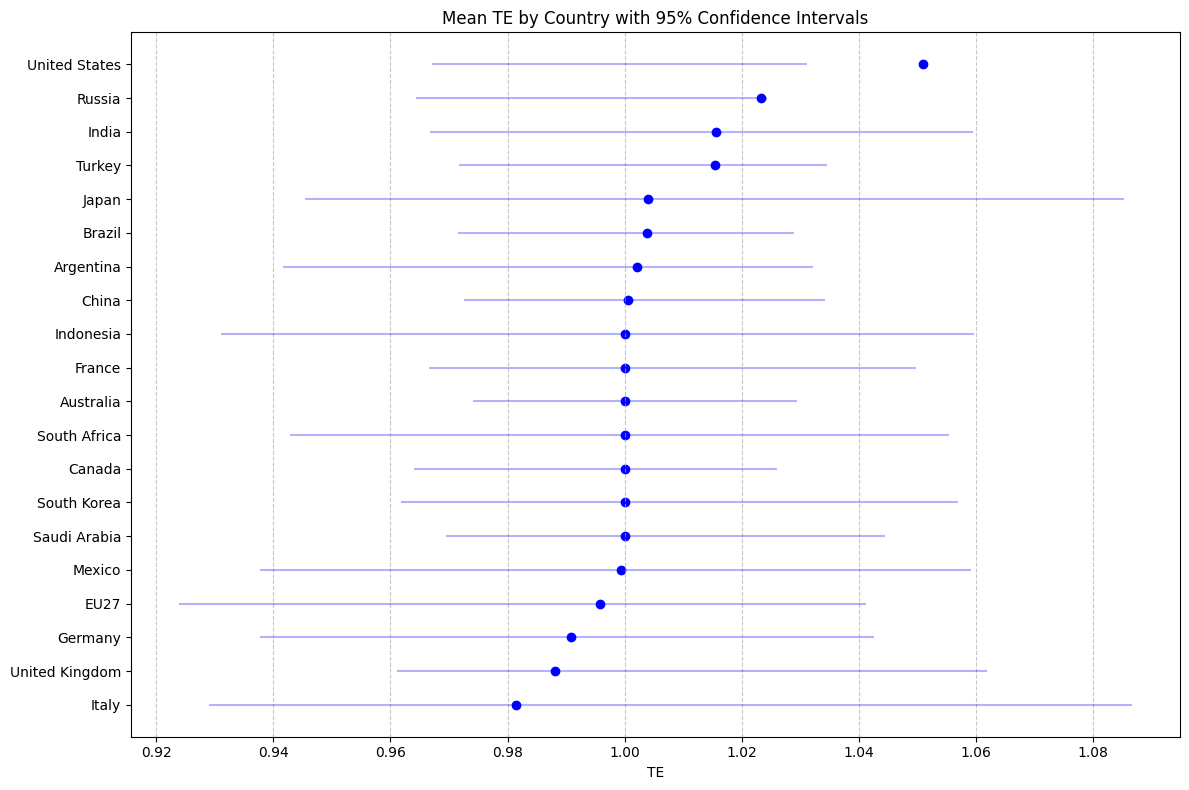

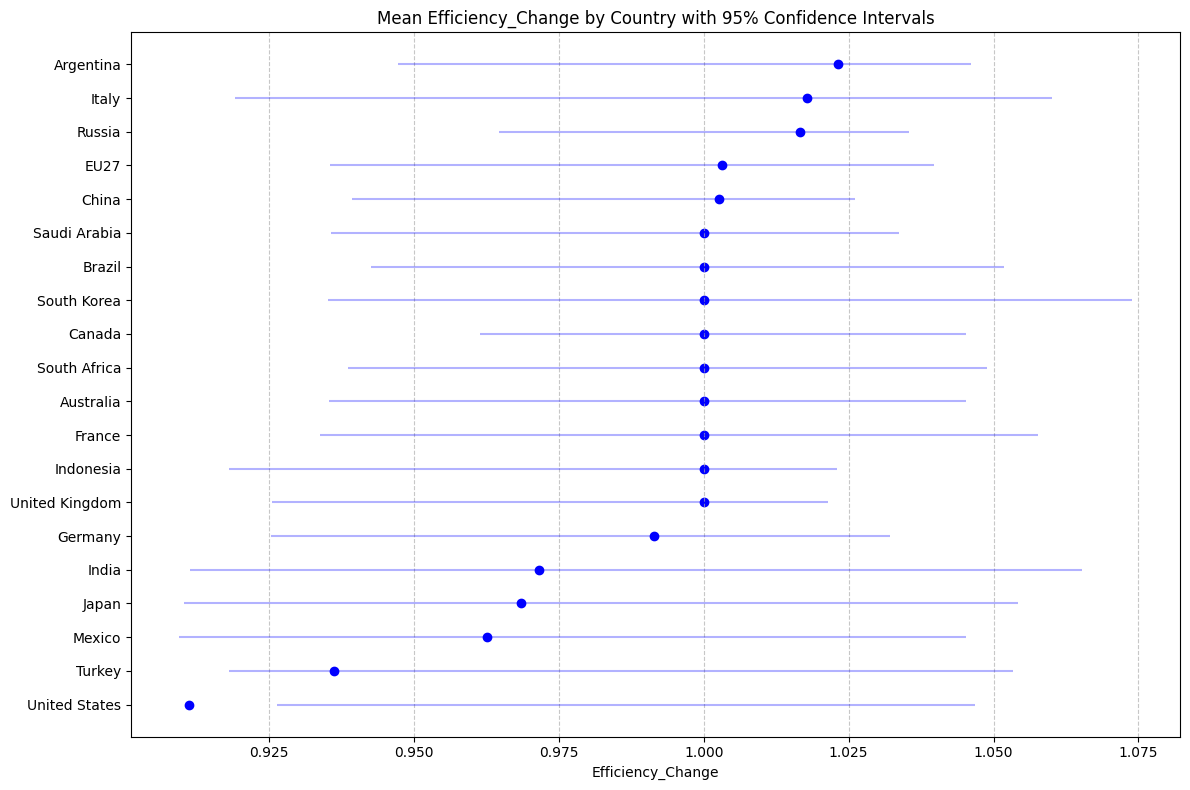

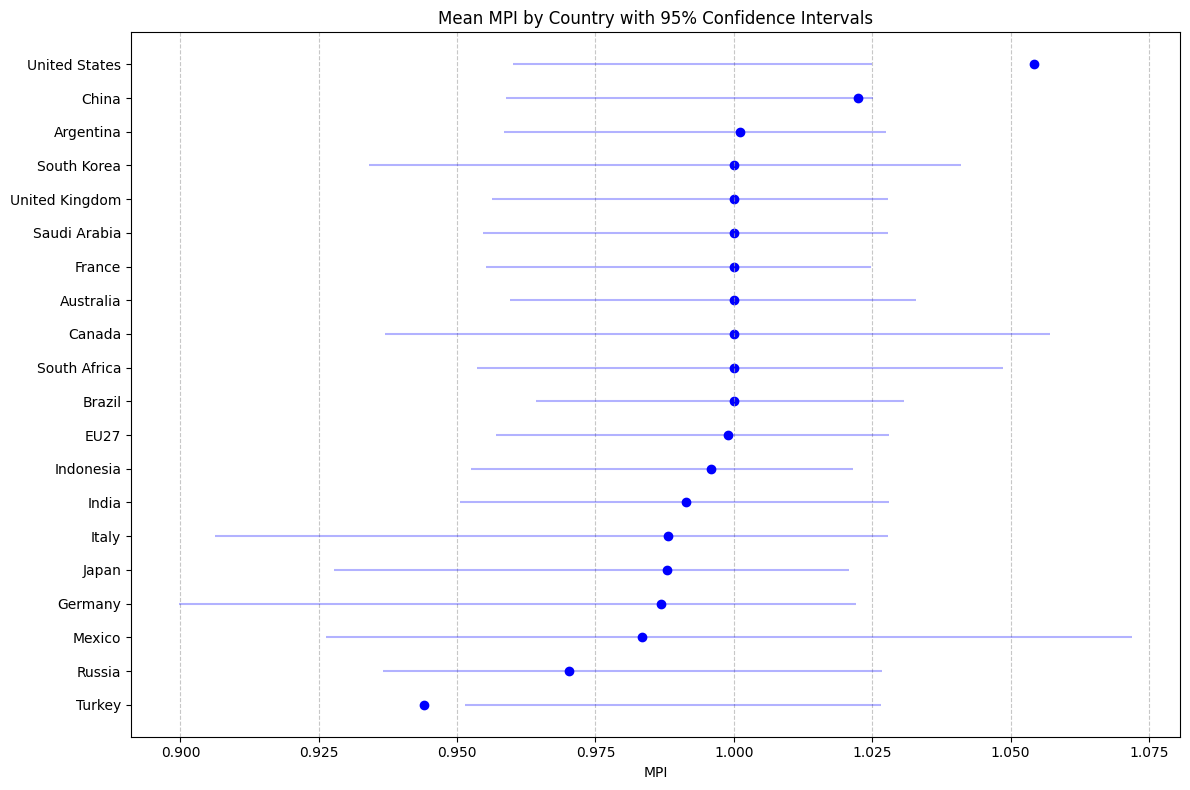

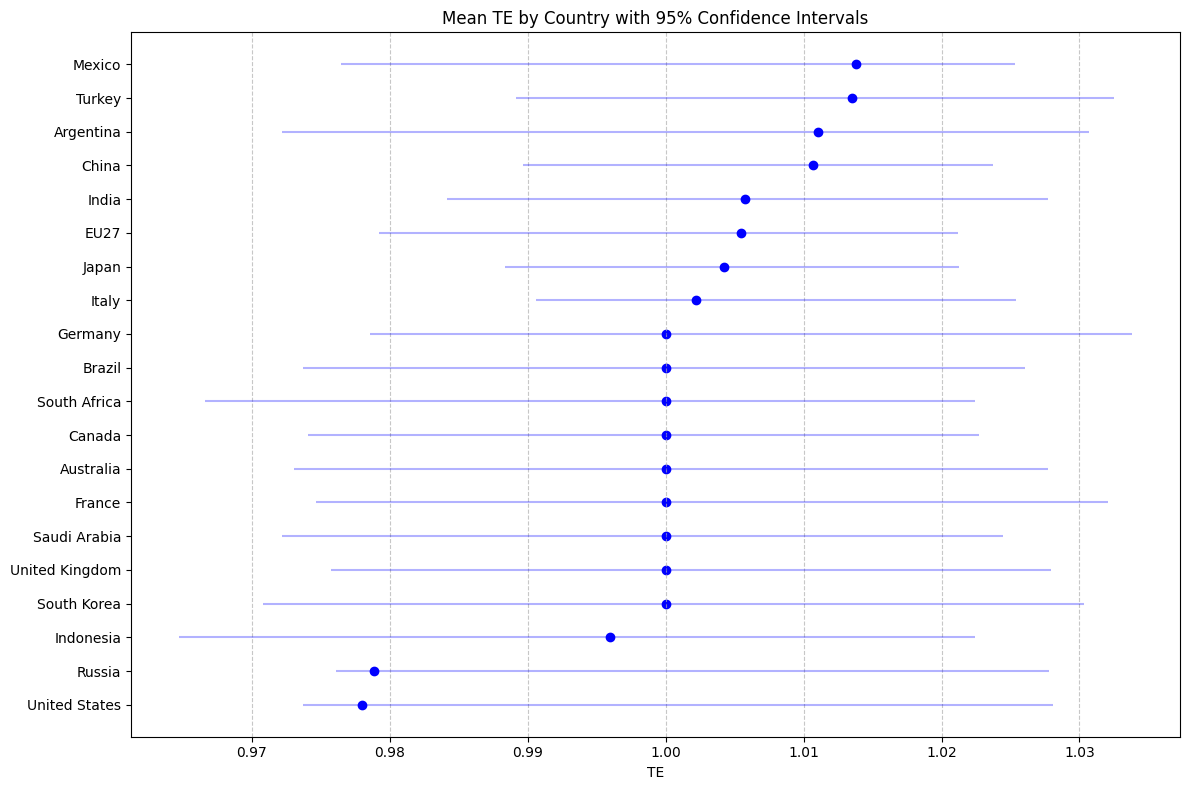

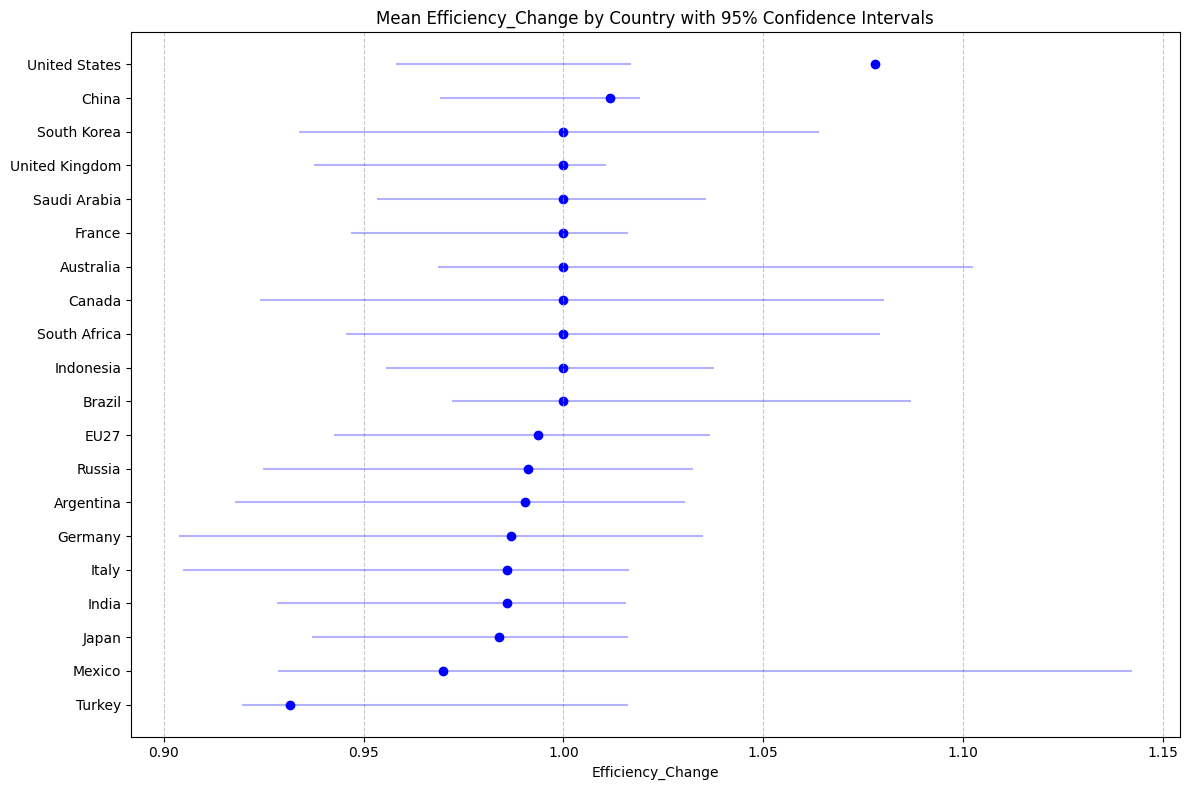

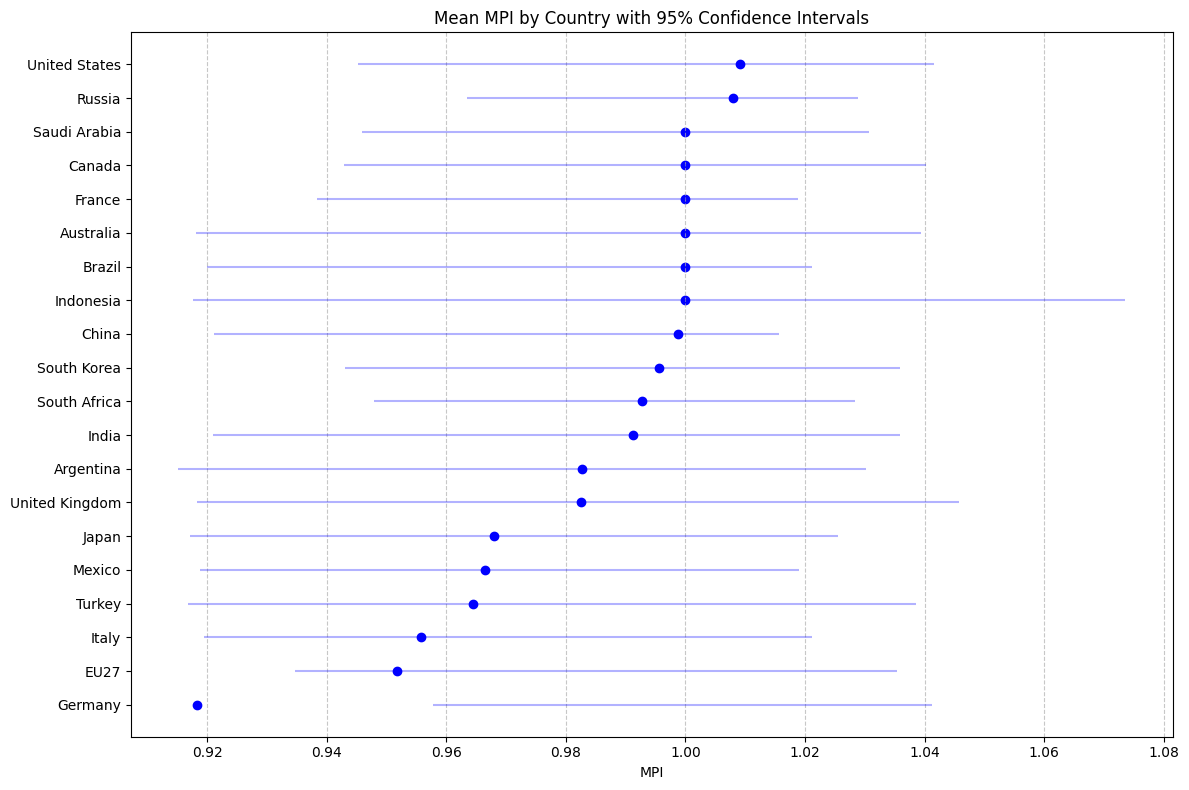

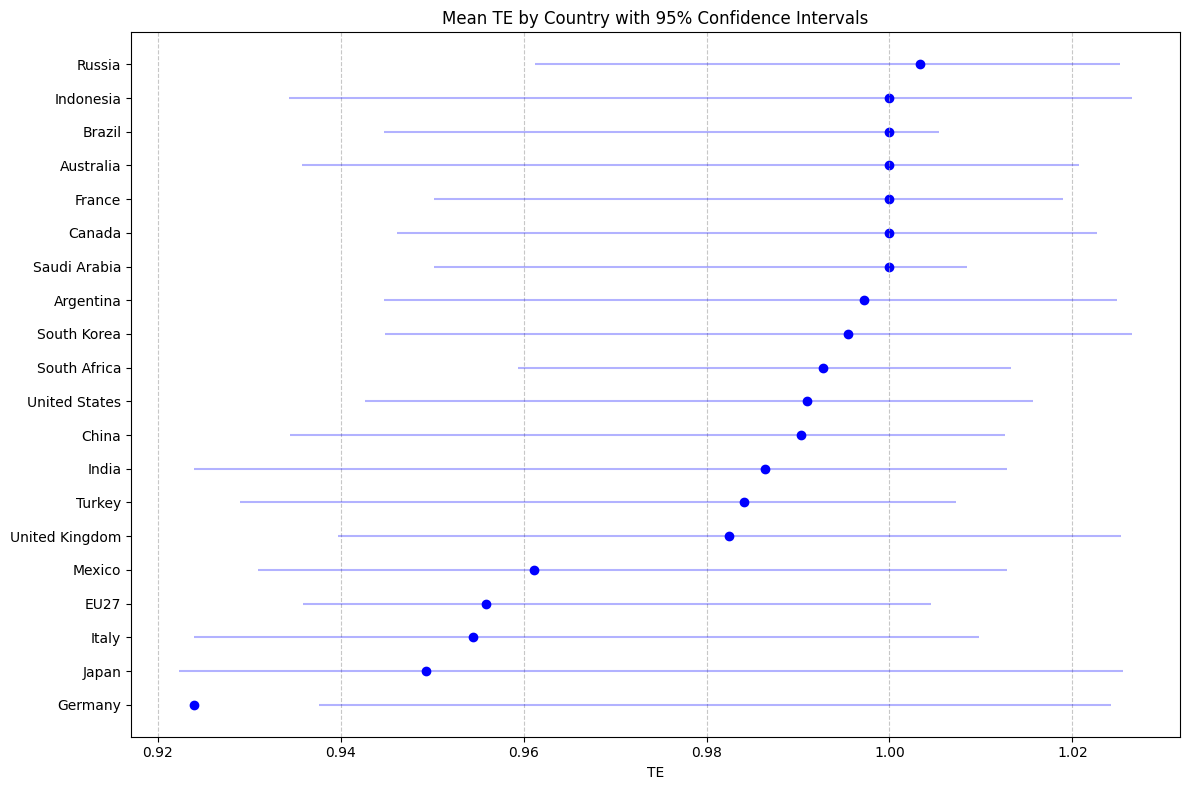

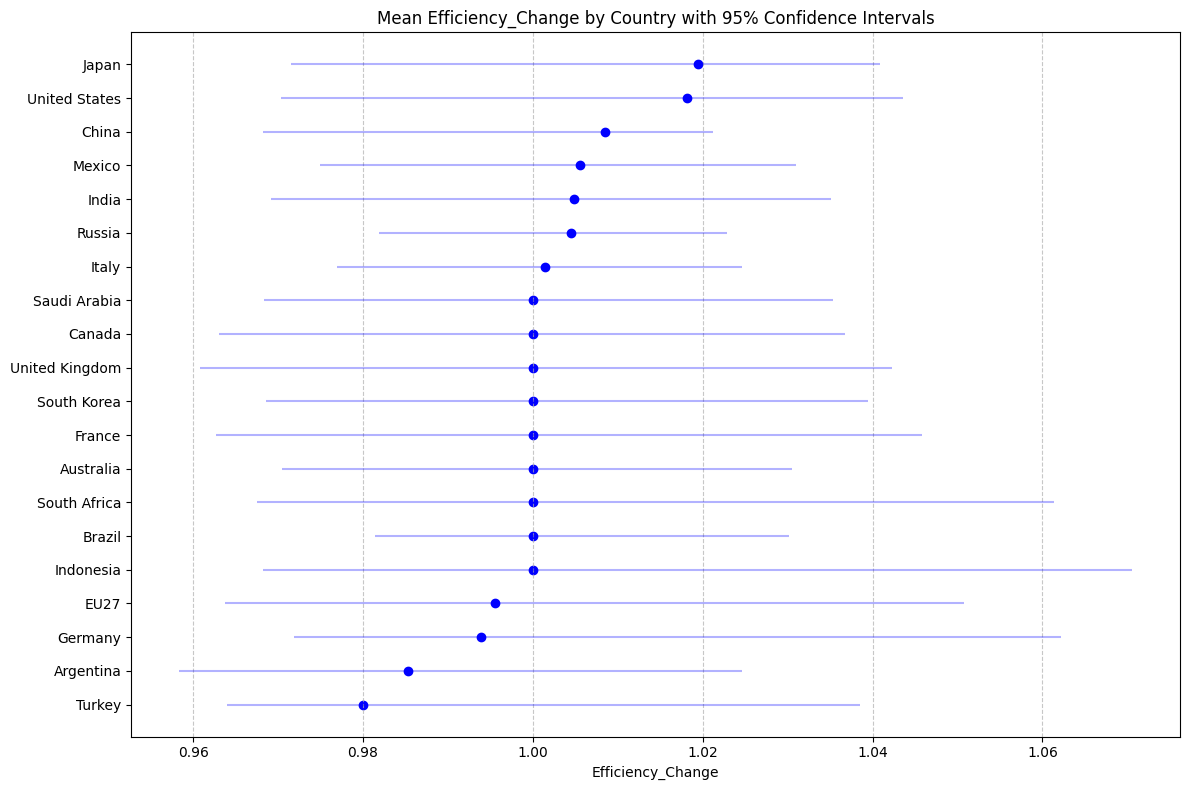

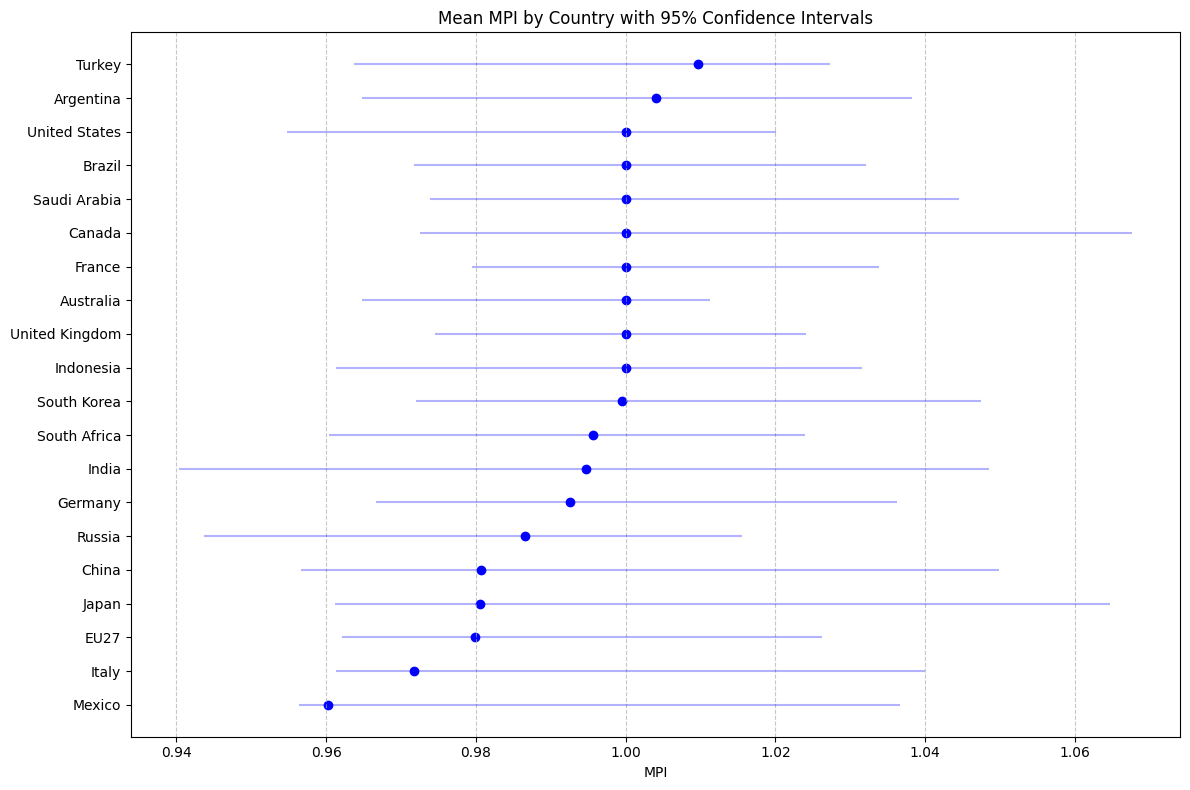

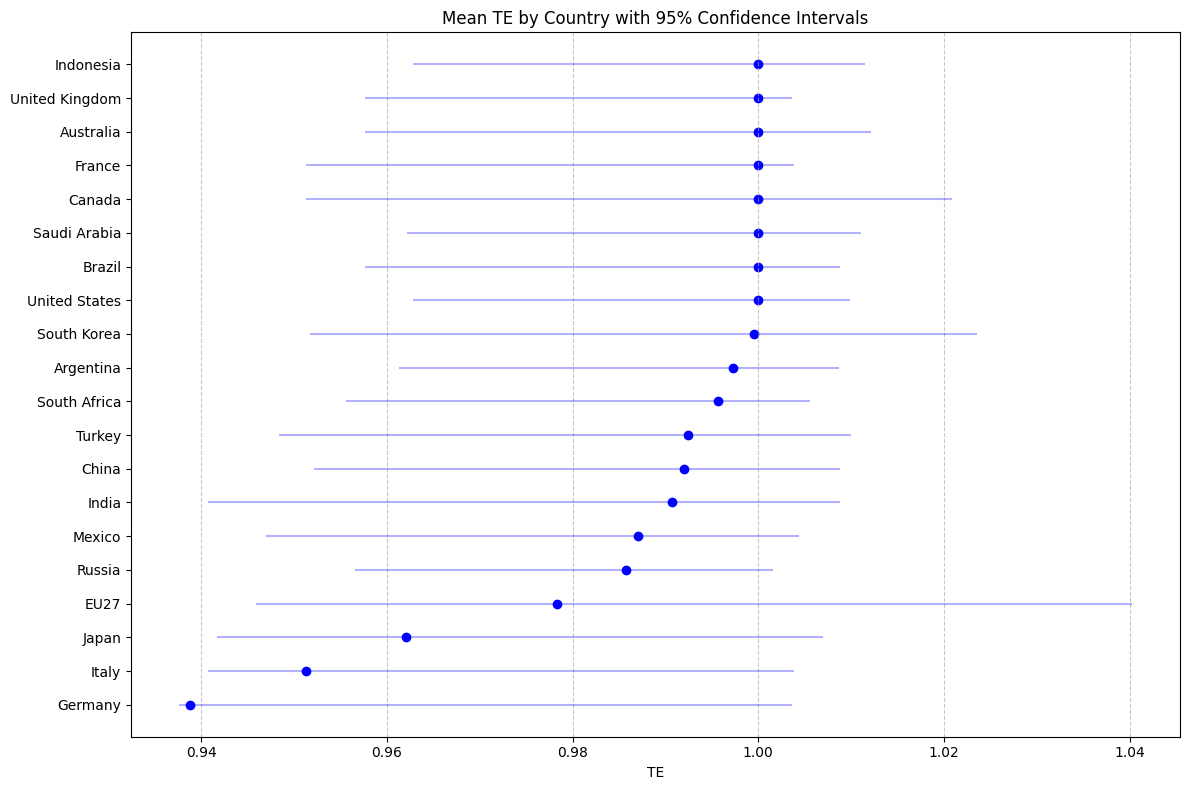

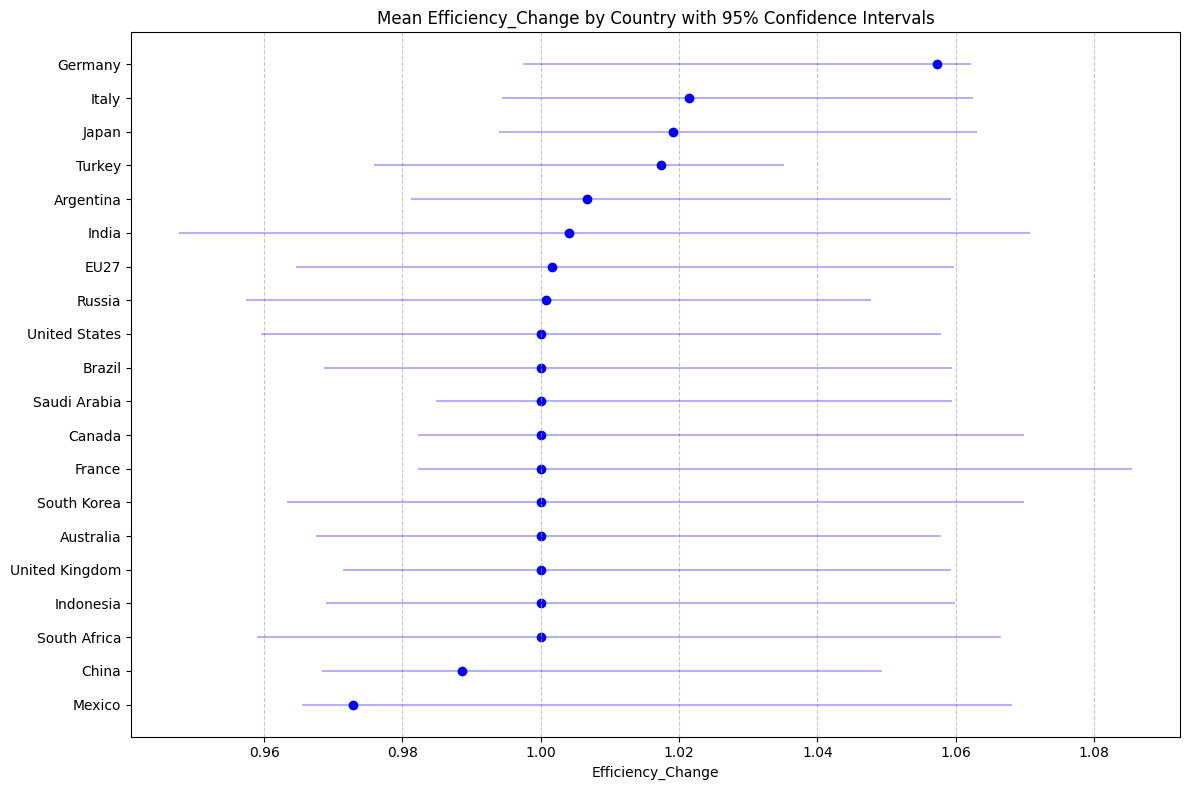

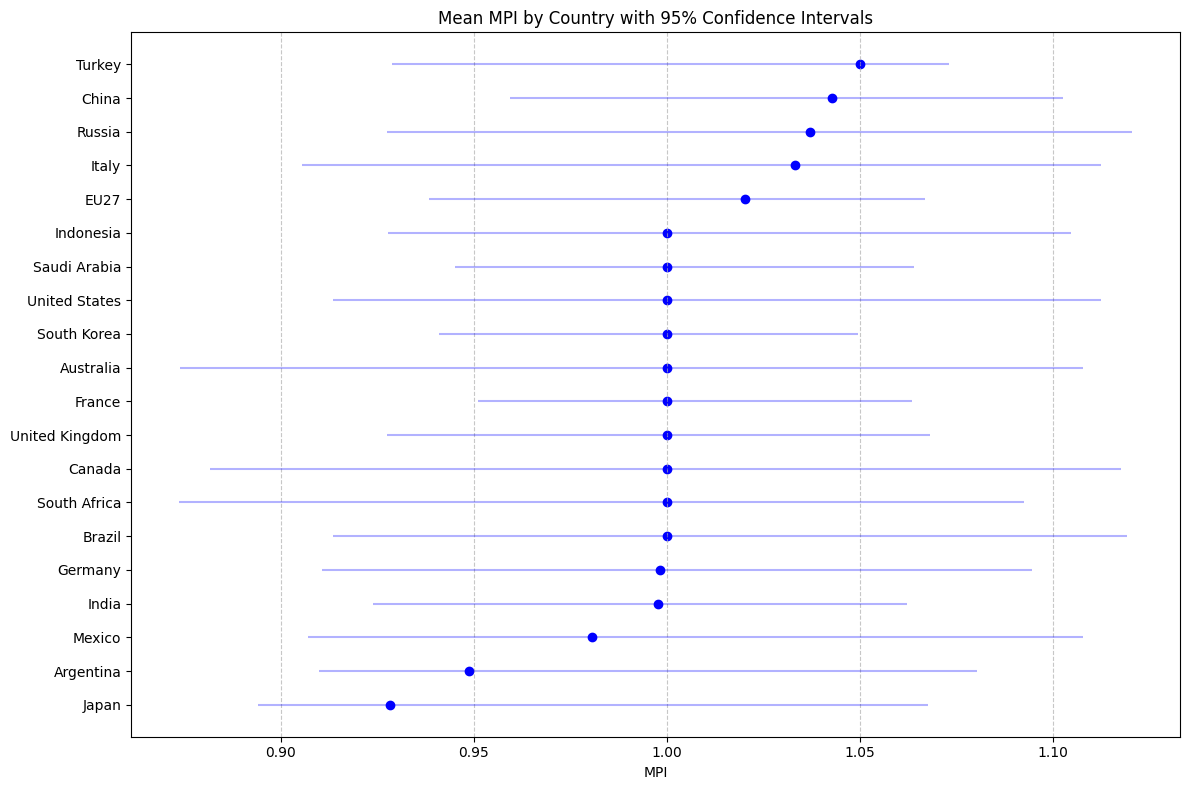

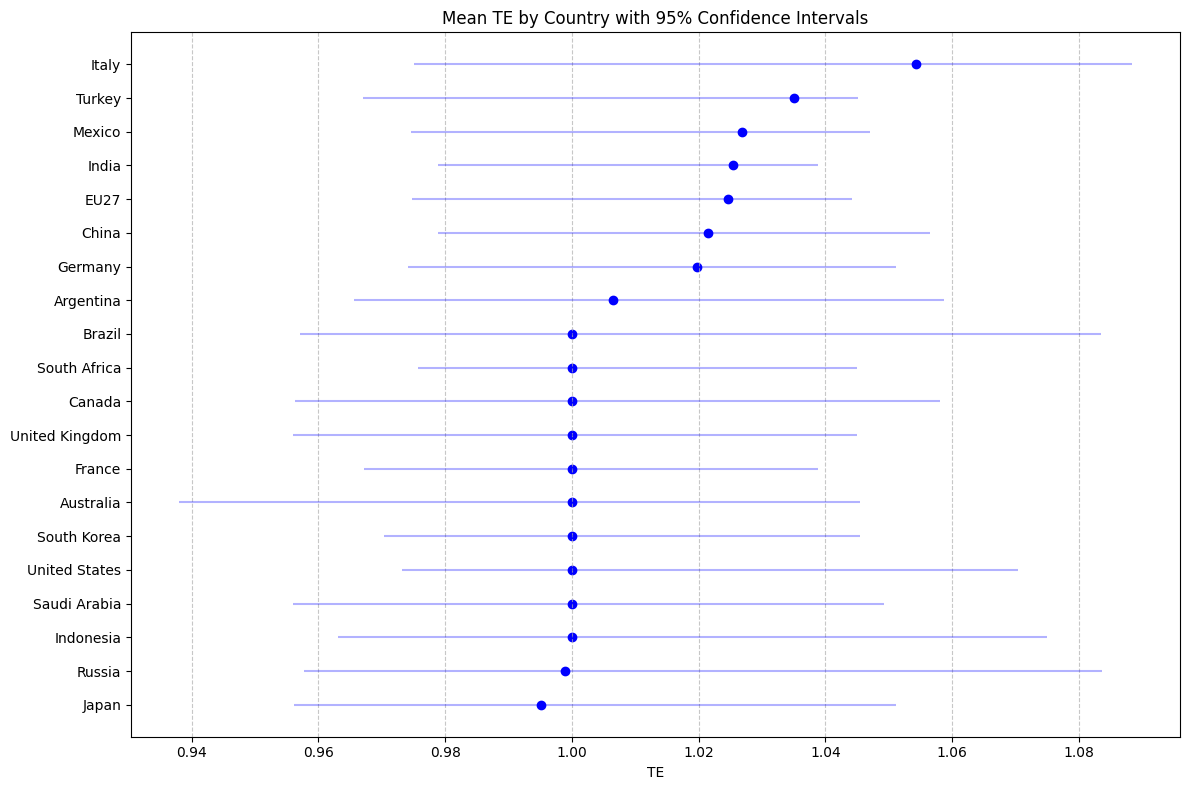

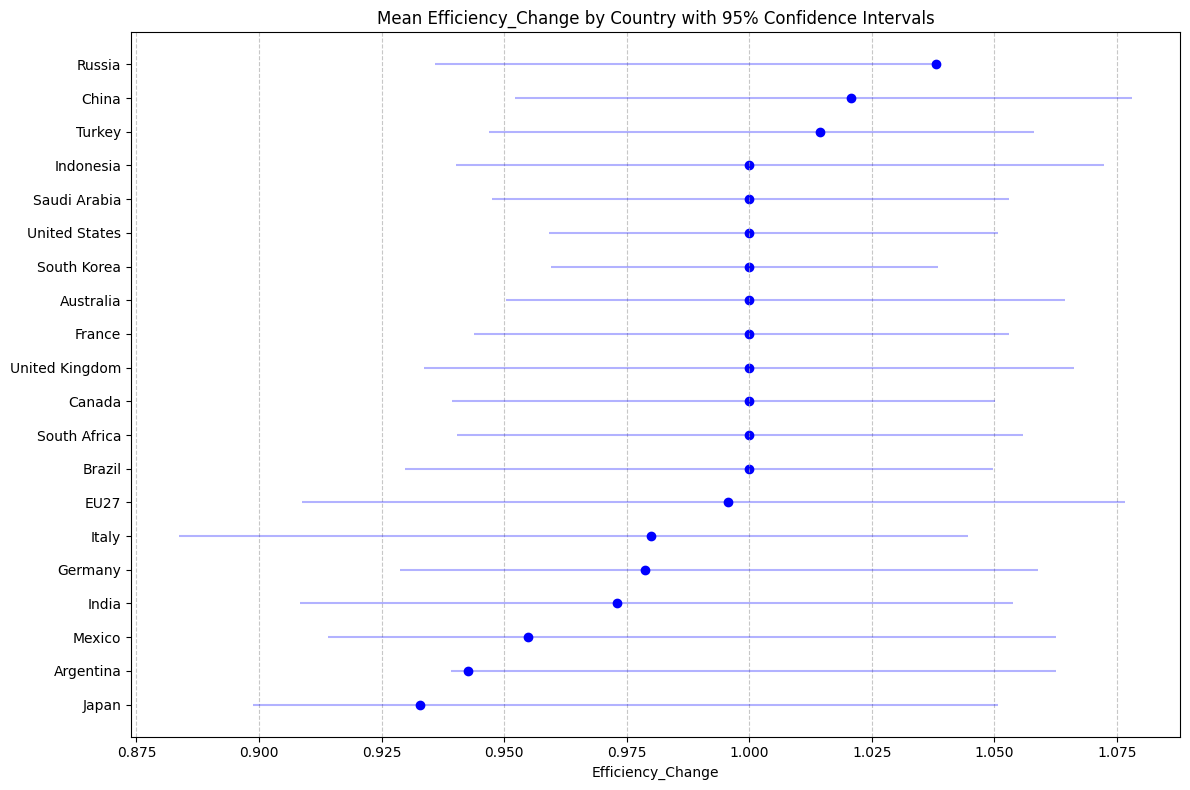

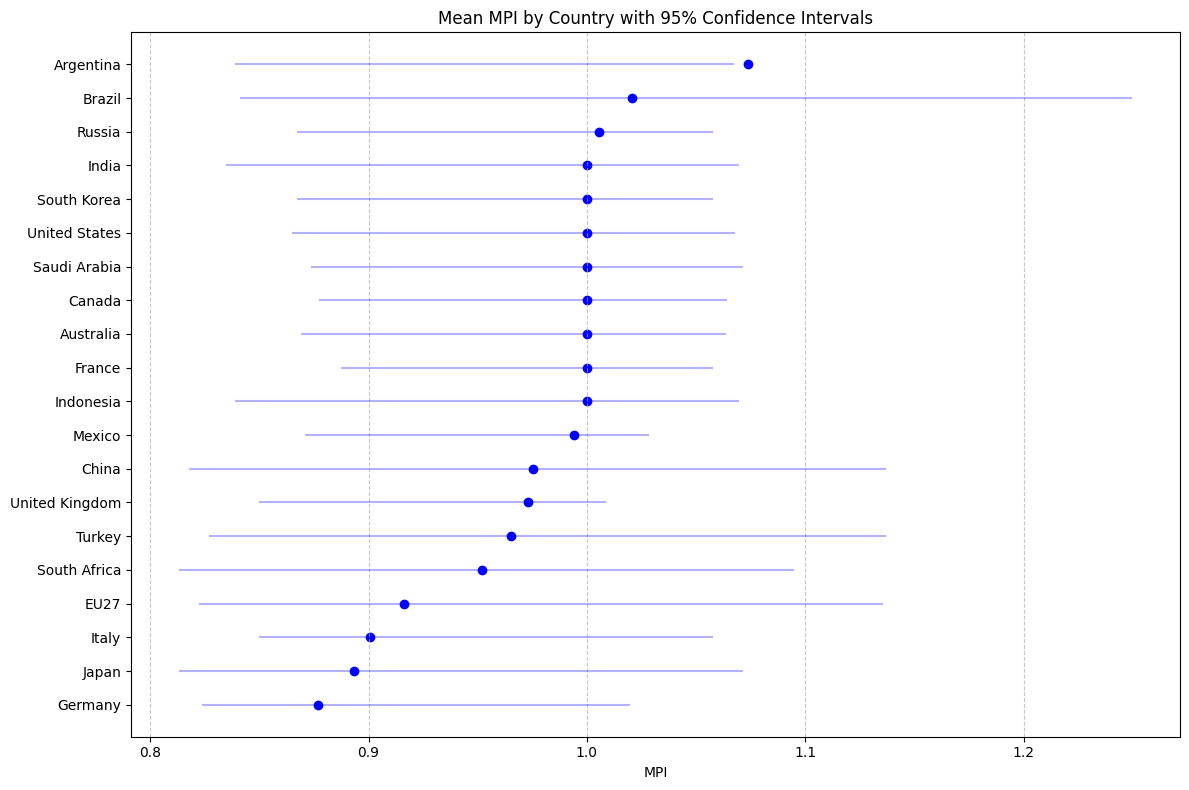

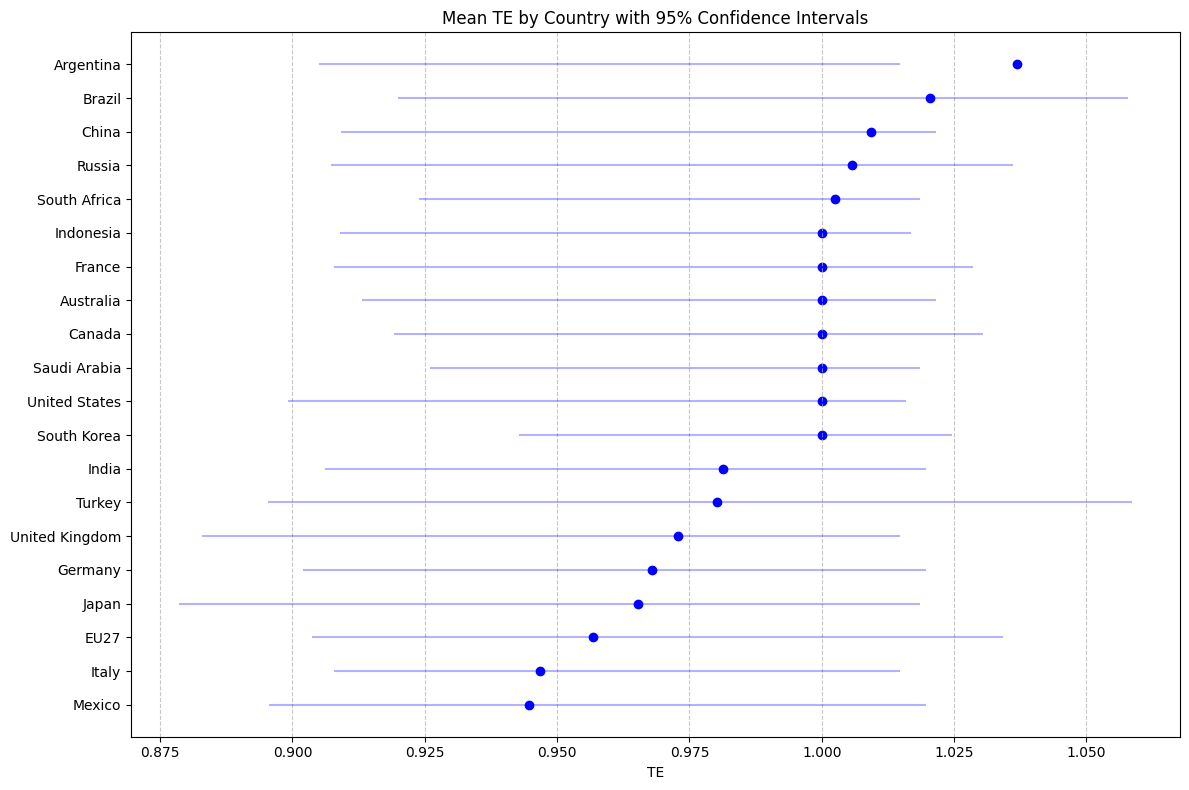

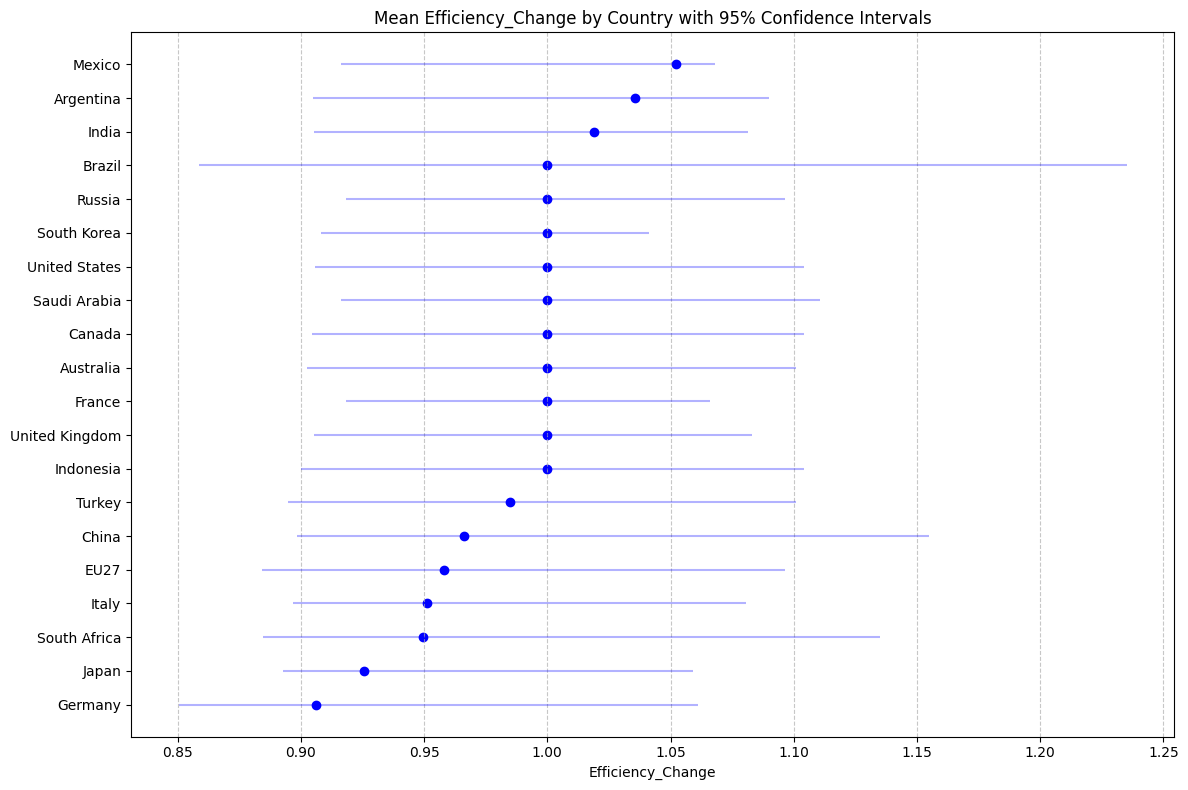

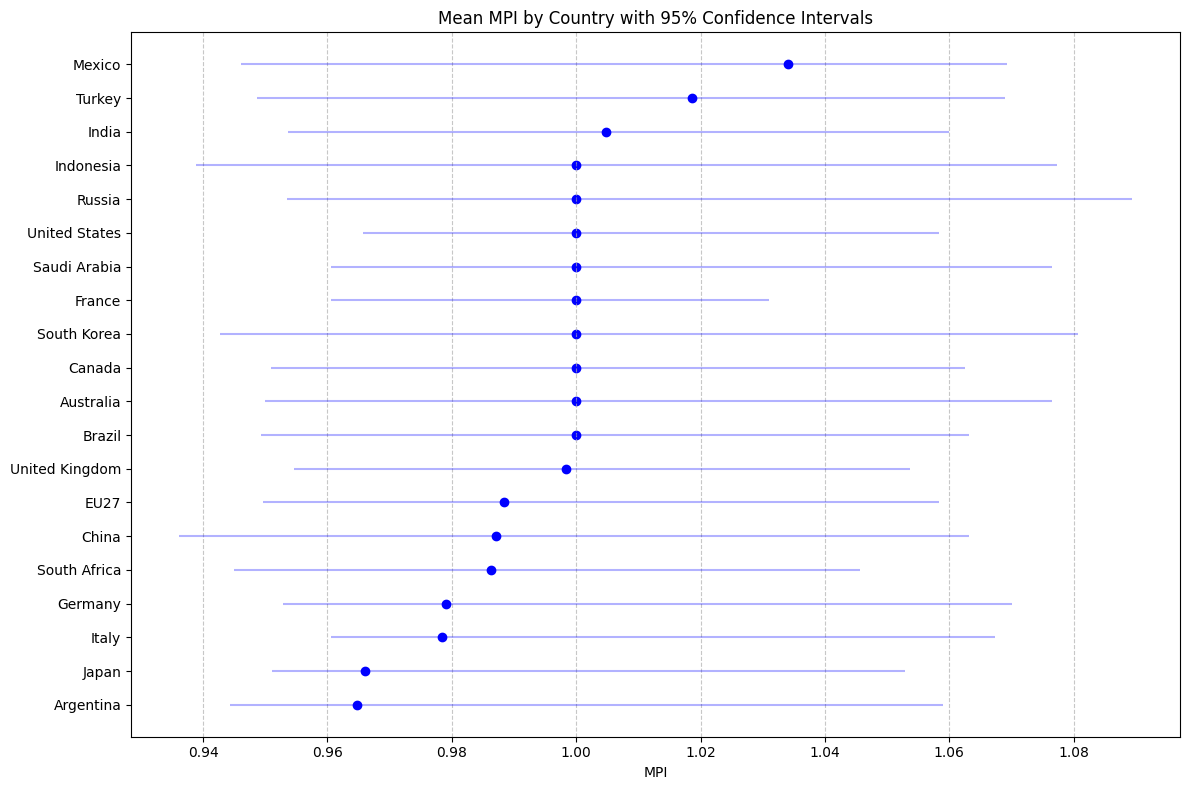

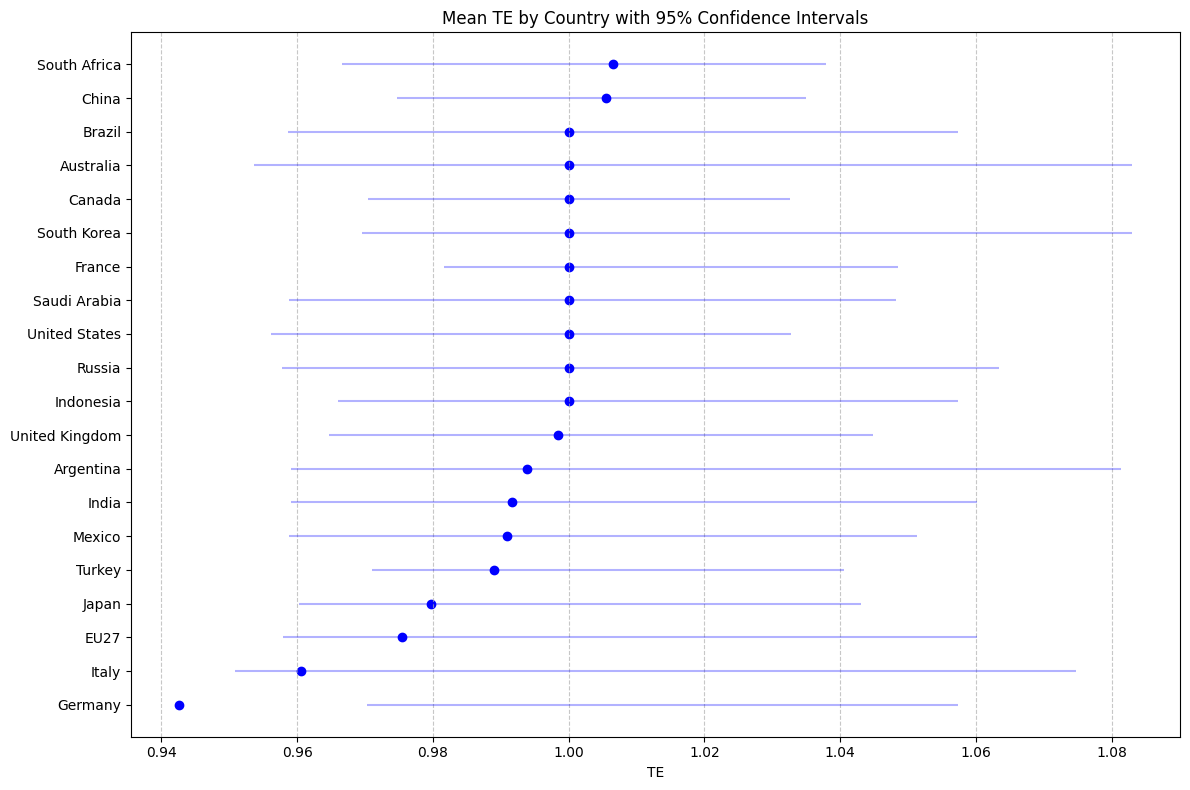

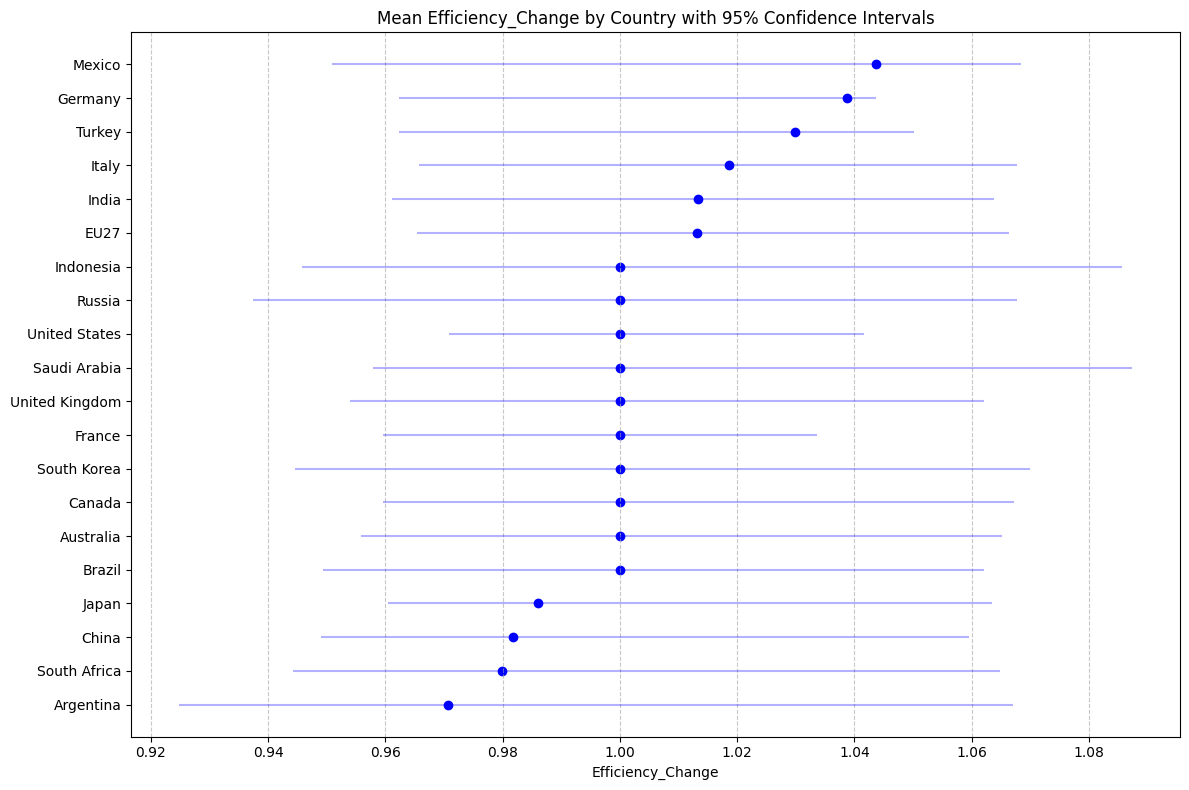

In [ ]:

range1 = range(2000,2023)
range2 = range(2001,2024)
results_all = {} ; summary = {}
for year1, year2 in zip(range1, range2):
    print ("\n\n\n*************************************")
    print("Analyzing following time period %s %s" % (year1, year2))
    print ("*************************************")
    key = "%s_%s" % (year1, year2)
    results_all[key], summary[key], ret = run_all(df, year1, year2, bootstrap = 1)



#run_all(df,2000,2001)

In [ ]:
# Setup Directory to write
dir2write = datetime.now().strftime("/content/drive/MyDrive/out/%Y%m%d%H%M%S"+"_summary")
os.mkdir(dir2write )

In [ ]:
# Compute and save geometrical mean per country for all epochs
mean_mpi_dict = {} ; mean_technical_change_dict = {} ; mean_efficiency_change_dict = {}

for key in results_all.keys():
  #print(type(results_all[key]))
  df = results_all[key]
  for country in df.DMU:
    #print (country)
    #print([df['DMU']])
    #print(df.loc[df['DMU']==country]['MPI'].mean())
    if country not in mean_mpi_dict.keys():
      mean_mpi_dict[country] = []
      mean_technical_change_dict[country] = []
      mean_efficiency_change_dict[country] = []

    mean_mpi_dict[country].append(df.loc[df['DMU']==country]['MPI'].mean())
    mean_technical_change_dict[country].append(df.loc[df['DMU']==country]['Technical_Change'].mean())
    mean_efficiency_change_dict[country].append(df.loc[df['DMU']==country]['Efficiency_Change'].mean())

mean_mpi = pd.DataFrame()
mean_technical_change = pd.DataFrame()
mean_efficiency_change = pd.DataFrame()
for country in mean_mpi_dict.keys():
  mean_mpi[country] = np.array(mean_mpi_dict[country])
  mean_technical_change[country] = np.array(mean_technical_change_dict[country])
  mean_efficiency_change[country] = np.array(mean_efficiency_change_dict[country])

print(mean_mpi.head(23))
#mean_mpi.to_csv(os.path.join(dir2write, "mean_mpi"))

lst = []
for country in mean_mpi_dict.keys():
  #print(country)
  lst.append([country,
              gmean(mean_mpi[country]),
              gmean(mean_technical_change[country]),
              gmean(mean_efficiency_change[country])
              ])
#print(gmean(mean_mpi[country]))

geo_mean_values = pd.DataFrame(lst,columns=['country', 'MPI (geom mean)','Technical_Change (geom mean)', 'Efficiency_Change (geo mean)'])
print(geo_mean_values.head(23))
geo_mean_values.to_csv(os.path.join(dir2write, "geo_mean_values_per_country.csv"))



    Argentina  Australia    Brazil  Canada     China      EU27    France  \
0    1.000001        1.0  0.970763     1.0  1.013995  1.039752  1.000000   
1    0.999999        1.0  1.016017     1.0  1.016373  1.008415  1.002474   
2    0.968745        1.0  1.028006     1.0  1.043573  1.080453  1.000000   
3    0.878127        1.0  0.987647     1.0  1.004895  1.011022  1.000000   
4    1.027185        1.0  1.005812     1.0  0.976577  0.977314  1.000000   
5    0.959461        1.0  1.000000     1.0  0.975630  1.012459  1.000000   
6    1.002495        1.0  1.002311     1.0  0.974772  0.972942  1.000000   
7    0.956508        1.0  0.989823     1.0  0.976721  1.013649  1.000000   
8    1.041199        1.0  1.028769     1.0  1.005818  0.981121  1.000000   
9    1.000618        1.0  1.000000     1.0  1.022210  0.951541  1.000000   
10   0.902759        1.0  1.000000     1.0  0.989401  0.908031  1.000000   
11   1.007657        1.0  0.985619     1.0  0.982364  0.938788  1.000000   
12   0.88398

In [ ]:
# Setup mean the mean per epoch
lst = []
for key in summary.keys():
  lst.append([key,summary[key]["MPI"].mean(),
              summary[key]["Technical_Change"].mean(),
              summary[key]["Efficiency_Change"].mean()
            ])

mean_values = pd.DataFrame(lst,columns=['year', 'MPI','Technical_Change', 'Efficiency_Change'])
mean_values.head(23)
mean_values.to_csv(os.path.join(dir2write, "mean_values_per_year.csv"))